In [1]:
%load_ext autoreload
%autoreload 2

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on MNIST dataset

In [2]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
import numpy as np
import torch

In [3]:
class NusWideDataset(ImageFolder):
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

In [4]:
transform = transforms.Compose([
    transforms.Resize((40,40)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
data = NusWideDataset('./Flickr', transform=transform)

In [5]:
n = len(data)
n_classes = 10
indices = list(range(n))
split = n * 20 // 100

test_idx = np.random.choice(indices, size=split, replace=False)
train_idx = list(set(indices) - set(test_idx))
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)

## Common setup

In [6]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mnist_classes = ['cat', 'coast', 'dog', 'food', 'fruit', 'goat', 'monks', 'person', 'shops', 'vehicle']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

In [7]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(data, sampler=train_sampler, batch_size=batch_size, **kwargs)
test_loader = torch.utils.data.DataLoader(data, sampler=test_sampler, batch_size=batch_size, **kwargs)

shops, cat, cat, person, goat


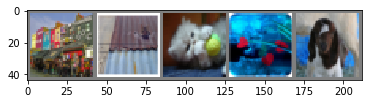

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
num_examples = 5
imshow(torchvision.utils.make_grid(images[:num_examples]))
print(', '.join([mnist_classes[labels[i]] for i in range(num_examples)]))

In [9]:
# Set up the network and training parameters
from networks import EmbeddingNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 20

In [10]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

Train: [0/3721 (0%)]	Loss: 2.360004	Accuracy: 10.546875
Epoch: 1/20. Train set: Average loss: 6.4241	Accuracy: 10.984212294255963
Epoch: 1/20. Validation set: Average loss: 3.0252	Accuracy: 9.274193548387096
Train: [0/3721 (0%)]	Loss: 3.203067	Accuracy: 10.15625
Epoch: 2/20. Train set: Average loss: 2.8606	Accuracy: 10.614712798118912
Epoch: 2/20. Validation set: Average loss: 2.4005	Accuracy: 8.736559139784946
Train: [0/3721 (0%)]	Loss: 2.457583	Accuracy: 5.859375
Epoch: 3/20. Train set: Average loss: 2.3971	Accuracy: 9.338259993281827
Epoch: 3/20. Validation set: Average loss: 2.3488	Accuracy: 9.408602150537634
Train: [0/3721 (0%)]	Loss: 2.356346	Accuracy: 8.203125
Epoch: 4/20. Train set: Average loss: 2.3551	Accuracy: 10.043668122270743
Epoch: 4/20. Validation set: Average loss: 2.3148	Accuracy: 14.516129032258064
Train: [0/3721 (0%)]	Loss: 2.336430	Accuracy: 11.71875
Epoch: 5/20. Train set: Average loss: 2.3054	Accuracy: 12.025529056096742
Epoch: 5/20. Validation set: Average loss:

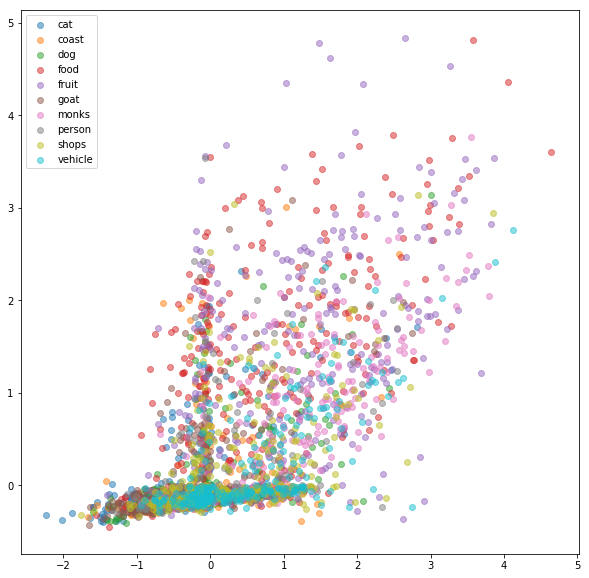

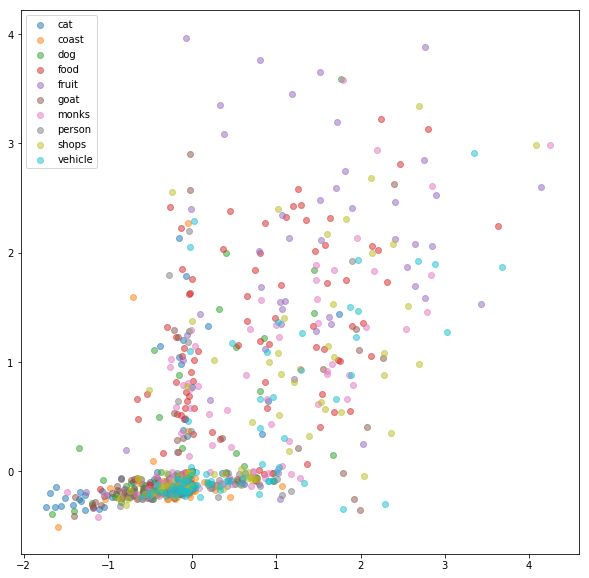

In [11]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baselindata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAk0AAAJCCAYAAADdrPONAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAIABJREFUeJzs3Xl4lOW5P/DvO0tmySwhZCSZQIC4hLAEIgGVCFYoqHU7WpXWXa5jj/6O9NhetdXaVtqjdsFznVbcqi0YFY+t9WhFWwsqFDzRQiiRLUQwhBiSyCQhs2T2mff3x5gxA1kms73vZL6f6/Ka5HXmnWcWMvfcz/3cjyCKIoiIiIhoZAqpB0BERESUDRg0EREREcWBQRMRERFRHBg0EREREcWBQRMRERFRHBg0EREREcWBQRMRERFRHBg0EREREcWBQRMRERFRHFTpOGlRUZE4bdq0dJyaiIiIKKV2797dLYqiZbTrpSVomjZtGhoaGtJxaiIiIqKUEgThWDzX4/QcERERURwYNBERERHFgUETERERURzSUtM0lEAggPb2dni93kzdZVbQarWYPHky1Gq11EMhIiKiEWQsaGpvb4fRaMS0adMgCEKm7lbWRFFET08P2tvbMX36dKmHQ0RERCPI2PSc1+vFxIkTGTANIggCJk6cyOwbERFRFshoTRMDptPxOSEiIsoOcU3PCYLQCsAJIAQgKIpiTToHRURERCQ3Y6lpulgUxe60jURGtm3bhry8PCxatEjqoRAREZFMsOXAELZt24b6+nqph0FEREQyEm+mSQSwWRAEEcBvRVF8No1jAgA0ddrxzv7PcbzPg9ICHS6dPQmVJeakzvnCCy/gsccegyAIqKqqwg033ICHH34Yfr8fEydOxMaNG+HxePDMM89AqVTipZdewrp167B48eIUPSoiIiLKVvEGTReKonhcEIQzAGwRBOGQKIrbB19BEIRvAfgWAJSVlSU1qKZOO57dfhRmnRolZi3sngCe3X4U31oyPeHA6cCBA3j44YdRX1+PoqIi9Pb2QhAEfPTRRxAEAb/73e/wq1/9Cv/1X/+Fu+66CwaDAd/73veSehxEREQ0fsQVNImiePyLyxOCILwOYCGA7adc51kAzwJATU2NmMyg3tn/Ocw6Ncy6SMPHgct39n+ecND0/vvv4/rrr0dRUREAoLCwEPv27cPKlSvR2dkJv9/PXklEREQ0rFFrmgRByBcEwTjwM4AVAPanc1DH+zwwamPjOaNWheN9npTez+rVq3HPPfdg3759+O1vf8t+SURERDSseArBJwH4QBCEjwHsBPC2KIrvpHNQpQU6OL3BmGNObxClBbqEz7l06VK8+uqr6OnpAQD09vbCbrejtLQUAFBXVxe9rtFohNPpTPi+iIiIaPwZNWgSRbFFFMW5X/w3SxTFR9I9qEtnT4LdE4DdE0BYFKM/Xzp7UsLnnDVrFh588EFcdNFFmDt3Lr773e9izZo1uP766zF//vzotB0AXHnllXj99dcxb9487NixIxUPiYiIiLKcIIpJlR8NqaamRmxoaIg51tTUhMrKyrjPkY7Vc3I11ueGiIiIUkcQhN3xNO7O2Ia9Y1VZYh63QRIRERFlHza3JCIiIooDgyYiIiKiODBoIiIiIooDgyYiIiKiODBoIiIiIoqDbFfPZYvW1lbU19fjxhtvlHooRESS6W53omWPDc5eL4yFWpRXW1A02Sj1sIhSipmmJLW2tuLll1+WehhERJLpbneicUsbfO4ADBM08LkDaNzShu527qxA44t8g6au/cDWnwNv/L/IZVfy29298MILqKqqwty5c3HLLbegtbUVS5cuRVVVFZYtW4a2tjYAwKZNm3DeeeehuroaX/3qV/H5558DAP7+979j3rx5mDdvHqqrq+F0OnH//fdjx44dmDdvHv77v/876TESEWWblj02aPQqaPRqCIIAjV4NjV6Flj02qYcmGU9zM2zrnkDHAz+Ebd0T8DQ3Sz0kSgF5Bk1d+4H6dYCnDzCVRi7r1yUVOB04cAAPP/ww3n//fXz88cf4zW9+g9WrV+O2227D3r17cdNNN+Hb3/42AODCCy/ERx99hD179uAb3/gGfvWrXwEAHnvsMTz55JNobGzEjh07oNPp8Itf/AKLFy9GY2MjvvOd76Tk4RMRZRNnrxd5uthqjzydCs7e3NwE3dPcjN71GxByOKAqLkbI4UDv+g0MnMYBeQZNTZsAbQGgKwAEReRSWxA5nqD3338f119/fXSPucLCQnz44YfRWqRbbrkFH3zwAQCgvb0dl1xyCebMmYO1a9fiwIEDAIDa2lp897vfxeOPP46+vj6oVCwJIyIyFmrh98Rusu73BGEs1Eo0Imm5Nm+B0mSC0mSCoFBEf3Zt3iL10ChJ8gya7J8BWlPsMa0pcjwDVq9ejXvuuQf79u3Db3/7W3i9kW9L999/P373u9/B4/GgtrYWhw4dysh4iCh1utud2LmpBe/VHcTOTS2su0mB8moLfO4gfO4ARFGEzx2Azx1EebVF6qFJItDRAYXBEHNMYTAg0NEh0YgoVeQZNJmnAF5H7DGvI3I8QUuXLsWrr76Knp4eAEBvby8WLVqEV155BQCwceNGLF68GABgt9tRWloKAKirq4ue49NPP8WcOXPwgx/8AAsWLMChQ4dgNBrhdPKPLlE2YMFyehRNNmLe8jJo9Gq4Tvqg0asxb3lZzq6eU1utCLtcMcfCLhfUVqtEI6JUkef8UuWVkRomIJJh8joAbx9w7i0Jn3LWrFl48MEHcdFFF0GpVKK6uhrr1q3DHXfcgbVr18JisWDDhg0AgDVr1uD666/HhAkTsHTpUhw9ehQA8Otf/xpbt26FQqHArFmzcNlll0GhUECpVGLu3Lm4/fbbWddEJGODC5YBRC9b9thy9gM+VYomG/kcfsGwYjl610c+TxQGA8IuF0IOB8zXfV3ikVGyBFEUU37SmpoasaGhIeZYU1MTKisr4z9J1/5IDZP9s0iGqfJKoHh2ikcqD2N+bogoIe/VHYRhggaCIESPiaII10kflt02U8KR0XjjaW6Ga/MWBDo6oLZaYVixHLqKCqmHRcMQBGG3KIo1o11PnpkmIBIgjdMgiYikYSzUwucORDNMQG4XLFP66CoqGCSNQ/KsaSIiSgMWLBNRMhg0EVHOYMEyESVDvtNzRERpwIJlIkoUM01EREREcWDQRERERBSHnA2a1qxZg8cee0zqYRAREVGWyNmgiYiIiGgsZBs0Nfc246nGp/CjD36EpxqfQnNv8rtDP/LIIzjnnHNw4YUXovmL3aYbGxtx/vnno6qqCtdccw1OnjwJANi1axeqqqowb9483HfffZg9mz2jiIiIcpksg6bm3mbUHaiDw+dAcX4xHD4H6g7UJRU47d69G6+88goaGxvxl7/8Bbt27QIA3HrrrfjlL3+JvXv3Ys6cOfjpT38KALjjjjvw29/+Fo2NjVAqlSl5XERERJS9ZBk0vdf2Hkx5Jpg0JigEBUwaE0x5JrzX9l7C59yxYweuueYa6PV6mEwmXHXVVejv70dfXx8uuugiAMBtt92G7du3o6+vD06nExdccAEA4MYbb0zJ4yIiIqLsJcs+TR2uDhTnF8ccM+QZ0OHqkGhERJSLutudaNljg7PXC2OhFuXVFvZ4Isphssw0WQ1WuPyumGMuvwtWgzXhcy5ZsgRvvPEGPB4PnE4nNm3ahPz8fEyYMAE7duwAALz44ou46KKLUFBQAKPRiH/84x8AgFdeeSXxB0NEWam73YnGLW3wuQMwTNDA5w6gcUsbutudUg+NiCQiy0zTsrJlqDtQByCSYXL5XXD4Hbjm7GsSPue5556LlStXYu7cuTjjjDOwYMECAEBdXR3uuusuuN1ulJeXY8OGDQCA3//+97jzzjuhUChw0UUXwWw2J//AiChrtOyxQaNXRTf3Hbhs2WNjtokoR8kyaKoorMBts27De23vocPVAavBimvOvgYVhcntGP3ggw/iwQcfPO34Rx99dNqxWbNmYe/evQCAX/ziF6ipqUnqvokouzh7vTBM0MQcy9Op4Oz1SjQiIpKaLIMmIBI4JRskJePtt9/Gz3/+cwSDQUydOhXPP/+8ZGMhoswzFmrhcweiGSYA8HuCMBZqJRwVEUlJtkGT1FauXImVK1dKPQwikkh5tQWNW9oARDJMfk8QPncQlbWJ11YSUXaTZSE4EZHUiiYbMW95GTR6NVwnfdDo1Zi3vIz1TEQ5jJkmIqJhFE02MkgioigGTURElJPYh4vGitNzRESUc9iHixKRU0HT448/jsrKStx0001JnWfatGno7u5O0aiIiCjTBvfhEgQBGr0aGr0KLXtsUg+NZCynpueeeuopvPvuu5g8ebLUQyEiIgmxDxclQrZBk6e5Ga7NWxDo6IDaaoVhxXLoKhLv23TXXXehpaUFl112GW6//Xbs2LEDLS0t0Ov1ePbZZ1FVVYXe3l6sWrXqtOM9PT345je/iePHj+OCCy6AKIopfKRERJRp7MNFiZDl9JynuRm96zcg5HBAVVyMkMOB3vUb4GluTviczzzzDKxWK7Zu3YrW1lZUV1dj7969ePTRR3HrrbcCAB566KEhj//0pz/FhRdeiAMHDuCaa65BW1tbSh4nERFJo7zaAp87CJ87AFEU4XMH4HMHUV5tkXpoJGOyDJpcm7dAaTJBaTJBUCiiP7s2b0nJ+T/44APccsstAIClS5eip6cHDodj2OPbt2/HzTffDAC4/PLLMWHChJSMg4iIpME+XJQIWU7PBTo6oCoujjmmMBgQ6OiQaERERDTesA8XjZUsM01qqxVhlyvmWNjlgtqamu0LFi9ejI0bNwIAtm3bhqKiIphMpmGPL1myBC+//DIA4K9//StOnjyZknEQERFR9pBlpsmwYjl6128AEMkwhV0uhBwOmK/7ekrOv2bNGqxatQpVVVXQ6/Woq6sb8fhDDz2Eb37zm5g1axYWLVqEsrKylIyDiIiIsoeQjpVgNTU1YkNDQ8yxpqYmVFZWxn2OVK+ek7OxPjdERESUOoIg7BZFsWa068ky0wQAuoqKcRskERERUfaRZU0TERERkdwwaCIiIiKKA4MmIiIiojgwaCIiIiKKg2wLwYmIiCh5ubQaPd1yKtP0+OOPo7KyEjfddFPct/na176Gvr4+9PX14amnnkrj6IjGv+52J3ZuasF7dQexc1MLutudUg+JaFxLx16uuSyngqannnoKW7ZsiXb9BoBgMDjibf7yl7+goKCAQRNRkrrbnWjc0gafOwDDBA187gAat7QxcBoFA01KRrr3cs01sg2aUv2H4q677kJLSwsuu+wymM1m3HLLLaitrcUtt9yC559/Hvfcc0/0uldccQW2bdsGAJg2bRq6u7tx//3349NPP8W8efNw3333JTUWolzUsscGjV4FjV4NQRCg0auh0avQsscm9dBki4EmJSvQ0QGFwRBzjHu5Jk6WQVM6/lA888wzsFqt2Lp1K77zne/g4MGDePfdd/E///M/cd3+F7/4Bc4880w0NjZi7dq1CY+DKFc5e73I08WWUebpVHD2eiUakfwx0KRkpXsv11wjy6ApE38orrrqKuh0upSdj4hGZizUwu+JnQ73e4IwFmolGpH8MdCkZBlWLEfI4UDI4YAYDkd/NqxYLvXQspIsg6ZM/KHIz8+P/qxSqRAOh6O/e738g0SUauXVFvjcQfjcAYiiCJ87AJ87iPJqi9RDky0GmpQsXUUFClfdAaXJhGBXF5QmEwpX3cHVcwmSZcsBY6EWPncAGr06eiydfyimTZuGp556CuFwGMePH8fOnTtPH5PRCKeTdQREiSqabMS85WVo2WODs9cLY6EWlbVWFE02Sj002SqvtqBxSxuAyBdHvycInzuIylpOrVD8uJdr6sgyaMr0H4ra2lpMnz4dM2fORGVlJc4999zTrjNx4kTU1tZi9uzZuOyyy1jXRJSAoslGBkljwECTSF4EURRTftKamhqxoaEh5lhTUxMqKyvjPkd3uzPmD0V5tWXc/qEY63NDREREqSMIwm5RFGtGu54sM00Av5ESERGRvMiyEJyIiIhIbhg0EREREcWBQRMRERFRHBg0EREREcWBQRMRERFRHBg0jdEbb7yBgwcPSj0MIiIiyjAGTWPEoImIiCg3ybZP04ljR3FkZz0cNhtMFgvOWrgIZ0ydntQ5//M//xMvvfQSLBYLpkyZgvnz5+OrX/0q7rrrLrjdbpx55plYv349JkyYgOeeew7PPvss/H4/zjrrLLz44otobGzEm2++ib///e94+OGH8dprr+HMM89M0SMmIiIiOZNlpunEsaNoeOt1ePtdMBZNhLffhYa3XseJY0cTPueuXbvw2muv4eOPP8Zf//pXDHQsv/XWW/HLX/4Se/fuxZw5c/DTn/4UAHDttddi165d+Pjjj1FZWYnf//73WLRoEa666iqsXbsWjY2NDJiIiIhyiCyDpiM766HNz4c23wBBUECbb4A2Px9HdtYnfM7/+7//w9VXXw2tVguj0Ygrr7wS/f396Ovrw0UXXQQAuO2227B9+3YAwP79+7F48WLMmTMHGzduxIEDB1Ly2IiIiCg7yTJocths0Oj1Mcc0ej0cNlvGxnD77bfjiSeewL59+/DQQw/B6/Vm7L6JiIhIfmQZNJksFvjc7phjPrcbJosl4XPW1tZi06ZN8Hq9cLlceOutt5Cfn48JEyZgx44dAIAXX3wxmnVyOp0oKSlBIBDAxo0bo+cxGo1wOp0Jj4OIiIiykyyDprMWLoK3vx/efhdEMQxvvwve/n6ctXBRwudcsGABrrrqKlRVVeGyyy7DnDlzYDabUVdXh/vuuw9VVVVobGzET37yEwCRovHzzjsPtbW1mDFjRvQ83/jGN7B27VpUV1fj008/TfqxEhERUXYQRFFM+UlramrEgULrAU1NTaisrIz7HOlYPedyuWAwGOB2u7FkyRI8++yzOPfcc5M6ZyqM9bkhIiKi1BEEYbcoijWjXU+2LQfOmDo96SDpVN/61rdw8OBBeL1e3HbbbbIImIiIiCg7yDZoSoeXX35Z6iEQERFRlpJlTRMRERGR3DBoIiIiIooDgyYiIiKiODBoIiIiIooDg6YktLa2Yvbs2VIPg4iIiDKAQRMRERFRHOIOmgRBUAqCsEcQhLfSOaAB/k4X7FuOoffVT2Dfcgz+TldS52ttbcWMGTNw++2345xzzsFNN92Ed999F7W1tTj77LOxc+dO9Pb24l/+5V9QVVWF888/H3v37gUArFmzBqtWrcJXvvIVlJeX4/HHHz/t/C0tLaiursauXbtw4MABLFy4EPPmzUNVVRUOHz6c1NiJiIhIemPp0/QfAJoAmNI0lih/pwuu7cch6FRQmPMQ9gTh2n4chiWlyCsxJHzeI0eO4NVXX8X69euxYMECvPzyy/jggw/w5ptv4tFHH8WUKVNQXV2NN954A++//z5uvfVWNDY2AgAOHTqErVu3wul0oqKiAnfffXf0vM3NzfjGN76B559/HnPnzsXq1avxH//xH7jpppvg9/sRCoWSfk6IiIhIWnEFTYIgTAZwOYBHAHw3rSMC4NnfEwmYdJHhCToVwl8cTyZomj59OubMmQMAmDVrFpYtWwZBEDBnzhy0trbi2LFjeO211wAAS5cuRU9PDxwOBwDg8ssvh0ajgUajwRlnnIHPP/8cAGCz2XD11Vfjf//3fzFz5kwAwAUXXIBHHnkE7e3tuPbaa3H22WcnPGYiIiKSh3in534N4PsAwsNdQRCEbwmC0CAIQoPNZktqUKE+HwStMvb8WiVCfb6kzqvRaKI/KxSK6O8KhQLBYDDu2yqVyuj1zWYzysrK8MEHH0T//4033og333wTOp0OX/va1/D+++8nNW4iIiKS3qhBkyAIVwA4IYri7pGuJ4ris6Io1oiiWGOxWJIalLJAA9EbO6UlekNQFmiGuUVqLF68GBs3bgQAbNu2DUVFRTCZRp6NzMvLw+uvv44XXnghuk1LS0sLysvL8e1vfxtXX311tDaKiIiIslc803O1AK4SBOFrALQATIIgvCSK4s3pGpRu9kS4th9HGJEMk+gNQfQEoVswKV13CeDLgu+qqiro9XrU1dXFdbv8/Hy89dZbWL58OQwGAw4ePIgXX3wRarUaxcXF+OEPf5jWcRMREVH6CaIoxn9lQfgKgO+JonjFSNerqakRGxoaYo41NTWhsrIy7vvyd7rg2d+DUJ8PygINdLMnJlXPJGdjfW6IiIgodQRB2C2KYs1o1xvL6rmMyisxjNsgiYiIiLLPmIImURS3AdiWlpEQERERyRg7ghMRERHFgUETERERURwYNBERERHFgUETERERURwYNBERERHFgUFTHEbbYoWIiIjGP9kGTV1dXdi6dSveeOMNbN26FV1dXUmdr7W1FTNmzMBNN92EyspKXHfddXC73di9ezcuuugizJ8/H5dccgk6OzsBAF/5yldw7733oqamBr/5zW/w6quvYvbs2Zg7dy6WLFkCAPB6vbjjjjswZ84cVFdXY+vWrQCA559/Htdeey0uvfRSnH322fj+97+f3JNBREREkpNlc8uuri7U19dDq9XCZDLB4/Ggvr4eixYtQnFxccLnbW5uxu9//3vU1tZi1apVePLJJ/H666/jz3/+MywWC/7whz/gwQcfxPr16wEAfr8fA53N58yZg7/97W8oLS1FX18fAODJJ5+EIAjYt28fDh06hBUrVuCTTz4BADQ2NmLPnj3QaDSoqKjA6tWrMWXKlCSfGSIiIpKKLIOmpqYmaLVa6HQ6AIheNjU1JRU0TZkyBbW1tQCAm2++GY8++ij279+P5cuXAwBCoRBKSkqi11+5cmX059raWtx+++244YYbcO211wIAPvjgA6xevRoAMGPGDEydOjUaNC1btgxmsxkAMHPmTBw7doxBExGdprvdiZY9Njh7vTAWalFebUHRZKPUwyKiIcgyaLLb7TCZTDHHtFot7HZ7UucVBCHmd6PRiFmzZuHDDz8c8vr5+fnRn5955hn84x//wNtvv4358+dj9+7dI96XRqOJ/qxUKlkXRUSn6W53onFLGzR6FQwTNPC5A2jc0oZ5y8sYOBHJkCxrmsxmM7xeb8wxr9cbzdwkqq2tLRogvfzyyzj//PNhs9mixwKBAA4cODDkbT/99FOcd955+NnPfgaLxYLPPvsMixcvxsaNGwEAn3zyCdra2lBRUZHUGIkod7TssUGjV0GjV0MQBGj0amj0KrTssUk9NCIagiwzTZWVlaivrwcQyTB5vV54vV6ce+65SZ23oqICTz75JFatWoWZM2di9erVuOSSS/Dtb38bdrsdwWAQ9957L2bNmnXabe+77z4cPnwYoihi2bJlmDt3LmbMmIG7774bc+bMgUqlwvPPPx+TYSIiGomz1wvDhNi/GXk6FZy93mFukTme5ma4Nm9BoKMDaqsVhhXLoeOXQspxgiiKKT9pTU2NOFBAPaCpqQmVlZVxn6OrqwtNTU2w2+0wm82orKxMqp6ptbUVV1xxBfbv35/wOdJlrM8NEY0POze1wOcOQKNXR48N/L7wynLJxuVpbkbv+g1QmkxQGAwIu1wIORwoXHUHAycalwRB2C2KYs1o15NlpgkAiouLkwqSiIjkrrzagsYtbQAiGSa/JwifO4jKWquk43Jt3gKlyQTlF7WlA5euzVsYNI3C3+mCZ38PQn0+KAs00M2eiLwSg9TDohSRbdCUatOmTZNllomIclfRZCPmLS+LWT1XWWuVvAg80NEB1SlfWhUGAwIdHRKNKL1SNRXp73TBtf04BJ0KCnMewp4gXNuPw7CklIHTOJEzQRMRkRwVTTZKHiSdSm21IuRwRDNMABB2uaC2SpsBS4fBU5Gq4mKEHA70rt+Q0FSkZ39PJGDSRT5aBZ0K4S+OM2gaH2S5eo6IiKRjWLEcIYcDIYcDYjgc/dmwYrnUQ0u5wVORgkIR/dm1ecuYzxXq80HQKmOOCVolQn2+VA2XJMagiYiIYugqKlC46g4oTSYEu7qgNJnGbRF4oKMDCkNsFijRqUhlgQaiNxRzTPSGoCzgqurxgtNzRER0Gl1FxbgMkk6VyqlI3eyJcG0/jjAiGSbRG4LoCUK3YFIKR0xSyulM07Rp09Dd3S31MIiISCKpnIrMKzHAsKQUCp0KYbsfCp2KReDjDDNNRESUswamIgevnjNf9/WEs2x5JQYGSeOYbIMmp/MQbLZ34PV2QKu1wmK5FEbjjITP19/fjxtuuAHt7e0IhUL48Y9/DABYt24dNm3ahEAggFdffRUzZsxAb28vVq1ahZaWFuj1ejz77LOoqqrCmjVr8Omnn+LIkSPo7u7G97//fdx5553o7OzEypUr4XA4EAwG8fTTT2Px4sWpeipoHONmrUTSy5WpSEqeLKfnnM5DaGt7DoGAAxpNCQIBB9ranoPTeSjhc77zzjuwWq34+OOPsX//flx66aUAgKKiIvzzn//E3XffjcceewwA8NBDD6G6uhp79+7Fo48+iltvvTV6nr179+L999/Hhx9+iJ/97Gfo6OjAyy+/jEsuuQSNjY34+OOPMW/evOSeAMoJA5u1+tyBmM1au9udUg+NJORpboZt3RPoeOCHsK17Ap7mZqmHRERfkGXQZLO9A5XKDLXaDEFQQK02Q6Uyw2Z7J+FzzpkzB1u2bMEPfvAD7NixI7r577XXXgsAmD9/PlpbWwEAH3zwAW655RYAwNKlS9HT0wOHwwEAuPrqq6HT6VBUVISLL74YO3fuxIIFC7BhwwasWbMG+/btg9HITAGNjpu10qkGegaFHI6YnkEMnIjkQZZBk9fbAZUqNvBQqYzwehPvRnvOOefgn//8J+bMmYMf/ehH+NnPfgYA0Q12lUolgsHgqOcRBOG035csWYLt27ejtLQUt99+O1544YWEx0m5w9nrRZ4udoZcLpu1kjRS2TOIiFJPlkGTVmtFMBg7RREMOqHVJt6NtqOjA3q9HjfffDPuu+8+/POf/xz2uosXL8bGjRsBANu2bUNRURFMXyxH/fOf/wyv14uenh5s27YNCxYswLFjxzBp0iTceecTf9FlAAAgAElEQVSd+Nd//dcRz000wFiohd8TG6j7PUEYC7USjYiklsqeQUSUerIsBLdYLkVb23MAIhmmYNCJYNAOq/WGhM+5b98+3HfffVAoFFCr1Xj66adx3XXXDXndNWvWYNWqVaiqqoJer0ddXV30/1VVVeHiiy9Gd3c3fvzjH8NqtaKurg5r166FWq2GwWBgponiItfNWkk6ubR9CVE2EkRRTPlJa2pqxIaGhphjTU1NqKysjPscqV49lwpr1qyBwWDA9773vZSed6zPDY0fXD1Hgw3eB01hMCDsciHkcIzbbtxEciEIwm5RFGtGu54sM00AYDTOkDxIIko3OW7WStJJdc8gomzjaW6Oef8bViyX1ftftkGTHK1Zs0bqIRDROMeeQZSrBmdaB68elVOmlUETEY07cv+2SkSnG7x6FED00rV5i2z+/TJoIqJxRapvq6xPI0pOoKMDquLimGNyWz3KoIkoTvxQzA5SfFsd6O6u0atiurvPW17G9whRnLJh9SiDJqI4DPehOOPsMDR7/s5pIBmR4tvq4O7uAKKXLXtsDJqI4mRYsRy96zcAQMzqUfN1X5d4ZF+SZXNLqbW2tmL27NlD/r+f/OQnePfdd4e97bZt23DFFVeka2gkkZY9NvgFJ471HcC+Y/U41ncAbmcHDr36Ibe8kBm11YqwyxVzLN3fVtndnTKhu92JnZta8F7dQezc1DLu9qkcWD2qNJkQ7OqC0mSSVRE4wEzTmA1sv0K5pbOzC597D0Ot1ECj1iMQ9KO9ex+K1IWyLlrMRVJ8WzUWauFzB6IZJoDd3ce7TE/X58oUsNxXj8o203TQ6cbao524t6kNa4924qDTndT57r//fjz55JPR39esWYPHHnsMa9euxYIFC1BVVYWHHnoo+v9DoRDuvPNOzJo1CytWrIDH4wEA3H777fjTn/4EANi1axcWLVqEuXPnYuHChXA6Y6P+/v5+rFq1CgsXLkR1dTX+/Oc/J/UYSDpOsQsKUQ21Kg+CIEQu/SL6dbGvudyKFnORFN9Wy6st8LmD8LkDEEURPncAPncQ5dWWtN1nrvE0N8O27gl0PPBD2NY9IWlGdyCA8bkDMQFMOjM/3OBbHmQZNB10uvH0ZzbYAyGUaFSwB0J4+jNbUoHTypUr8cc//jH6+x//+EdYLBYcPnwYO3fuRGNjI3bv3o3t27cDAA4fPox///d/x4EDB1BQUIDXXnst5nx+vx8rV67Eb37zG3z88cd49913odPpYq7zyCOPYOnSpdi5cye2bt2K++67D/39/Qk/BpKOyhACQkqEAmFABEKBMASlFgqFI+Z6citazFW6igpYVt8D688fhWX1PWn/5lo02Yh5y8ug0avhOumDRq8edxkAKQ2siJTLVLgUAQyngOVBltNzb3fbYVYpYVYrASB6+Xa3HTON+oTOWV1djRMnTqCjowM2mw0TJkzAvn37sHnzZlRXVwMAXC4XDh8+jLKyMkyfPh3z5s0DAMyfPx+tra0x52tubkZJSQkWLFgAANENfQfbvHkz3nzzTTz22GMAAK/Xi7a2Nm6ZkoUmWYuQp3bAfTIEvyeIPJ0KhdNN0B7tQMghyLZokTKH3d3TR279e5y9XhgmaGKOpTuA4RSwPMgyaDruDaBEEzs0o0qB495AUue9/vrr8ac//QldXV1YuXIljh07hgceeAD/9m//FnO91tZWaDRf/oNQKpXR6bmxEEURr732GipkPD9L8amsrET9yXoUTtFCq9XC6/XC6wXmzr4Syl0N3PKCKI3k1r9HigCGG3zLgyyn50q1ajiD4ZhjzmAYpVr1MLeIz8qVK/HKK6/gT3/6E66//npccsklWL9+PVxfrLQ5fvw4Tpw4Ede5Kioq0NnZiV27dkXG53QiGAzGXOeSSy7BunXrMLAp8p49e5IaP0mnuLgYixYtgk6ng8PhgE6nw6JFizD1/PMzOg1ElIukWBE5Eilq2DgFLA+yzDRdXmTG059F5oaNKgWcwTDswRBuLClM6ryzZs2C0+lEaWkpSkpKUFJSgqamJlxwwQUAAIPBgJdeeglKpXLUc+Xl5eEPf/gDVq9eDY/HA51Od1orgh//+Me49957UVVVhXA4jOnTp+Ott95K6jGQdIqLi1F8yrddIko/ufXvGQhgBq+eq6y1pj2A4RSw9ISBLEgq1dTUiA0NDTHHmpqaxlTLc9Dpxtvddhz3BlCqVePyInPC9UxyN9bnhogo13A/QUonQRB2i6JYM9r1ZJlpAoCZRv24DZKIcg23oKHhxPvekHv/HsoNsqxpIqLxQ4qeNpQd+N6gbJPRTJMoihAEIZN3KXvpmB4lkhM578vGKR9pyfm9QTSUjGWatFotenp6GCQMIooienp6oNWyzwaNX3Jtyie3hom5SK7vjVQb73vG5ZKMZZomT56M9vZ22Gxs+T6YVqvF5MmTpR4GUdrItSmf3Bom5iK5vjdSKVf2jMsVGQua1Go1pk+fnqm7IyKZkGtTPrk1TMxFibw3sm1RAacgxxcWghNRWsm1KZ/cGibmorG+N7KxcDxXpiBzhWxbDhDR+CHHpnxya5iYq8by3sjGrE0uTEHmEmaaiCgn6SoqULjqDihNJgS7uqA0mVC46g7WM8lYNmZtpNhyhdKHmSYiyllsmJhd5Jy1Ga59hVRbrlB6MGgiIspB2dijSq6LCgbaVyhNppj2FQOZSzlOT1NiOD1HRJRjsrVHlVwXFQxuXyEoFNGfXZu3SDouSj1mmoiIckw296iSMmszXLsDtq/IHQyaiIaRbf1giOLFD/mxG6lJpdpqRcjhiAafANtXjFecniMaQjb2g6HheZqbYVv3BDoe+CFs656Q/TRUurFH1dgNbncgCAI0ejU0ehVa9thgWLEcIYcDIYcDYjgc/dmwYrnUw6YUY9BENISR/kBSdsnW+p104of82I3U7oDtK3IHp+eIhuDs9cIwQRNzTO79YGho2Vy/ky4DH/KDV8+Zr/t6zj4f8Rit3QHbV+QGBk1EQ5BzPxgaG9bvDC1bPuTl0hpBru0OKLM4PUc0BHbxHT9Yv5O95DS1Ktd2B5RZzDQRDYFdfMcP7jGXveQ2tcomlcSgiWgY/AM5PrB+J3txapXkhkETEY172VK/Q7Gk7n8kl3oqkg/WNBFRSrAXEqWalK0R5FRPRfLBoImIksYPGEoHKfsfcT85Ggqn54goaXIr2KXxQ6qpVdZT0VCYaSKipAU6OqAwGGKO8QOGshlbVdBQmGkioqRJXbBLlAqDN+nWGs/DhNa/oRAOtqqgKAZNRJQ09kJKvcEf4MZCLcqrLRlrgZGLq8YGNunW6FUwTNDA71GirWwZ1L79yO86ylYVBAAQRFFM+UlramrEhoaGlJ+XiOQrFz9o02XwB/jgLTsy0YF6oKhfaTLFBMDpKMB2Og/BZnsHXm8HtForLJZLYTTOGPE2zb3NeK/tPXS4OmA1WLGsbBkqCpMf185NLadtnTTw+8Iry5M+P8mbIAi7RVGsGe16zDQRZTm5BCvshZQ6LXts0OhV0Q/wgcuWPba0B02ZKup3Og+hre05qFRmaDQlCAQcaGt7DmVldw4bODX3NqPuQB1MeSYU5xfD4XOg7kAdbpt1W9KBEzfppniwEJwoi3Gp//jk7PUiTxf7nTZTH+CZKuq32d6BSmWGWm2GICigVpuhUplhs70z7G3ea3sPpjwTTBoTFIICJo0JpjwT3mt7L+nxGAu18HuCMce4STedikETURZjL5nxScoP8HhWjXW3O7FzUwveqzuInZta0N3uHPP9eL0dUKlis2YqlRFe7/DBWYerA4a82IDOkGdAhyv5gI6bdFM8GDQRZTEu9R+fpPwAH60L90C9lc8dgGGCBj53AI1b2sYcOGm1VgSDsbcJBp3QaodfcWk1WOHyxwZ0Lr8LVkPyqzQHNunW6NVwnfRBo1dnpIaMsgtrmoiyyKn1S9DkIexyZf1S/xPHjuLIzno4bDaYLBactXARzpg6XephSWbgA3zw6rnKWmtGPsBH2+A4VfVWFsulaGt7DkAkwxQMOhEM2mG13jDsbZaVLUPdgToAkQyTy++Cw+/ANWdfk9BjPVW8m3RLubKRpMXVc0RZYqhVTb7PPoMgAHmTp6R9pVO6nDh2FA1vvQ5tfj40ej18bje8/f2oueKanA6c5Oq9uoMwTNBAEIToMVEU4Trpw7LbZo7pXHJaPRcvKVc2Uvpw9RzRODPUqibNlCkI+/1QmkxDZgXGQqpVeEd21kObnw9tfmSaceDyyM56Bk0yZCzUnrY0P9F6K6NxxqhB0qkqCisyGiSdSsqVjSQ9Bk1EWWK4vbDCXV2wrL4nqXMPzmINXoWXiYyVw2aDsWhizDGNXg+HzZbW+6XElFdb0LilDQBiMi2VtZmfEpZimoytCXIbC8GJZMzpPISWll/j4MHvo2fuMfSHj8X8/1TVL0m5Cs9kscDndscc87ndMFm4akmO5FIwnaqC9LFia4LcxkwTkUyd2vzPOz2A7sAeoBvIV0xN6VYlUu7oftbCRWh463UAiKlpmn3xirTfNyUm3oLpVBs8hdysqoKidDo0RZHgOtFpMn+nC579PQj1+aAs0EA3eyLySgzDXl9OmTbKPGaaiGTq1OZ/Oss06M+ZC1dJF4JdXVCaTCmbPpNyR/czpk5HzRXXQJtvgLO7B9p8A4vA6TSnNnLt7wdCB/ci0NMTvc5Yp8n8nS64th9H2BOEwpyHsCcI1/bj8He6hr2NXDJtJI1RM02CIGgBbAeg+eL6fxJF8aF0D4wo13m9HdBoSmKOaYvK4DOqYf3Goym9r4xtuNu1H2jaBNg/A8xTgMorgeLZOGPqdNkHSZkulJfL9jhycepCiPx8wOfRw/9pC9QTIzVxY50m8+zvgaBTQfFF93VBp0L4i+MjZZukyrSR9OLJNPkALBVFcS6AeQAuFQTh/PQOi2j88zQ3w7buCXQ88EPY1j1x2tYniTT/S9RAb56w3w/X1q1w79oFQZfiGo2u/UD9OsDTB5hKI5f16yLHZS7T29Vwe5zTndrIdbLRiaBCC6/dk3AD0FCfD4JWGXNM0CoR6vOlbNw0vowaNIkRA7lK9Rf/pb65E1EOiedD0WK5FMGgHYGAHaIYRiBgRzBoh8VyadrGJXq90C9YAMPFF0OhzkvtB3XTJkBbAOgKAEERudQWRI7LXKYL5bk9zulOnUIu0Plwlq4NWrM24WkyZYEGojcUc0z0hqAs0AxzC8p1cRWCC4KgBLAbwFkAnhRF8R9pHRXROBfPTvJG4wyUld0Z0/zPar1hzH1tUjmmpNg/i2SYBtOaIsfTLNmprkwXyktZmC9XQ00hG70OTF31tYTfn7rZEyM1TYhkmERvCKInCN2CSSkcOY0ncQVNoiiGAMwTBKEAwOuCIMwWRTEmpy4IwrcAfAsAysrKUj5QovEk3g/FRJr/pWNMKemHY54SmZLTFXx5zOuIHE+jVPSgUlutCDkcGduuJtP3J3cDQW/I4UCgowNKkxHaGZUJN3IdkFdigGFJaezquQWTRqxnotw2ptVzoij2AdgK4LT5AVEUnxVFsUYUxRoL+6sQjUjK1WrDGW5M/ROmp6YfTuWVgLcvEjiJ4cilty9yPI1SMdU12ia2qZbp+5OzwVPZ2hkzoJ0xAwqDMWWF8XklBpiXT0Xh9efAvHwqAyYa0ahBkyAIli8yTBAEQQdgOYBD6R4Y0Xgmxw/F4cZ04ox50W0jBEGARq+GRq9Cy54xduwung0sWh3JNDmORy4XrY4cT6NTC4iBsU91DRTKK02mlLd7kMP9yRnruyIGN7ptafk1nE5+DEshnum5EgB1X9Q1KQD8URTFt9I7LKLxbbSd5OU0pkMfhWDQxf6pSHjbiOLZaQ+STpWqqS5dRQV0FRVfTlV+5IXxk5a0bN0xXA3WWBsxpoIUW5UMxvqu0xvdBgIOtLU9h7KyOzM2fU8RowZNoijuBVCdgbEQ5ZSBD2E5GWpMxk9aUrZBqxRS2YNq8A73g6cqU9nccLgaLOO/3IxgmzrSV2hQI0bDktK0BU6ZeLyjYX1XbKNbANFLm+0dBk0Zxo7gRDSi8moLfO4gfO5Awv1wpJTKqa7BO9wnNVU5gmGno95vijZiFAQhcqlTwbO/Z/STJigTj3c0cpzKzjSvtwMqVWyQqlIZ4fXmTrZNLrj3HBGNaGDbiMFTNJW11qzqiJyqrF4mdrgfbjoq2BnIeCPGTDze0aRrKjubOq5rtVYEAo5ohglIX6NbGhmDJiIaFbeNiDAWatM+VTncdJTCWALRG4IwqL5spEaMqahFysTjjUeqp7JT0YYikyyWS9HW9hyASIYpGHQiGLTDar1B4pHlHk7PERHFKRNTlcNORy2thOgJIuwJQhTFyKUnCN3siaedY6AWKdk2Edk+NTucbFuRN9DoVq02wefrhFptYhG4RJhpIiKKUyamKkeajvJPc8XViHFwLRKA6GXLHtuYxjoepmaHko0r8jLZ6JaGx6CJiGgMMjFVOdx0VF6JIa6VcqmsRRqPU7NckUeJ4vQcEdE4YyzUwu8JxhzLpjYR6cYVeZQoZpqIKC7ZtNoo15VXW9C4pQ1AJMPk9wThcwdRWctMCiDP5rKUHQRRFFN+0pqaGrGhoSHl5yUiaQxebTS4QaRcVxuR9J28xwupvyzwdcwMQRB2i6JYM9r1mGkiolENXm0EIHrp2ryFQZNMjcdapEyTujWBHDqyUywGTUQ0qmxcbUTjixQZH6m/LKRqFSSlDoMmIhoVVxtRJp06JWWd0A9h08aMZ3yk/rIgh47sFIur54hoVFxtRJkyZGPOTYfh1E7KeDNKtdWKsMsVcyyTXxa4ClJ+mGkikokTx47iyM56OGw2mCwWnLVwEc6YOl3qYQHgaqN0YIHv0IaaklJ6HOhUF2MivtycOBMZH8OK5ehdvyF6fwMLIMzXfT2t9zuAqyDlh0ETkQycOHYUDW+9Dm1+PoxFE+Htd6HhrddRc8U1sgqccjlISmWQk+0FvukM+IaaktKYdOh3x670zkTGR+ovC+nsyH7Q6cbb3XYc9wZQqlXj8iIzZhr1KRj1+MagiQjSf+s/srMe2vx8aPMj3Z4HLo/srJdN0JTL4g1y4n0fZXOBb7oDvqE2CcbkadA2fYyQw5HRjE93uxMtn6jhNC2FcVrk9dRl+PVJxyrIg043nv7MBrNKiRKNCvZACE9/ZsPdUywMnEbBmibKeWPd3NTT3AzbuifQ8cAPYVv3BDzNzUmPwWGzQaOP/WOl0evhsNmSPjclb3CQIwgCNHo1NHoVWvZ8+fqM5X3k7PUiTxf7nTVbCnzjeS6SMdQmwWGNATOuvwBKkwnBri4oTaaEi8C7253YuakF79UdxM5NLcP+O0/Vpsdy9Ha3HWaVEma1EgpBgFmthFmlxNvddqmHJnvMNFHOG8u3/nT1bTFZLPD2u6IZJgDwud0wWbJ7N/lsMdpy9nhWMY3lfTRUNiVbCnzTvaJrxCmpC+ckde6xZMmyORs4muPeAEo0sR//RpUCx70BiUaUPZhpopw3lm/9g/u2pHIVz1kLF8Hb3w9vvwuiGIa33wVvfz/OWrgoqfPS6AYC4ZDDERMID84gxrOKaSzvo6GyKT53EOXV8g+SM7Giq2iyEQuvLMey22Zi4ZXlKQtSxpIly+Zs4GhKtWo4g+GYY85gGKVa9TC3oAEMmijnjeVDINDRAYUhdpf5VKziOWPqdNRccQ20+QY4u3ugzTfIqgh8PIsnEI4nyBnL+2ggm6LRq+E66YNGr86aIvBsDvjGEgiN5+X+lxeZYQ+GYA+EEBZF2AMh2IMhXF5klnpossfpOcp58S7r9TQ3w9/eDs/evVAWFiKvvBzqoqKUreI5Y+p0BkkSiKeBYTyrmMa6PHzgtgPnHMh2DBU4Sb3/2WDpXNGVbmOZFh3Py/1nGvW4e4olZvXcjSWFLAKPA4MmynnxfAgMTOGoJp2BoN2OkNMJz549CJ99NgSVKmN9Wyj14u12Hs8qJqVageOH+yBAwKRy04jZo3jra6Te/2wwf6cLnv09UPT5UFGggW5FGfJKDKPfcAhSrFgdSyCUzcFhPGYa9QySEsCgiQijfyAOnsJRGAzwf9qCUE8PgidOYNKPHszp/kXZLhUNDAcHQNOriqIfxiOJt9BY6v3PBvg7XXBtPw5Bp4LCnIewJwjX9uNQlQXga9g2piyYVH2qxhoIcdNjOhWDJqI4DJ7CUU8sgnpiEcRwGMGuLgZMWS4VDQwTWWkV7yo0qfc/G+DZ3xMJmL6oCRJ0KvhP9sL9xsdQmRxjyoJJuTKNgRAlg0ETURy4Ye34cvrUkBWW1fdEa4dOPl8H1xhqhxJZhh9vfU0m3nsD026hPh+UBRroZk88bdot1OeDwpwXcyzwWSsEtRlKU+RxxpsFS6ZtwcBr13f0BNS2VkzyfgpLmVnSOi/KHVw9RxQHblg7fgzXtLD9g32jth4YTiIrreJdhZbu997AtFvYE4yZdvN3xm5UqyzQQPSGYo6FXR4I2tjtTeLJgiW6Mm3gtXMdt0E4sg8+Twgtwgz0dAfifq2IksGgiSgOA1M4qehILGfp6HYuN8P16jn8twMJ9+BKZBl+vG0H0v3eGzztJghC5FKngmd/T8z1dLMnQvQEEfYEIYpiJMjSmYFQbIAUTxYs0bYFA6+dcLwVSq0GGp0KalUYneGSlPRLIxoNp+eI4jTeN6yV0yqtdBpuaqjPHoCiKLEeXImutIq3viad772hpt0ErRKhPl/MsbwSAwxLSmOm8QwrzoTzjQ8RUpnGVESf6PM18Nr5nc5ovzS1Igx3QA1FUebrvCj3MGgiIgDyWaWVbsPVEhnMaoRdroRrh7K1wFhZoEHYE4QwqOmj6A1BWaA57bp5JYbTap3UhYkV0SfyfA28dgqjEaLPB0GjQSCsgF4dYI0hZQSDJqJxLt7GiHJZpZVuw/XqmXHJLIQ2NQJIvPVANtLNnhipaUIkwyR6QxA9QegWTIrv9hnMwA68dorSaQgd3ItQWImgQoup6vaceK1IeqxpIhrH4tlXbYDaakXYFVv8Ox6/vQ9XSzT5wjk5Ubd2qoFpN4VOhbDdD4VOBcOS0oSbVqbTwGtnKLVAPGsONDolysVDmFikzonXiqTHTBNRFki0e/JYptxS0eQxU5LtJj3c1NB4r1sbzlDTbnL15WtXDuB8qYdDOYaZJiKZG26JfHe7c9TbjmWDYV1FBfIvvhjeQ4fgePtteA8dQv7FF8suiEjm+SAiSgYzTUSQZh+seCXTPXksjRE9zc3o37oV2hkzoKipQdjlQv/WrdBMnyarwEnKbtJjIef3FBElhpkmynlyz1w4e73I08V+v4m3e/JYGiMOnsoba5+idOtud2Lnpha8V3cQLR/bEAzENlmM9/nIFLm/p4goMQyaKOcN1ewwHApjxx8+wXt1B7FzU4ukH3aJdk8GxtYYcSxTeZl0agCiVCnQcdiOfnukj1C/3Ye2g73o/swl+Ws1YLgGmi17bFIPjYiSwOk5ynmnNjvst/vQ0+lGOBSG9eyCEXdgdzoPwWZ7B15vB7RaKyyWS2E0zkjp+IZbIl9ZG9+qtniLm+W6v96p03GWKUYc/+QkuttdAER0HLYDwKivVSYls7caEckXM02U807N5PR97oYAQG/MGzFL4HQeQlvbcwgEHNBoShAIONDW9hyczkMpHV+8220kK5k9zgZPn6U623Pq9KTelAfr2QUIB0V83upEnk6F0nMmIN+siWQJw6LkWcJksoNEJF/MNFHOOzWT43EGICiACcX50esMlSWw2d6BSmWGWm0GgOilzfZOyrNNmeg2PTCVN9buzgPTZxq9KqZ+J1WB3VAdvFVqBabPLYpmdARBAAC4HX70HHdBDCefeUqmkDvZ7KCsde0HmjYB9s8A8xSg8kqgeLbUoyLKCAZNlPNO3QdLZ1Qjv0ADvenL/biGyhJ4vR3QaEpijqlURni92dtBO5E+RelezTZSANKyxxYTUJ3s6ocgCNAaVdEsYSJjSTYQPPU9pRX7MdXWCP+TG2EboSv7wH3LdtVd136gfh2gLQBMpYCnL/L7otU5Hzj5O10x+/LpZk/Mmt5XFD9OzxEh8iG38MpyLLttJhavPAcKhTDqDuxarRXBYOzUTzDohFY7DrIJY5DM6r54jDQ9WV5tgc8djL5WbqcfIoCCSfqkxpKKQu6B99Si85WY1vQajAHbqF3ZB4K1vs/7Ybd5cGT3Cby74SAO7+4a0/jTpmlTJGDSFQCCInKpLYgcz2H+TldkKxpPEApzHsKeIFzbj8Pf6Rr9xpRVmGkiOkW8O7BbLJeire05AJEMUzDoRDBoh9V6gxTDlsxwG+Cmsn5nuOnJU18rvTEP+eY85Ju/LMJOZCypLOR2bd4CMRSE99AhhJ1OKIxGqCadMWRX9pY9NoRDYfR2uqFUK6A1qOD3hLD7L8cwYVK+9Bkn+2eRDBMAT3svXI1tCPS4oM4Pw2C9Fv35VvlmydLIs78Hgk4FxRdfHgSdCuEvjjPbNL4waCIaQjw1REbjDJSV3Rmzes5qvSHl9UxyJ3X9zuDXanB7gmTGkspA0HuoCb7P2qHUaqEwGCD6fPB+chiix3PadZ29Xrj6/FCqFVCpIxMBeToVPC6/PJp3mqcAnj54esLoffcglPo8qIxKhIJ5OPrsq2grW4b84sK01LbJWajPB4U5L+aYoFUi1OeTaESULgyaiJJgNM7IuSDpVPFm5gaks2ZnrGMZbkwTrHoc29sDIPlAMORwQlAoIGgimStBo4Hg9yPkOH1Vn7FQi8+POqA1fPmnORQMQ2dQn5bl8jQ3xxTtj1QnlTKVVwL16+Da1QWlTg2lOgwEfVCWnYfOk1MgfN4OTfkkAPLt1J4OygINwp4ghEHT1KI3BGWBZoRbUTZi0ERESRsuMzdcMJKulXYjjWU4QxV9H9vbgyGmdCYAACAASURBVKlVE3Gywz2m4GsoCoMBIbsdYZ8PQl4eRL8fCIdPayQKRLJ2LY02+D0h5OlUCAXDCAXCMFvyY7JcnuZm9K7fAKXJFFMnNVzj0pQpng0sWo3Apvuh0gUBtRkomQsYzoC3Lx+a/r6Yq+dKbyrd7ImRmiZEMkyiNwTRE4RuwSSph0YpxqCJclpXVxeamppgt9thNptRWVmJ4uLiMV+HTjdUMLL7L8dQWKKPWWnncQWw4w+fwFSkk6QOZrjVfyc73Fh4ZXnS59fNnAmFXo/giRNf1jRNmQLNtGmnXbdoshHzvzYVu/9yDB6XHzqDGmZLPhQKIWYhwuAtbwBEL4eqk0q54tlQn3vpaY1QtWI/gvnmmKvmSm+qvBIDDEtKY1fPLZjEeqZxiEET5ayuri7U19dDq9XCZDLB4/Ggvr4eixYtigZFQ11n67t/h0V9JgSvPqeKXcdqqGAkFArD1edHwaRID6xU9lVKVLq7dxtWLId//YbIRsgGA8Iu14hNQ8+eX4wJk/JHnMIMdHRAdUrgnsktbwwrlqN3/Ybo/YZdLpSE+tBWuizperJslVdiyEiQdNDpxtvddhz3BlCqVePyIjNmGvWj35BSgi0HKGc1NTVBq9VCp9NBEATodDpotVo0NTUNex0xoITj8wCO21q5EesohmpFoDOo4XUFor8P9FXSGaXbo22o7t39Hd1QHNmLjgd+CNu6J4ZsDxCvsez/N2BwC4yFV5afFkCqrVaEXbHL2TO55c1Qj2n6t65Hzddnp71zfS476HTj6c9ssAdCKNGoYA+E8PRnNhx0uqUeWs5gpolylt1uh2nQ9AIAaLVa2O32aC3OoeZjMBiMKCxRQm/Kw8mufmjyNAiInqSaJ+aCoVagGSZo4ff0R7MRbqcfCqUi6b5KyTh19V9/RzdcBz7BOYXdKasXSqRp6EiGyvSEHA6Yr/t6yu5jNEM9Jh3Afwdp9Ha3HWaVEma1EgCil29325ltyhBmmihnmc1meL2xH85erxdqQRddtm40mODz+dDVYofb4YffE4QohKDNG3mLFcJpjSd97gAUCgHzvzY1mo3QG/MwsUSfUF+lE8eOov7VjXjnqV+j/tWNOHHsaELjPLV5pnD8KM4p7MbEIjUEhSJaO+TavCWh86dDItkryn7HvQEYVbEf20aVAse9gWFuQanGTBPlrMrKStTX1wOIZJi8Xi+8Xi9MgbJoLU4xynD084OAAujtdEFQh+HzeTHFclb0PLlS7DpWIy7/nx+5TqJ9lU4cO4qGt16HNj8fxqKJ8Pa70PDW66i54hqcMXV6QmMdyJB0PPCSpPVC8Up19orkY7gtWUq1atgDoWiGCQCcwTBKteoRzkapxKCJclZxcTEWLVoUszLu3HPPxYG/9SJvQuSfhklfiOmTZqLrZBucLgfKzi5BoNMADYwQRRF+TxD9Xb0o9u1HR/3vMtcvJ0uMtvx/tL5Kw/UiOrKzHtr8fGjzI4W3A5dHdtYnFDQBXxbYHqlZgmKXA8t9LlT4IrUimawXotSQ9R5+IxjYkkXQqWK2ZDEsKcXlRWY8/Vmk3s+oUsAZDMMeDOHGkkKJR507BFEUU37SmpoasaGhIeXnJcqEnZtaTqvFGfh94ZXlMX+MtWI/Juz7GwoLFTG1JZwqSd7gXkSnPrd/f++vMBZNhCB8OVUhimE4u3tw6f+7d8z3NVBga1Ypoes7CduBg3Dp83F7XxfO6j7B1zTLDG53MTiDmQ2F6fYtxyJ72A1aRDHwu3n5VK6eSxNBEHaLolgz2vWYaSI6xXDbghSfZcbOTS3Rb65zl02B+HodQoUKafrljHMj9SIyFVvg7XdFM0wA4HO7YbJYhjzXaGIKbC1FmDR7FpStx7BZoUWFyQTzdV+X5espSVfwLDBc761sWLAx2pYsM416BkkSYtBEdIqhpoyKzzIP2cna2maHamIRjp8wwx1QQ68OoDRfDUPHsYyPe7x9gI7Ui+isqy5Hw1uvAwA0ej18bje8/f2YffGKMd3HwHP2yQQrrGoVguXlUBVNhKpoIs6YWIhOXxCWyrKUPaZUkqwreBZId++tAcPVHiWDW7LIG4MmoiGcWouzc1PLkN9cW5XnIHQijDytAjpVEP6QEs0nCjCjOP0LU5s67Xhn/+c43udBRX8XLvzn3zBhUtG4+QBVW62ndZ3u7Q2hU1WF8DYPtIYFCAePwNndA5PFgtkXrxhTPdPgoKO0aDLswRDExkbo5s2Dqmii7AtsJe0KLnOp3HB5OCPVHp0aOI2lvopbssgbgyaiOAz3zdWumgSz+1Oog0oIeXlQBz0IBUM4ccY8nJ3G8TR12vHs9qMw69QoMWtR8Pf/wz6niDkleShSKMb0ASrXgtlTexH19obwSW8RDLOmw/D/2Xv38Lju887vc25zzpk7MDPEjQQJSCQIkrqQlmmHcpxVFHmVSNqNnmyuTVZN23ib3bhP9tl2W6f5r8/TdLvbrveRV35qd58+6hM3Td3ETWW7ihX5Jpu2KdmkJZIQeAFIgLgQg9vcz5lz6x/DAWfAAWYADECQOJ9/RhzNnPnhzAF+73nf7/t9O1TKpX2YxU6e+geb06nUBh2/lFvk9WQfAMLYGE4sviMC261kB++3K/huZq0SezvdyUsXFyoB052MkKDLuHeerw2aGo0TWs/13h/JsrvxfZp8fFqgkWt0uWQjahrRk8cRVBU3n0dQVaInj2MIoTWO1B7evHibmK4Q0xVEQSCeW0QIh7k2V1h5TSsbaG3L/25zOF/tRTTj9hA+foRwX6ot7uHW9PTK0Nwhs8gr81PERIFpyyamSPzhgdS2akeqmS4nm63LDrbqPn6/XcF3M6u9t7bDndxZNhE0qe65Wu1RlVp9VavXbaAnTOy5g3T++hFizx30A6ZdhJ9p8tkzbOWuvtGda2F2kWh+itz5PFpMR3vyCZREomKKGdzess7UcomeWM3U+84UoUKOJffuc61soLtdMFvrRTTy+uW26lRWl/+GzCKPpitGkamBnq0tvAW2Wl7bDa7gu5lmdhdbpVXt0U7pq3x2Bj/T5LMn2Opd/eo7V7GUpX/ibQbUSRwtglmyKf70AvmpNGbRrptIvx30xXVyxt3M1+0nPo5ZlMA9wLlb3bw/GWFx0V1zKGyVRvPhdusf9LWyfZvVqYQ/9RxONouTzeK57sp/Nztn7aI201VlI+U13xX8/qKfSOCVbNySjed5lceSjX4iUfe6dl+3PvcXP9Pksydoh2i29s41/ern71gNKEilRW7lIhTcCKGpcZ78Jy9se5bm+RNdfPF7lbEhEU1mVu4i2/sMj5anURdGsWWFiVQ/+0pF9HWOsxOC2a1Qq7cSJYFCpkws2R6dSjXoqM0+tsNaYHRxlLcn3mY6P01vuJdn+59lqPPeYzYSum+0vNbIFfxh66LcrTTTHlWv3fRkltyCSWdviFhK3xZ9lc/O4QdNPnuCjYpm526Oc+3cWbLpNNFUikdPn6nrzKo9Xlw3iesmnutiz86S3P9b2/eD3GG4J8anPzmw0j13YN7ikUM6+/J5kFMgq5glm7FvvkOyW4HuEw2PsxOC2Ua0Ij5fLaAtl2zwPBzHI79k3uMevhnaPYpkdHGU1y+9TjQQpTvUTdbM8vql13nl+Cv3BE7bUV7zbQh2lkBPuKHeqPbaTe6PoAQkFqcLWKZL6kB4y9etz/3DL8/57Ak2IpqtzjUzCvm6uWa1A2F3gwh3uCfGP3/uCP/m15/gREeIlH0TZA0UDQShUmaz4jDyxprH2AnB7GpaFZ+vFtCKpSzK9FWcc+/wePZbPHbE2nUbz9sTbxMNRImqUURBJKpGiQaivD3x9j2v3Y7yWm1GdbcOG76flGfyZN66yeJXrpB56yblmXzzN22C1dduvCtE35E4qQNhTr80uOuuW5/W8TNNPnuCjdzVtzLXbLeJcCOdGuZUCTV8t6xWtiQiERsyk+u+d7sFs6tpVXxeK6C1FhYonb+AHFAx1A6c7JVdmUGZzk/THarPaIYDYabzjTOa7c50PUw2BO0uM27EV6kZzTKlvvj74cXPNPnsCTZyV59Np1GD9a3majBINn23RXi3iXAHT6YwhThmycHzwCxLmGWZwdQExA7clzWtRavi81oBbfn6GKKqYis6wYC9azMoveFe8uX67EW+nKc3XJ+BnLs5ztmvfJk3X/scZ7/y5bos5lbYDRnQdrDVxo2Gx6zxVRIEofKoy5QuLmzoOK1kSn3x98OLn2ny2TM0u6uv3tkKF99nWdcIDx0FwLj4AcXZWRTb4frfvUOgpxvt6DDhTz1H6jN/tFPLX5fk/ghP/vIRxr75DrlcnEjEZrh3jKR6C4Y/c7+XV0er4vNavZWTzeEEo1iOxGB8GdhYBmWtIaezs7OMjIyQyWSIxWIMDw/TvSpTsxGe7X+W1y+9DlQyTPlynmw5y8uHX155TbX8q4VCdeXfp158eUOO5o3YbRnQzbIdbufNZrq1SiuZ0vulFfTZfvxMk48P9Xe2B/sHMUtFls+eJffd71CYmqbseaQWMpRv3KDw7nss/83fMP0v/2uW3/zb+730FZJPnuT0P/5Fnj0zxen+H5PsluHMZ9YUgd8vBk+mMIs2ZtHC8zzMotXQpqFWb2XqHchOiaHEAnG9ssm1mkG5nCvyhck0GcuhR5XJWA5fmEzzvfEJzp49S6lUIhqNUiqVOHv2LLOzs5v+2YY6h3jl+CtE1SizhVmiavQeEXht+VcQRLRQGC0U4tq5s5v+3Cq1GdDyTB6XwwQO/xrlCW3b9DvbwVbtGBohxVU8w6l7rtlMt0YaqFYypfdDK+izM/iZJh8f6u9sE8DxQ0e4dv5d8qUCYT1E/1KOsOPhOQ6e6+I5DggCi1/4AurAoYZ3v/dlPEn3iV0XJK2m0UDktbqJqnqr0hGr0hVmRfHUjWVQvj6fISZLxJSKe3P18S9vTPKCpqHrFVOG6uPIyMiWsk1DnUMNLQaqZNNpIsl6L5/V5d+toA8NIUX7VvQ7giZtSb+zEdo1wLYddgyr2ehMt7U0UB0BkULJbpop3WmtoM/O4GeafHy49862MxzlqOnx5O0MxwNhokUDLAskCUEQoFxGCofxLKuhrmY3jyfZDST3Rzj90iDPvnKspW6irWjIpgyLiFz/py4ii0ybNppWv9FpmkYmk9n4D7QBoqkUZrFY95xZLBJNtc8QtV36nY1QDTLckl0XZGwmw7UdxqNVXyVRl3EzZURdXjeIXOsc9gTEljKlPg8nfqbJx4fGd7aCqoKm4ZXLlf8uFEAQQBAQVBWvXEbs7GxYMtjt40keRDbbadanKWQsZyXDBJCzXXpVGaOUW8kwARiGQSwWa8t61+LR02d472tfBSoZJrNYxCgUOPHMp9r2Ge3S72yEVgfYtsJ2GY+u5avUiLXOoWo6LWdKfR4+/KDJx4fGAlo50YkQUHAWFhGCQbyFBXAc0HXEUAjXNFH7DzQsGTzILcetOlo/KLyQjPGFyUrpKyKL5GyXjO3wm4f6mD8/A1QyTIZhYBgGp06dWvd4Wy277js4wFMvvlxnnnrimU9tSATerB2/1blo7aTdgVq77Rg2ynrnsNMvve1ZBM/z2n7Qp556ynvvvffaflwfn+2k0UYEsPQXf4Fx4WfYmQxusYgUCSN396B0dyFIcsMy0bk3xu7pEKv++/RLgzv6c22EWkfr2u6vRo7WDxLt6p6rdXqu7YraSZFvret3bYdc7XVYq8ep1e9sp6Yp89bNSmmuJsio/jv23MFt+czt5H6cQ5/7hyAIP/E876mmr/ODJp+9zEazBq0a7u2GzXUzvHbhNbJmlqh6t0xZ/fc/ffKf3pc13RdB/RrshmA4/ern7yklV/9da4HRLlF2qzyMQcZOn0Of+0erQZNfnvPZs6yebVYVa68X2LRaMthIh9huYqOO1tvNZr6j6vu2I9DaDWXXVl2/N6LfaQfNBtg+iOz0OfTZ/fhBk8+eZS2x9gffuUUopm55w30QW457w733ZJoaOVrvFJsR1G820GqFWmPOQsZk+XaRUs5CjyjM38rtyPfdrB1/rVLkTuAHGT4PO77lgM+epZFJnW053Ppwac9aBTzb/yzZcpasmcX1XLJmlmw5y7P9z7b9s0qjo6Rf/TzTn/0T0q9+vuGIjFZHrtSyeliqGlRQgzJj59f2QZq/lePcG2O8/fplzr0xtub3XTXmXL5dYHY8i1m0EUQIxdUdu07Wa8dfy8jzcq7Y/MA+Pj5N8YMmnz1Lo/lQ87cKaGGlbsMVzTwf/C9fX3dzf1hoxdG6HbQ6W2wzM7w2GmhtxFOrWnYtZMq4josalOl5JE58X7BpYNYu1vOsqjXyFAWBmCIRkyW+Pr+93lM+PnsFvzzns2dpNB/KyFvsP9qx8hprYQHn8vuYcgT54N3NfTuG87Z7qvtmaeZo3QrNBLStzhbbzAyvtWbb6Ylpxsa+iWFMo2m9pFLPE4kc3XAJMLk/QjSp03s4XjE6vcNOapvW0tZNGRY9av2f9YgsMmVYO7IuH5+HHT/T5LNnaTQf6sCxTmTl7q9F+foYTiBIKASCKK5s9I1cwLfCdkx1v1+04gzd6myxzczwajjbzrqK2vUGlpVFVXuwrCwTE18il/twUyXA3TrFvk9TyNlu3XM526VPU9Z4h4+Pz0bwM00+e5rVYu1qqQYqG2dm2SIvdhCkzMW5JPsjOWJbHBzaiO2Y6n6/aMUZeiOzxTYqqG/Uudhx4DKKnkBRKm7f1cfpD7+MeO04ixkDLaYTeGQQJZFoGgDt1in2axl5/k5P531dl4/Pw4IfNPnsKZqVwGo33PRknrzYQUTME9Gg7EiMLiR4VLtJYguDQxvRahv5g0ArztCNHNhbHcDbCqsDrcuX55HlnrrXeBmT/Ic/okfs5JrWj1kysH96AenY47hqeN0AaLdaShyLBPnDA6m67rnf6elsW/fcbvLMetjxPaJ2J765pc+eoRUn5VrOvTFGfiqNO/I+oqoiBAKYhoNsFTj9W2fw8pG2/UFr1bDwQaCRM3Tu+iwLE2km8kuEYwqH//5xEqnAjmm4xsY+h2VlIWtRvj6Gm8tRNhZR5Bh99i+zXFK5lYtQKEAoBI/9kxf8YGAVD6ph64PIw2gUutvxzS19fFax0RJYbtEg3JvE1p5c2WgD4QhS9wnsCQVBtzEEj+zlBZx3ZzEHYvT/fN+mNpDtzrzsJPqJREXTRCXDlB+7zcLVRRaFIqGIglly+OlfXuDUbz7J/h0KCFOp5xm7+D9hj0wgS2G8qIxjFAidC2L1zxNPJonrJp7rYs/Oktz/WzuyrgeJqmA+5Hpokzkk06EswMQ7UyR/++j9Xl5D7qdn1VZo5/Bjn/biC8F99gytio+rVMW+SiJB6PRHiTz7iyiPPUlKDyLoMoblMDeexfI8xKCMMlvYtFfPem3kDxpVZ2hRl3EzZRYm0iwKOdA9BFFA1WUCqsjVv720Y2uKRI7S8UEvihTBCZeRPJ2OqwOoSyHKY2Mrr1tLV+VTuYkIOi7h6Tyi7eIGRGQB1PFMnci/3bTqobWaB9mzylk2ETSp7rmtDD/2aR9NM02CIBwA/negC/CAL3qe9++2e2E+Pu1Gico4H34bSTRAi0JyCNfV1twk1xL7doQUBE1ieTKHpIjIigSeR6Dsrnj1rOdWvZYmZKenum90WO1GqHWG/sE7PyYUURCoac9XJfKZnW2Dl8cturs/iZCt3CtanfMUb5zHWVzEc90HOru3Hay+PjwtQmBawJVFPLlyDm1ACSnblgGpLQnGFYHAtSVmP0hjDXWQONO77mfWelYBK49fn8/s+myTFFdxSzZCTYnbMxykuLrOu3x2glYyTTbwLzzPOwZ8HPhngiAc295l+fi0mdmLhKPXcXJ5HEfFK5dwrvwA5/ZNwp96ruFb1mp3D/aF8QwHs2Qj3dk8BMfDUaW2mShuN7Ozs5w9e5ZSqUQ0GqVUKnH27FlmZ2fb/lnhmELZdOqeK5sO4djOtsErvb24+bsZESWRRDtyGKmzc8PZvfJMnsxbN1n8yhUyb92sy7Ss9/8eFBpdH2nrOpnCIpbr4nketuXgWC7RvtC2ZUBqS4KRmQKKKODpEplb+XtsLFYzZVhE5Pot7kHxrNJPJPBKNm7JxvO8ymPJRj+RuN9L2/M0zTR5njcDzNz575wgCCNAH3B5m9fm49M+Rt5AH9hPZ7SX/IUJrMUCSiRM7KPRdTfJRu3uZUkg/70pNEXEshwUUUS0XYr7guu2qm9mjtp2MTIygqZp6LoOsPI4MjLStmxTlcN//zg//csLgE1AlSibDmXT5cSvPt7Wz2lGI92YIMl0/el/u6EMX3kmz/LXLmPP3sItLCOG4pg39hN/sXIvWRXw1npUPWgC3obXRycsZTMkrQSG4aDqMskDEVwjz/T8FOde+wbRVIpHT59h38GBtqyjOiBZm8ytZLgkT8AwHARdXjfD1acpZCxnJcMED45n1cM4/PhhYUNCcEEQDgEngR83+H+fBj4N0N/f34al+ewZZi/CyBuQmYTYARh+CbpPtPczMpMQ7UPfL6Lvv+NZ47mQndrw2gI9Jwh/sg/z7DQLo0tYukC5J0RRFBp69VRtDm5fjRGKBhAfrXgBwc66SNeSyWSI1nTqAWiaRibT/nEb+z/xGABX//YS+YxFOKZw4lcfX3l+p6jqxmo79mL/6Nc2XBLNfWeU8rURBFVCDIfxykXK10bIfUdCTiYfCgHvWtfHcrzAPim00tVVSC+yeP0mmX0ZIp0JjEKe9772VZ568eW2BE5Vd3fJdHADlayRY7uodz5/vQzXg+5Z5Q8/3p20HDQJghAG/gr4Y8/zsqv/v+d5XwS+CBXLgbat0OfhZvYinH0VtDhE+6C0XPn3mc+0FDi1PHokdqBybD1+9zkjW3l+E2sL9Jyg59eOoNRqlCLKPV49tTYH4WgC07Bxz1+Ak0+2ZKK4XcRiMUql0komAcAwDGKx2LZ83v5PPLbjQVIjNqoba3R9mVcnISAhqhV9iaCqOJ6JeXUSQY409ahqJ9ulS1vr+ujoSRI+ejcDsjQ/RWZfBjFRyd5oocomf+3c2bYETVVdYVkA2XaxAcdySR6INNX4bLdnlc/epKWgSRAEhUrA9GXP8/56e5fks6cYeaMSlFSDmerjyBtNg6bagKR29EhDXcrwS5WAByoicCMLxjKc+r0Nra00nSH/r/87rMAjK5vo6ZfW3oRrbQ72K3lGrUqGybw2hqtH75uL9PDwMGfPngUqGQTDMDAMg1OnTu34WtZjI/P42j27b63ryzX7ETu7gLvjSgRFxy0u7qiAt6o70jStTpd25syZLQdO610fge67GZBzr32DSGflmi5myyzNFDCKFoI3x5Gfy63cQGz2u6nqCifemUIcz6CEFBIDUTRFqmh8Ptq17vuPRYJ+kOTTVpoKwYXKRMr/AIx4nvc/b/+SfPYUmclKEFOLFq0834TagKTpXLjuE5XslR6vlOT0ePNs1qq1lW4tsvi9CQpzaX5SUvjbH1/hq//Nv+Kz//qv+LdvXWFk5t7SVq3NQVw3GUosoGoihWy5pTlq20V3dzdnzpxB13Wy2Sy6rrdls20nG5nHtx2z+9a6vpzMKF7ewJpOUx4fx5pO4+UN5JS7owLeD77/fRgdxT77Q0rvvotSLKJpGiMjI1s+dqvXRzSVwiwWKWbLzF7PYFsukmwhBWIrTQ5b/W6S+yOc+u2jHP794/QcS6B5AqIub6tO7GEQ8/tsD61kmp4Gfg/4QBCEC3ee+xPP876xfcvy2TNspmx2hw2PHuk+sSGtVCkXIv+tc1g5B6UzhJUtURYdZh2dpaLNgqeiSw6pCz/kxv4Bvvi9Ip/+5ADDPXdLXKtnrMV1k4iVRuqKknppsOW1bAfd3d27KkhazUbMSLdjdp81PU0+dpCpuRhFSyGoWPSFFALOh5gj30Da9ziC3olbWsSa+AHhX/zHOybgLY2Okr5wgbCiIIZDuKZJ6fwFtCefIFMut+Uzml0fudyHRB65Sm78XYzlEIHYEZxCFKdcom/451C0iv3GwI32fDc7pfGpdeN+kMX8PttDK91z34cagxUfn3aymbLZHe4Z+pqfw534AEU04Nt/tiVBeWl0lMV3s0i5PHI4hFMwKV6eotylspQ6Rd60kUUBLxQilVngx1mT4Z4ob168XRc0PUxO3zvNekHxar+r8ETmnozdVmf3FToGGJ2NEtBEdNmuzB6ci9NPnMSRAPbcJZyFHGIkgnqkB+vqVXj+7+/I5p7/5ltEAgEsRUEVBARVxQXy167R8fGPb+tnQyVgmpj4EoFQjJ6BjzD+/kX0vh9jzZ2hK/FLCFKS9GSeYqZMLqdyoDtBB3db/XfzXEXfjdtnPfwxKj73l2rZrLZD7dTvtRTs1AUklHCvncWxRGKfenzDgvLV5L/5FlLXQaSeLpgfRXKzSBGdpSUNuz9JuVAgIIl0LN8mml/il7/xJToG+rn4yCl47sjKcdrVsbUXuScopuLYXegY4PIdw8Oq39WcOIy4eJNEUqx77Vbcvef2PYl06yK2obLshbFsEBybieAJevoN1EOHVl7ruW7LQUAu9yHp9JsYxjSOEWT5RoTCrLShdn1reppHkkl+ZprgugQEgbIsYxSLnBke3uyP3DLp9JvIcgxFiaHEobP7cSw7g5IUsOeT3B6v9AoFYwq2E2d0zuVod5a4XhHE72bn9VYGTvvsXfygyef+s8GyWZW6gOSnZ+/4Lh25aykALQnKG7GS5RCjEN4HQKBzDvVb71Rm0EkSscUZ9t8e52bXIKV4kngux8fOvUlptL5Da6edvh8W1srSzQ0/h6rX+10FB/q4NTJPPDDftoyeIYSQjxxl7uoSgmUiqzJCZ5KFRZ3FxQ83FaBVMzSyHMM2NGZv/ghJXyJwqJOSkeQnb13iI8/9QdPASentpTOb5UldcEpMNwAAIABJREFUZ8wqk3NdQrbNsY7OHSm5GsY0qtqz8u+O7iCzYya2MMPS7N0xJZ09YZTkITI/vcjEfIBYX2nXZ1trxfzFrMnybBErX0YOB3Bv5fzhxHscf/aczwONPjRE6jN/RO8/7Cf1q6frA6YWBeWNWO0evVxS+dB8hJsn/xPSyjCdZYjklxlPDTAXTaFpceaVYTIdT/OjPz9/X1y+HzbWmsdnCCECev39Xqg3ifvI422d3Rfp1MjkZdSeFMFH+lH39yLqOnpnmFvLIZxsFs91cbJZnGx2TWf5WmozNAuzo0j6EogSiCaS6hDY9wGjP2neoBz+1HM42SwdpRIf1XT+nutxqlDk0Au/sumfdyNoWi+2ffcaD0ZVUgclZKmHYqZMQJfoHowRjAZQEgmiJ49jiOF7vpvNzpXbTqpi/kK6yO3ry7glC1USyQbl++bg77N78DNNPg8HWxCUN6I2y5GVEozORZHsIl0fGUbydCZmT5Dw/oqcKhBWYiANkAwJRANgZAwuvDVx3zrjHiYaZekiV8Ywi9ZKpgmgXLKJD+wj9dIfte2zB0+mGP3xLGpIxvMqpoqO5dJ1OIm1+DiS8F7LJddqy/1i/A0CShc88gi2M40oBQAZBBPB0xElj1LpvaZru99l31TqeSYmvgSALEew7RyyVuLJp/8A1Qrc8/14wRipp5P0vnQ3u1Q7V652rND9/r2pivln//oaKgKerlDo1BDDAdSidV8c/H12D37Q5PNwsAVBeSNqN6XJ6yKBoEj4SKXMFxu7zOFMCSnYzS90zHA1+AhlRyIguXimiRbTkZsM7t0O1hsGvJvYqiHjWoOU2+F3tfocJvvD5BdNyoaNqsukDkSQZIFQCwFaNVAqXb6MPT1N4PCjqMl92HaO0vkLiPvL4Ggg2eBVfJzcskQg0ppD/GbLvu24TiKRo/T3/8GKNkvTeunt/Q0ikaMMnsy19P3sprFCqwn0hJkJBwgfiFBx3bnz/H1y8PfZPfhBk8/DwRYE5Wuxsim9fpl4h4q9uFjZ7FQVNaKRd5MYP3uT3NHHCMdUPLOMa5rox4aRG/xxbbf5Yi279a59NWsZMh575AmyE0JLG3nV8LB241/txL4W5Zl8vR3AicRKR1Sjc+iUXfRIgFhSWwkAMvMGoZjL269fXnOttcaYbi6HJwiYV68R3NfP8iM5RAQUU8IMlBA9AZwebKuMbRfYd/CJrZ/oNWjndRKJHCUSOXrP861+P9W5crVsJijZrpuF6giX1RnN++Hg77N78IMmn4eHTQrK16I0Osqtv/ke6ZsdTElBAp5BRAkRVCXKjkikQ0UZGECZHaOwEETVFbTHHkNJJDCLVt0f1w25l2+CVu7a1wsYdopGg2CNvMUPvvUTjvQ+0fJG3miQcjOa+e80OoexFNiWixpUyC0aSIoInoesiASi8pprrfWNcvP5isFpuYzwwTKp+EfIRK6gGsuIySDlXAi7IBIIOcT79nHo8G9t8uw2Z6eyO618P+0ISrbzZmE7M5o+Dy5+0OTj04DS6CjjX/wK173DBIMC5aKDWTQo62Fs2UYS4ADjWLdv0y2WmRp8Cdc1MMdvYOtRXDVc98d1O8wXa2l2175bDPsaDYItLNrYlLZ9I2/mv7PWOSwbJqfvGJGee2MMSRKarrXWY0qMRHBNEzEQwM3lCJkpAmkVKfo02ou/VFfiSqWeb5i9aRftyu60g1aDktpMkqSIeK6H63hEOjWKufK2BYFbyWj6PLz4QZPPnqeRxkb65lvMSAcIyCIByUaRPJYMh3K5jGEFONVzG+WDiziiSEfEJZxc5FYuQsGNEJoa58l/8sKam2iVdhr8RTo18lNphKkbuLmK4aLXd4hIXwrYPYZ9jQbBlgolQqH6jWg7NvJm/jutZD5aDTpqPaYCg4MYFy7glMuI4fBKt13sH/0aemSoLkgqjY6S/ubnt6WE2+rP2C6aZTZbCUpqM0miJDA1ugRA7+EYZtFi8vIi+492UPuNtPPa2UxG0+fhxrcc8NnTVDU2pVKpTmMzOzODIYRQxMpQVk1x2Bez6MpeJiQUiaklnIWFirHg4CBx3eTEvnlOH5xjyH7/nj+0qy0MoL0Gf70dBfKXrmCWbIRQGLNkk790hd6OAlAJGARNqnvP/TDsGx4exjAMSqUSnudRKpUQFJdOrf48bMdGLsVV7PkS5tgypcsLmGPL2POllWG6gydTmEUbs2jheR5m0cIs2gyeTK0cI9KpUS7ZTddatQRwslnkzk4Cjz4K5RJyeRZp+h06TzjoMavuPa3MaCuNjpJ+9fNMf/ZPSL/6+Q3P1mvlZ2wH1cymW7LrMpurZ7gl90c4/dIgz75yjNMvDd7ze1NbTly+XSSgywR0meXblcykFlaYv1V/TF935LOd+EGTz56mVmMjCAK6rqNpGhOxKJpXwHLv/oqYWCx0Rpizx/ng8ncoR3XUw4dRksmV16wOhKo+NOe9p7g4l2Rh3tqwt08rqOe/y5HOeVRdouQoqLpU+ff57wKVgMEznLr3eIazEjDsFI0Gwf78LzxNwIu0vJHP3Rzn7Fe+zJuvfY6zX/kyczfHW/psuUvHmszhlmwIiLglG2syh9xVyXpVMx9qUCG/ZDYcqNxq0LHaY0pNBul9IcGB//gUqV/7BHpCrHR7zl5ceU+zAdTtGErcys/YDmozm4JQGbAr6DKliwsbOk5u0Vjx5DJLNpIsIskC5ZJz5+cJYeStbQ8CfXyq+OU5n73F7MW6DrvMbDfRroN1L9E0jaXubgbmJrluHwZVwDKWWMwtk9vfi/cJg3cjpxGvT/DSuQJyNtvQhbq2tBA7lKIQeIJr41MM3hoh1R9rq6+ONT1NZ3c3CXF+5TnPlVbKf/qJROXOn0qGyTMcvJKN/tGutnz+Rmg0CDaZyLWkHZm7Oc57X/sqWihEJJnAKOR572tf5akXX27qom3fLqH0R3CzZVzDQdRlxK4g9u3S3XU0KcdsROdSZwnw7T+D0v67PmLVxxrH+mYl3Hbp4nai5NSuUSS15URVl7GtSuY3oFeyprIiVcpzd4T6vu7IZ7vxgyafvcPsxcrdvRaHaB+UloktzVNSZPTE/pWXGYZBZ38/Ax//OMrffI+JaZj1IH84Dh8pIyYtokTJPtLPuZDJr0xEGxoMru5UCvelUDri5INPcuyOsLhdrDWnrZr1qhr21WlMPtq1ZT1TuzryWt3Ir507ixYKoYUqn1F9vHbubNOgyVk2kRM6QjK48pzneRveyDcVdGQmK9dcLasc65t9h9uti2sntaNIqjTKbDazC6gVi8e7gkxfXQYguT+2klXabbYaPg83ftDks3cYeaMSMNXc7Q+nMpxNj0MwgaZpGIaBYRicOnUKvbubw/9yiMPAn37/T+kOdSMKDqGbaVLnxlDns8xHIfyf/Q8N7/R3slNprTlttfO9Aj3htoq+70dHXjadJpJM1D2nBoNk0+mm7211I98WWnCsb/YdNguqquwGa4lWMput2AXUZvbKiwZ9Qx0r3XNqTLknq7SdXmg+PuBrmnz2EpnJyt19Dd2JCGdi6TqNzZkzZ+4pH/WGe8mX84RupjnwtQvIBZNsPECHpa6pK2lVNNwO1prTtp0bRrt0KxshmkphFot1z5nFItFUcw1LdaaYW7LxPK/yWLLRTySavnfLDL9UcagvLYPnVh6N5crz1fU1+Q5rxeVr6eJaFWBvN9XMpqjLuJkyoi7fE0zXZmIFoWLjoN5x0q+lViz+937nKM/87nBD4Xg7NF8+Ps3wM00+e4c17va7e3rpfuYZAEZmMvzFB7eZeuc2fXGd5090MdwT49n+Z3n90usM/XAMKxSgqIHplDna+wSSFWioK9lpc7zNjtXYLFXdSnUSvLFUQCwsE3GKlD98Y2Uzb+XO/3KuyNfnM0wZFn2awgvJGMciwbrXjC6O8pPoJLmLlwiGowzsO0LE0zAKBU4886mm660tURan8iwVLBYkAfW9OQZPettb4mnRsX6977CVeXO7xVoCmmc2252J3W4vNB8f8IMmn71Ek/l0IzMZvvi9cWK6Qk9MI1Oy+OL3xvn0JwcY7hnileOvcOvPP8t8xCORlzg6L6Fe/RmlcBg5Fr3n4x4mc7xG2hMlrlJIF5mbyiPYZViaw5MCLBCmPH+L4r/9HIIAgf0H1nVBv5wr8oXJNDFZokeVyVgOX5hM84cHUiuB0+jiKK9fep1oPErozDDm5Ukujr3HY498lI+3IAKvEugJk3U8Lt3KoyZ1Avrart5tpw2O9c0C43YJsHeCdntGPUiaL58HFz9o8tk7NLnbf/PibWK6Qkyv/BGvPr558TbDPTGGOofoPPGLmDdvYE5eQxQcBDuLc2uS8oxC6QdfR3/6hbqP3Eqn0m7RZ9RqT+KKQODaErMfpOk8EKYwlUeRRexsBllWEEWZZa9I3u3h0OKP8AD92HGgwZ3/nU7GrxspYlqCWHIQlH3ElEpn1NfnMytB09sTbxMNRImqUegCpStO1sxyS5VbDpiqjL1zCXXxOur8EmhR1OQRCHbsikGxW6Wq23KKy5Svj+HkcoihOOqjB5u/eYdpdya2Vc3XanbL75nPg4GvafLZW3SfgGc+C7/6WuWx5s5/arlERKu/j4hoMlPLd1vSw596jvLVa2AZULqNa5oIkoKaCpL/cr3vzlbYTfqMqvYk5HpEZgooooCnS2QXTWzLQxQFJMvBFWFZzOPKZYqWgmeaeGZ9hmPlzr/ayVhaZkrtImLlYfIc5OcAiMgiU8Zd88fp/DThQH2pJxwIM53fYBZh9iK5qxcJUAA1UvkeJ88RcBYfiun1+okE1u0FSucv4hgmQjCGZ7qULry567Q9acnlYtjjuzcW+fGlNFnX3VK2rxXN12p20++Zz4OBn2ny2VG2ayJ5O9ZzYKlM1vQId1WyG8JyGedmgX7L49wbY5W1Dg0h9/biTl7CNQTEkEqgK4Yc1bDSy3W+O5tZQ/WceLtIn1HVnmiTOVxZxJNFJE/AMBy0aADL9ZjXi3imiSCrWI5IULEQ1Hu70lbu/Gs6GfswyChhYgDzVyC8j5zt0qfdLdv0hnvJmtlKpukO+XKe3vAGsxIjbxAJJzC9EKrggFIpBZVnxogc+bnNnJ5dRaAnjJt9H0FVEeQwSBZiRwYMYcvXTqNxQ6sbJlqlthQeOdnJomEzXjIZlFySzd/ekFY0X6vxdVA+G8UPmnx2jHZNJG9XOn31eg46DiNXM+SBUEDCHc1i4XHskc66terHjuGYV5DiXSAIADjFMkoqXue7s5k1LN8u8Hf/WxrldoLOeIL9Sp64XsnW3C99RlV7IpkObqCSnHZsF1WXiXbpLF5Zxus7hHP5fRxXwhY1Diq3EDs7EQRwGpl/jvy7Fd+iF5jlCwyAHCJiLJHL3CazdIvfyf0QboRh+KUVIT5UMkz5cp5sOcvLh1/e2A+TmWTwkMaF0RhFyyFnljBMAc3N0/+LevP3PwC482Mo3d0IYmblOU/e2rUzOzvLt//uuxgZD7cssBS4zezUHM/80i9sKnBqVgrfLK00Q9TepHBd5UB3gg7uZjV9HZTPevjlOZ8do9UW4/VoZzp99Xp6UyGGD8aIzlsUx/MomsyTjybYF9Hq1hr+1HM4joqTzVfMEYtlnGKZ8LHOOt+dja6hmC2zOFNpp7eUMKbhMrqQYLlUydi0c1bdRqiODikLgO1iWw6O5RLvDqIHZBJDHYT7UniPPoaqSwx6H5JIKuz7539M6o//uHELfexARYgPHCPPHzJOzM4zI0aJTb/LHxrvcywcrHQ7nn2VobLFK8dfIapGmS3MElWjvHL8FYY6Nxgsxw6Q1GY5eOAm84U8pqkSVkoE903xF1duMzKTaX6MXU7tnEOnrGFlu7DSPRA+uWnrgZ/8+Gdkb1uInoyqK4ieTPa2xU9+/LNNHa9RKXy/5bH/8hKLX7lC5q2b22KTUL1JMYsW4Q4VOxhndC6+8jsG9+/3zOfBwM80+ewY7Wgxbmc6ffV6rIUFomNjDGbLlAMS810mV28UWZ4ziVsB9HiKuY5O3jtwleIzSY79cJSB2yWSXSliH+lC7/TqfHc2uobl20UkRUSSRcxQDDk3C8CtbJiIlb7HrHI7WV0yPPh4gtyVZcTxDEpIITEQRVMkvJJN4pN99PSEgUHg4/ccq9H3Mt/xPGPvvkPOihOJeAymJviv1IugBEEKVEp3CHXjRoae+ezGg6TV3OmgzBWW6OvViYolNDvHe72/S0xStpzp2A1UTTJdO4hHEs82wCoQOPz4ps1HZybmUAMaklK5z5YUEdVTmZmY29Qa++I6mZK1kmGK5iwGxgugSdtqlHqPS/+RQ2R+epGJ+QCxvlJDU1gfn1r8TJPPjrFZs8faye65t9/GMeuDrM2m02vXYy0sUDp/gbJhI+pl8oUxIpdv0ze6iGea3BZyzGcXKV0+i3f1BtoTH+Xqbz7G93+7yLVfmmRmcJ7cyRc3rGeqXUO55CDJAo7tonWE0E8+SUCTyWftHTGrrLL6btwsWtx8f4H+n+/j8O8fp+dYAs0TGhoWtnz88wHM5FOEI2DmDS7cOML84H8OjnmPAenqcSNb4k4HZdrWSbjzmHKU93p/l4Xw4XtE/w8qVW0Pch9eKYukSZVrqXffps1HRUfFE1YNfBYcRGdzburPn+giU7LIlCxczyM5XSSHx8G+yLYapdYOAAZQEgmiJ49jiOEdM4X1ebDxM00+O8ZmWoyr5TgpGkXu7ka4fp3Su+8hfOw0SqIiGV0rnT53c5xr586STaeJplI8evpMXXt67Xqsa2PYShBb0rG8c2ihMm7+CJ7jQVxFcCUWbJN92iSdFyymB4J0BmYoyV1MSBE6k0NMFL9Df+4wkcjRTZ0TRZNWAqjUgQhKNICrR+kKKqTaPKtuvXOz+m68+jh2Ps3plwbrgqTZ2VlGvv3uhsTBd4/fDaluVICixdikQrKFcSNbpvsEl4/8M35Yk+kAyBk2Q4VZ0q++88C3n+tDQ5SOCIixAMId3R1s3rOpv2eQa1MXQQBZUrAdC7Ns8GhfazcJja63T39ygDcv3mZqucRpB3oH4yTDd2+gtsNfqpE3lBeMkXo6Se9LfnbJpzl+psln26lmisr//s84mD6LWMqSXzJRg0pTEXhtOU4QRdThYQTAuDyyblvx3M1x3vvaVzEKeSLJBEYhz3tf+ypzN8dXXlM1n1SDCoVsGVUTGUosUPYmCasFuhffQXGKeKZKZGGR/dffpHtqjNCNOSLlazhoSHKEnJVHUWLIcox0+s2Wzsn8rRzn3hjjZ29PIqsStuWiBiv+RJ29IfSIsjKQdPBk8xEhG6HZuVl9Nw6Ny6izs7OcPXuWUqlENBqlVCpx9uxZZmdnG35u9Tq4/dYPsD64gLVwN4uwcvwWxo00ozyTJ/PWzXW1MaszHZmShTh+jU/89G/X1cu1cuxWGF0c5bULr/Gn3/9TXrvwGqOL7W9xl+IqnrEqO7TJWXtPPj1Ed/AwoidjlIuInkx38DBPPt08oFzrekuUF/nnzx3h3/z6Ezx+bB+dslL3vu2YC1jV55lFC8/ztu13zOfhxc80+WwrqzNFkXya4Mhf3UmBN8+erHb5VZJJvKeewvzgA+zZ2TXbiq+dO4sWCqGFKlmR6uO1c2frsk1V88n0jW9UjPH0KJFABNMxSbBAaOFbsCRgSQJ5yUAsyOjFMlrWwYikKDtlIoFK0CfLEQyjeZlwdcdcuWRjmg4f+wePAGy7g3izc9OqU/PIyAiapqHrla6z6uPIyMg92aba6yAcTWAaNu75C3DySZREYuX483aKMfP3yV25gVaaYl/mFiFExPEfofSaCHJk3SG0rQ4RHu6J1WU6+uI6zxev0tGVXFMv164BxSvu5oEo3aFusmaW1y+9vjlh+zq0MjS3VZL7I3zixccZO9+zYbuQVn4X27nWZj/Hw+LS73N/8IMmn21lq8LtRi6/kqYRefZZUp/5ozXfl02niSTrB7GqwSDZdONOvdoJ8wORg4xM/oRiJEA0b2IFBMqyRJfYScFcJnegA/VWkfyRHKYLRzsr5TjbzqFpzbtumpW/tvsPeLNz02oZNZPJEI3W6480TSOTubcDrfY62K/kGbUqn29eG8PVo5hFm+5HY3eCyQ7ULpHM+RKL8t/jaGeJ4FIYe+4i2pPHEUodawYrG5m9NtwTqxN9T39rEXGdMRxbmetWW54adW4QHQjTF0rRcyWGXlRYVvOcs7/P0DPtC5pqZ+05y2Yl2Pxo16aF1Zt1t2/ld7Hda12Prbj0+/j4QZPPtrLVeVC1wcw9Xj/rEE2lMAr5lbtaALNYpBwWee3Ca0znp+kN9/Js/7MMdQ7VGePFpvMMH/wo5z4l0PMX3yVsQLetokdTqMPDZMRFvJEJ9KMuj8QPk9A6sawMtp2ht/c3Gq6nPJNf2RACN7NIvSFqCydCMUP6/CTTZ//XTWlpNmIauta5iaYqJYpW78ZjsRilUmklwwRgGAax2L3dZ7XXQVw3GUoscCsbJp8t0xVUGH66ty6YLFwcR9MkLFmkWEwS0ssgSlhj4yinU2sGK1uZvdZsDIezbLIkuVwby5AzLCKawqOpIB3LzlqHBO6Wp7RQiEgyQf7aBbrfC/BILIYdFTF0i7Clo12UKB/NtzVQaDY0tx3UXtuNsoDNrredXKuPz1bxgyafbWWz86CqbMblF+DR02d472tfBSp3tWaxyNziNJcGsoTMrkpZZGmc16/+l7widDCUGEYffgn9TvaqFxgG0hOfX1n/ckllNhfBLUAoBI91H8YW38EwptG0Xnp7f6OhCHx1WUdTRLzJHKV+ATscwFpYIHv+EpomIvetPdh2LTZqGtro3BiFAiee+dTKa1q5Gx8eHubs2bNAJcNkGAaGYXDq1Kl7Xrv6OojrJhErjdQVXRG5/+ztyRX7BTeXQwyHUXDBDoBQQggEcHI5YO1AqDp7TajRZLWqjWkWoC9KHpfGlhE0ibAqY1oOF8eWOT7YQec6x11dngpH4vTMH8DMZ3GTlfNRkEqEg3pLWat2UM18TU5MccvSSCeO0HVokOdPdG3IcqGVkmUr15uPz4OCLwT32VY2Mw9qNfrQEKnP/BG9f/bfk/rMH7UUSOw7OMBTL76MFgqTm19AC4VJH9cJ9XYRVaOIhXmisxeJuh5vS+UVE8XVs+Oq61+Ytxid78QsOah2Dq9vgCvvaEQD/ynHjv2PDA7+8Zpdc7VlHUEQiO0PY3keymwBz/PIX7mBIwfpT5YRRHGljJX/5lstnZ+NmoY2OjdPvfjyhgffdnd3c+bMGXRdJ5vNous6Z86cadg918p1UGu/IEYieOUyliuCWAZPwiuXkSKVQG6tQEg/kcAr2bglG8/zKo8lG/1E4p7X3vPeOwF6QzNO4LvYRBAIIyAAYQQiCHwXe93jZtNp1GBw5d8DsUE0ghhGHg8P0zExHZP9yf62d4s1opr5mr69yOWMiFkskLrxQ3LTE3zxe+MbMvhcfW03sgpo1/Xm47Mb8DNNPtvKZjNF7WDfwYG6P8zf+P6f0h24s6GnR0HWCEsq006pzkSx1mupuv4rf34eycihxnQCJyriZbNoMXY+3TQjs7pkFIyqJB+Nk5vIM7dkIheXGeh2ieubG+WwGdPQ1edms3R3d7c0RqOV66DOfmFwgOz5SziyS7BzHs8I41kOyvDA3UCogUh4q9qY9cZwjDg23kCIA/NlgoZDUZOY7NH40Fk/aFpdnkrqCQQNBFsgU84TCUQ42nmUDuKI8fb+Sc7lPiSdfnMlG5pKPc+1cz9BC4UYmTVRAzKqHABTIDRzGffYsy0bfJZn8pQuL4DnIeoyUkpHjqgNs4Dtut58fO43ftDks+20Mg9qJ6gb+mpmQY2Qdy16pTtZgDVMFPWhIdxHHVwtz+XsDXKF94lYEQ5FD6EtNt+MG5WM9IBM6LEkQ88dJJ39Fk42C2yuhNlqt9v9ptl1UKelMsLETp1g39wFQkvjiMlBlN6TCHIEUZfXDYSq2pjKjMI3KHyrPZ5LfXGdWyWL64M6VwSHLB4By+Xji/OkX/38mt5OjcpTaC5DsdMEk/Ft6xbL5T5kYuJLyHIMVe3BsrJMTHyJbFYjEjlKzijcHWUS0CG/1LLB50pZThLwPPAsF2siB/0gylLbrQLaQTPtlY9PK/hBk8+eoX7oa6Qy9FUUeDlUafVfz0TR1At8cPM8AW+JsGNjSmk+WF7i8YP36ndW06yderNi9yqbMQ1tF40yGRsx91zNvVqqj27qOKutLlrVia23sT5/oot/9YNxrqsCEUlEsV3KuQxX7SVGbI+jdz7nx//XX/PD51/idjhKn6bwQrKLp158ud7c8ZkzxAOphhmxdm3u6fSbyHIMRalkjaqPetdNzPl+IpqMabuosgjlEoQ7yBk2ffHmg4urZTmlL0z5ZhZkASQRe7qAkgq23Spgq7TLLsLHxw+afPYMQ51DvHL8Fd6eeJvpSJLe+Qwva4cYCsTumiie+r2G7x3Xvo2aUwkEAhCQUMsSQtlgXPs2zTb2ZiWjrZYw75f3zFqZjP7+P1hb3zU6Wvdzbpfj9masLpptrMM9MbqOxEmnc5QNh6gm85g5T1mW+HZPP8PpSa6luvnz2D5iN27S85GTZCyHL0ym+cMDXZz59f/ons9cvWG3c3M3jGlUtafuOVmOEOlSmb1Z4GBY4YM5G8oWqmNQOPQUmZLFb350f9NjV0vOoiATOBjFnivilmwQhF0ZiGzFLsLHpxY/aPLZUwx1Dt01EJy9WNEwZSYrGaZTv7fm7LiZ8g/oPpiExaOQ7QRLRRGLWO9muPrhlwgtja8bBDRrp95qCbMd3jMbsS2AtTMZ6fSbDYOmzWZ/NhNobcbqopWN1VREPjmQQLwzmiQ3XkINh5lWKuWot6MJooJAKLOMKAjElIrL+9fnMxyLBO/90E2soRnVzri8O0nmY+c7AAAgAElEQVQgfItE7xFCsQ6g4iUWTxxh/4v/kGvnzuKYU9yyQqQTJ+nq7efXW+yeqy05S+EAUrgS4Im6vCuDkK1YUfj41OIHTT57l+4TLQ/Y7bVtsvElIvI4lCJYgSxWLkPXpMDZoMpwdw/9G7QK2A1UA6X0ZJ7cQonOniCxfcGmtgWwdiZjLVf0zWR/NhtorWV1gRpY0R/V6qSkuEp5Oo/SE6o7zuqNtU9TyFjOSjAkRSIs2w69VF4zrajsK+RWuvwAIrLIlGGxmkbBoLMsbGlzr/WE0iKncMo/YPnyNRy9FzHqIsQteod+g0jkrjB7JVieNsgZC8yfFJsG4Dvl4N0utmJF4eNTi2854LNnyOU+ZGzsc1y+/C8ZG/scudyHLb1v/laOQzP/APGDT2KNfBzL8lhy8kQWTXTJwxbg/ds6S2JgQ1YB95uqv1Nl/lYZgMWZIsVsualtAYCm9WLbubrn1nNFt6anEcP1WYhm2Z/VswdbtWNoZHFQvjWJNXsbJ5tF7DyEsxSndOEirp3FLdk4Swb2fL0IevXG+kIyRsZ2yFgOrudROjRA1oNnZibwXJfufJac4xIYvDsiKGe79Gn1c9WqweDqOXeenVt3Xlx1ft/0Z/+E9Kufr5uLB/WeUHr+IIlbLyI7EYruJJIVpuPGL6Pm75bfaq+BWo+v+Vv13+tqqiVnUZdxM2Vc2wFFIP/96S3N5NsutmJF4eNTix80+ewJqvoby8rW6W+aBU7VTSUSe4zjqo1S1rFzcYJWkO68h2TIxBcm0HMGE9dubcgqoBWqg33ffv0y594Ya7qZtUJ14/3Zv/k/cabfxlH+A4G+f09k4K8JRCdZvl0EKqJycyq35oDaVOp5bDuDZWXwPHfFFT2Ver7h5yq9vZVszx2csoa10AH66TU32s0EWtDYc0ne14V64ABSNIpb7kBQRQS14jIu6jJyVxD7drHhxlod1Nv95i1+d8ombDjMmDaJfUn+2RNDDMsC9uwsz5l5zOFhCrF4ZRCw5ZCxHV5I1pe81goGrenza27uawVatYFTrSeUvqwjl3uILP4K2pVfZb/8+4QCh+s8lDbq8VVLoCdM7LmDhD/Ri2B5CLJUp8PaTYHT6iBP1OVdqb3y2f345TmfPUGr+pvVJZMrkY+hBqOowW5S+icoF2dYzLjIuV6wsyB42EoI1coQujVCOS6jHjrUljVv1Om7FWrLXWYignrg29gLCij7IZBH7/06hclfAT6Ct1Ciq2BVtCoNRMmRyFH6+/+grntuLVd0qO8SJJDEycTxrALq8P41Bc9bcZRfrROb/uyfIHbe8e52FBCtOpdxOaGD5SLqcp1gH6gTZx8pORweMWrW2gOPHQMqTvKduSJfn88wZVj0aQq/09N5j55pLc2VPTtG+Hd+q2HTQPr/bl7erPWEkssyjuLgWBZqqFJ2XF3q24zH12oeFJG1P6bFpx34QZPPnqAV/U0j/czMh9egez+OoBLQFdS+QYrmMnI2QyCSwDUEjEAKRcoxl3qa0I2bHP30H7SlS2y9wb6bDZpqMxxq8Ge4bhjRUwhYBQyiuI6Hvu89zOLjhOdLhPvC626GkcjRli0GarsEzSkZMSSinTiBnEgCNNxot2rHUEtdACZZ4Ep4VrHOZVy5kz2pJfPWzQ0FBcciwaai7/WCwbU291bE7bWeULYSwTNcbLdMamBw5WesLTe2w+PLF1n77CX88pzPnqAV/c3qkklOSVESw5TSWRRNpJwtsjgyRWd2Cq2wQFHsoBDpI2AvohVnEcMxJlJPs5AuNy2jtEJu0SCg19/XbDQLsJraclconMYpB3EFGdEy0CMBPCeIHFxADSp0p4IEk/WePVvdDKsjcYIf+QTBj51aCZjWOnaz0SatUhodxVqYJ/+d75B/5x3c4jie6eKZDsrgwLoaF2fZRNCkuue2eh42M15odXkT7s261Y4sSXvTKKJK98EjBKPxhj/j4MkUZtHGLFp4nndH32YzeLJ+mG4t1VJltWSLxLo6LB+fhwk/0+SzJ0ilnmdi4ktAJcNk2zlsO0Nv72+svGb1nfytXISYViZTkLFyJdz0bTwxAIEYx+f/H6YKfSzHeyGuE+obRPccLFnn6t9eYniDXWKNaEcWoNp+XjVVTETDxPJ5pGiUkBdCiCyRz4WwFY1gSGHfIYFIxwkGBwfJvHVz2zqONtLNtLrMNn8rxwdvjLVsjVCbQdR/7uOYH45inPs7tI89h/7kLzZ1Gd+OzqvNeHO1knWr+773p4gPDqIvamuOlNmox1cjHyknUwYB5E593U4635Hb52HAD5p89gSt6G9Wl0yKlkKIAko0SDa3jBCfJ3bgfZTgIuqTJtJPu+jJLaPG+/HKZVzTJDR8lKXzo4jJjYuXV7NVp+/a9vNIMoFRyHPVMzmUXiYJRJVBzPg54nKG0ImnEGIitl1aEXJvZ1v56mNbM2msG9O4pUuUP4yuWc7cjM6rNoMoESWQ2nfne9ZJ/PZHNrzWrZyH+Vs53v7ZDN8tG2SCEkc++SK/PrivJQ+nZoFWo+/7pz/6+p3huEfWPO5GPL4a6ZfkhI5rO/dowWoDIt+R2+dhwQ+afPYMzfQ3q+/kNTePabrETh3Eu/I1nKF3sUwVrxigGC8T/OgHmD85jpvvRIxEsB/p5XphgmJ8HjI5Hg1HSCoK1sI8xuURKJdJv/r5lvVNW3X6rm0/ByqPvb0sdCToskWUm3n2iR+ndNLFCZloSqoukNzq8Nv1qD12+eYc5tWfIQbzBHrC63oxbUbntRmjy7XWupXzMH8rx//7nRu82ekR1SU6LJfrNzJ8zrL546HelgOnta6dht/3nefbNSx3Lf2SN2tAZO3M24MiFvfxaYYfNPn43GH1nXx/Uue6eoJ5wcXqu4RcUsGNIEozpLN54oFO7BOLBGKvYHhZbkxfQvBkegZ7MK4u8FMvy2OOQ/Dd9xAA7amnWjZnrLIVp+9sOk0kWa/RUYNBcsUSqc/8Fy0dYzs7jqrHTr/6BnI021I5s9Vur1p3c1F+nJ7FGRLJuxLORh1465WPqmutzNr7KsbSNFppY7P2xs6nOR8TiEoiYQRQJGIIlBbMho7hG3Vor/2+rfkFytevU1g2uCmo5GceIT6wr+kxmtGoVGkvlLAXDKS4tmYWyReL+zws+EGTj08Nq+/kO27l+Mv/7xt0d3hI8yKqNIMoWXgmWMYCiSd68XIKV6+Po6oa+/Z3EIwGsMMyuatXuXbjJicjEdThYZTkXdHzRvVNm6G2/byKWSwSTa0t8t0Kl1e12r+QjLWUPdlIJqiRzmt2aZ5b5Rt8+/v/B73hXk4rP8/yOXGlhFfoG+DKJYsjzNPZKTXUArVSPlo9a69QvMnc5X+BpvYRjR5rGkDlFg0Wu6E2jJVkEaVk3eMYvpkyZPX7lkompfPnKcthFoiiICFc+4B84HEuzJe2ZFnRqFRp3y4idwXXzSL5jtw+Dwt+95zPnqOZq3Ityf0RZoY/oHxIwzlsIKoWcrGMoKrMDQZJ9B/n9EuDdB4KcHB4H8Fo5W5aTiSIf+xjGKkUoaefrguY2m2AuRaPnj6DUShgFPJ4notRyGMUCjx6+kzbP+tyrsgXJtNkLIceVV4ZVHs5V2z63la6wqqs7vaaWUwzOnuVwv5ZukPdZM0s3/zOjyiI+RXDxnBfivDxI8y4PWt24NWWjwRBqDzqcp0RZK3XV9lapFCoXDe2k23JLPX/Z+9No+O6zzPP393vrRUoFHYQ3AWCpCxqo2zakSUzUpSWHVun20kcx6N0TsfTnonPuM9MZjqZzHQyH5JzOjMd97EnTrvdTjQ5zuYksiMrkcXQsiyblinKoiySILgABEBi32q9+73zoViFKgCFjaCipX5fiixW3bpLEffF+3/e54mndFIOVJ8R3wtwDXmFY/hWTCfL1zs/eBFBVVnwVMLQpqVpJ5KuIdy4tmHjynqsZhIpNevI60xZNhy5G7xTaHSaGryr2EqWWVesi+mizY54huyBNIGg4fk5DDGoiKaTySSmaWIYSzcPy7JIxktTTlsxZ1yL0jLRkqh9tS5Hefy8enru8MOPbpu+pZpnZzMkZamSybaZoNrNeDEt13ldd67Be+aIdZaKjoSWwDYTXFdG6GSpoxbtSpM34nQ9+YsADExkeO7EJW4smnQ3GXx0wiHVUbsMufzGX+31VSxcQRR1REHF9/PrhhVDqeC7+7vXeC4VgCihewFZP0DviPJ4Olnj7TUT3kuybwdElortenYT5WVFedHlSPuHuHTuBotSjlDQ6WjeR0RPQRgS5HK3bFkBK5dsNzJleTv1cQ0avJk0iqYG70jqmUtuJTT2eO9xnjr/FEj9tDGO4M1TDBTes+fXKzfI/v5+Tp06BYCu61iWhWVZ3PvBD+I//Q3g1s0ZyyxfJip3OXp7f63mhp3LXSTvP0fToXE69C5aW+8lHt/+ggnghuXSqdX+OKkXVLuczY7fV+u8Xvj+n9MRrV3aU5Ih+XxtYVBt1TAwkeHL3xsmaSh0JnUypsuZuQL3KiLp9FJg7/Ibv6534bpZFCWJ5+WQ5BhB4CBLpX1ZK6y4vN8/99Auoq9P8KJpsRCRuGNHnI/vaWP3+FhNMa/fyJN97TzJew6jtLSsOIbKcS1bVjQsiTs6HgSGGfQ6cHwJCAgdBzEer7uNW7EC2Oh04Ub1cZvVcjVo8GbSKJoavONYq5u0lUmqvlQfTx56kpOjJzmf1+hKvJ/jvcfpSy3d1Ds6Ojh27BgDAwNkMhmSyST33HMPHR0dmM3Nm/LjqXdM5W3M3TWCuLsNpbV+JMxGC6vtoltXyLh+pcMEqwfV1mOtqbC16Ip1kbWzJLSlTl6xZ4rYhR3YRXdVq4bnzk2RNBSSRmnfkobCRLvOxFSeVFSre+Ov9vqSpFjFLDUeK0WorBVWXCbdE+cXeuL8wrLnZ5YV871ph4uTCfKXrtH03lRdu4nVptKUXV3YF2bo1Ce4YpfsMCTHRtrTt2Ib22EFsJ1dpNsRHdSgwXbSKJoavONYq5u0WnzF3Owow+IMf/T936Yr1rWiIIJS4bT8ueV0dHTQsawgg60XBGWWF4FO+GPE1zPId8dQbjpqL+9ybDRrb7t4PJ3kS2MlrUxcFsl5ARnP55c6U9v+WdVUuoBATI2Rd/JkY1k+9NiHCIaUVa0abiyadCZL3ZbYjWHaX38ZfX6a2dgOgvZHEOz4qjf+aq8vRU3imVmikTtQ1ZZKWHG1WepmWF7MNxk2fW2LjE2K5BfsunYTq02lKZ2t4N6FZv6IYPQiU8Ze3N47iXW3rujabJcVwEa6SObgIAt//hdYr78OgH7kLpo/8Yma/xu3IzqoQYPtpFE0NXjHsVY3qflXnqzRz8zNjnJ17CeMPH6kIiR+6vxTPHnoyUqRtBH90K2wXk7d8iJQFVrwIlmcq0OVoml5l2MjWXvbycF4hM/saF03qHa7qe4CjufH6Yp18cT+J0rX7tDq7+luMsiYLt3z19l98pu4kSiZWIqYN4d19us39W07V31vtdfX8u/FWmHF61Eu5gPHwRkaIsjlUFSV/v5+up48uOL15UnF4WaPTtfjUVnjwM0f56Hlo+5sI/nIr9MKrHz3Em+WFYA5OMj0H34eb2QE4WaMT/FHp/Gmpmj93Ocq3/ftCBBu0OB20iiaGrzjWCsMdbl+ZlicYeTxIwj7dyFAZZnn5OhJ+lJ927bMVa/w2ogwfXkRmMzuY6blDG52jjAMVo2E0fUuCsURHHsSz8shy3FUrYNoZPViYDvYSFDt7WAjXcBqHjvczpe/N8yhMz/AMSIUFAPbCzi8qx0pcDZsB7GZsOLVmJycrCznRjs7SA8Okrh6tVRUKAp+Loc3PYU5OFizP+VJxaQs0dMaYf56jq8GJr8q6NxhCXXdylfTCilNGoWZIpkFG9v00AyZZLNGtHV7r2P++RME8/MI8TiiViqKBEHAm5uvOd/bER3UoMHtpFE0NXjHUW8aS7/3Xma+8MVKR6f5V57k1Myf0RHtQKh+vxpjPF/qyGzHMtdahZf1/D/VdJEWFIcx+xoLX/n3zH3yEY73Hie1rAg07FZSowfId05i2xOrdjkikT4mJr6BJEeRpBiul8WyJmhNP1p3PzcjwK2+4SeTSfr7+1ddmnwr0t+Z5NMP7ub6P8wzbSRJKBKHuxOkYzphoK7Qt23Vf2otJicnOXXqFLquExV1CnMZppp3c3B3D81zVxBUG/3QQURFXVHE1UwqKhLpHQLiTIFvmxYHjPiqeqJ6WqFdvVGsa1kEVUTVJALTZT5jIx1MkbylI6zFHR8ntG2E+NL3SVBVglyu5nzfanRQgwa3m0bR1OAdx2rTWPq991J44YUVHZ39xwwmlHyNkDjv5OmKlX5IW9Y4Y+zjxUIbk55Gh2zzQX2aHf6VDe/PWoWXPj5d6SLNmrO8PvM6mqaSXoThm0uFn3rggyT+9gVgqQhUswr7/sX/WbcjUiwOkkgcwXGm8PwcipwgGtlPsTgI/OyK129GgFt9w08kEpimyalTpzh27NhbvnAqT4q1L9ok7/ggh7wbKKmlH4PL7SCquzrV/lOf2dG6pcKpXJieu3oGQQlQUyruXBFNVrACuNTczMHEx8lJWdoiCyQ1c0URt3xSUYqrtMQUJmyPZH/vqp9bTyv0xtk5OjujJIoeku3jGwq5FpniWIH2I5s+vLooXV3YV68SOiWPM6Dy5+rzfavRQQ0a3G4aRVODdyTLxdczX/jiquLwo4MOf5bKAktC4rHMLM3uPfwvl1+nvbmNV/U2WnWZNskmF8h8LdvJLyeFNbUi1aylL4p39Va6SMOZYTRJI2qBnU5UCrkX1Kv8602M5AOczxX4ofdBJn2dDtnmIWOWvWqurqZpMwLcgYEBdF3HMAy8uTnCq1fxc3levXyZD33sY7fd6XyrLJ8UU3p2YV/wcJlCbhJXtYNYz39qM+P61YWpL9oogU5uKEM0riIEAR4xbGwEfAw/wuCcyD59hJZlnl5bmVSspxUqLDoI+5vIp5d6rUIYbruGKPboIxTPn8cbGSEIQ6BUoKq7dhJ79JGa195KdFCDBrebhiN4g3cF7vg4Yqz2ZibGYiQXHJ489CQJLcFkYRLbUbFnH0T2u+lM6vzAvx+nuIjoZBAJiYYFomGeV4T3bvizdb2rMp5epizcjj36CH42i5/NkrOzRKwQuWAzc3QPsLRUaPT10frZX6fr93+P1s/++pqFyYVckb+17yXjhZVC789zPQwWqTsSn5u3UI3a36HqCXAzmQy6ruPNzWG+dpbAttGjEbKWzfxX/2RNh/V/Tpa7fqtdbWgH94HcXdcp/IblEpdrf0yW/afKRVhgejXj+s5EfvlHA7WFqaFFCUUfOQTb9LDyLoEmEfFlgtBFE0Rk3+T6YnRFUfF4OknG88m4PkEYknF9Mp7PoyhkToww//VLZE6M1OxHPKXjmF7NdhzTI9qkrvr8dmuIjL4+2v7d5zCOHgXXBdcl8sDRGhF4gwZvBxqdpgZvadabLNsoa4nDq4XEf3jiEj0xt+LhUxBTRHyBhdwYfnGOwI0gibu4ZgfMnPjihvar2t9HluM1wm0jvrSUmB4VyDYLZB8+QmFnyc26eqlwozw7m6Et0gWF1yDQiYshQejw3WKKn9r1wKrvWU2AazmXUdtf5sKFYo14vex+Hl69iqCpiJqGHQQkdA1Jlt+UXL2tUG88X4okSX3846u+Z62ujnlujiAICCbyBJaPqEuICbXuuH51t6ejqZfhqQvYUojkiDiCT6CE7GnajZgJcR0T1ZDxet+z4lwun1RsdgIeulRAvjzJRFQh0R3FWOa3tHNHlPETo+ghBBGZXFTBRuDwQ92M/KQUFXO7NURGXx/G7/7Otm+3QYM3k0anqcFblvJkmZ/N1uiQttLJqO7ohEFQ+fPy3+JvLJrE9aXfJRIIuF6CzPh+BOu9qMIRcnmV8Pwkc7Puhvar7O+jKAlsewJFSdRM35W7SD2///u88vgeJjo0gjAga2fJOlmO9x7f1LHesFxaImmSyXsQJQ3PzxOXRa7LR/hPQzqf/PZ5/oenf8JfPXuJ2eulDtjyTDfTvoSr/g2JVq9GvJ7LXaS/vx/HGSJoOYVyxynoeAVPn2OPor5puXpbQWrSCC2/5rn1QmPrdXUeTydxJ/K4kwVCN0DQJEI3wJ0s4NbpNFV3exKRFLvbDxLqOq5gE5FV9sm7SRttaOlWgvv6Ue48QtPuNpyJ/IoO0sF4hN/Y3clvx5t5/48L3HHdQozIuGHI9HAWy/Ur2XnORB5lcJH27hhEZPyCS2re4s670+y/t4Mjj/SiRRTyCzZaRGkYSTZosAZCeHN9eTu57777wjNnzmz7dhu89dmuzhCUdEjLu0Plv7d+9tdvy7794YlLZMylTtM0Pi8vFon6IXuaDYpAZm6WD16YIrmYJ7L4Y9oXJ2lxCxhtrbT/9v9+S12WwfnBGs+h1Yw26zEwkeG5c1P8g11ENSQOt8ZJx0sFwVDB4nymyK5Zj4QkYski2cDnsXmBn3toF+meeM30nNr+1yRaPeLNS/ltrptBURK0tj7G4KUvMDc4hm1LaJpPXPHoWbgfdUaruT7TI8M12Xf7jh6rZN+92XEZ1Zqmatfv9dyv603PTf+X10tLc1XLmuW/t/33d63YTrWmyXMDZq/nsfIue3bG6NIkCtfzhIaM0x6hKInYRY87706jDC7W3efTzwxhF13abuQJVBHH9ilmHcIAmtsNmmIqke5Y3f1MPrK6BUUjyqTBuw1BEF4Nw/C+dV/XKJoabBfVnkPVo/5rheGuxfhv/hZyRweCuNQQDYMAb3KSrt//ve3c9QrVuWRxXSZneWQGM+T7YhQ1idZQ4MCLZ5DmHWRfon/or3BFBUeU6MImcfddqx7vdhaT6+23qQucCl0EL+SBniSaoXBqMU960aXdEZCU0vnME2I4IZ8iwtGP7KnZ3oUL/yua1okgVJ37MKhYHLhuFrIu5mtnETWNQA8QLZGWC/sqxz89MsyZbz2NHo2iRSLYxSJWocB9H34CUUpXCojyshDzFvvaDLSALWWgbYRbzVmrZuap83jzFqIigiyAFxK4AXJKp/XJ1Z01Z6/nOPe9G4xdmEePKaR7osiKhF302PmeFhbGi7U+SgPzaxY8J5+6QKxZIz6Wwy845HIugigQBCFNSRUnhI7WCEZXFEFYEnu7szM4l6+DeXrF9/H0axO8/I8j5AOfWEyhN2EQE8RGB6rBO5qNFk0NTVODbWMrYbhrsZYO6XZR9vB57twUNxZNupsM7u9pJmGKaEKp+zSY8wlth8TiBHpmHkXVkVWduXiC5kRixfGuZmB59Ut/xFzfXswwWNGB2QrVeWpJ4AOCwE9El7MzeR7dm2aHrhIp2kg3J6yCoom6sMCUGDJzMYt5h1uzz9XhtGXK4vXyNKDQIsLdR3CuDkE2i5eipmC8cvoUejSKHi0VJeXHK6dPIevvq5nWiwYhRtYm4/h09KcITI8bJy7w/R1vMKgMb7rrVo+NhsZuaFtdMQRFJMg5FU2TktJR1jCGTPfEicRVdt3ZUqMfA1gYL64oXud/OLGmY3dZi2aldMTpIrIAfhiiSQKqF4AkYo5mEfMOSncMKabizc1inT2PoIkoywxVryU6eO7bwxiCQDSmYnkBb0znuLMtztkfDCK15d6W3lwNGmwXDU1Tg22j3oTaVjUuG9UhrYY5OMjMF77I+G/+FjNf+OKmdFD9nUn+x8Nd/B9NTTy5CPeoEsxbFb1PRkmgmjat02cJZBXJdYhk58losVWPt7qYFESRjAiXzAz5wYvE0y1YhTxnvvU00yPDmz5HZZZrsdqQ+JCkcddCwG/s7uRw3MA1ZHwvICiauJOTFAhJuQJ6kF+hyWptfQzPy+C6GZzZabJnvkf2le8i/9MCUkGrTAMqLWmiR49iPHg/TXcfrym8sjMzaJHaAkKLRMjOzKyY1tPnLdAkLDdAEAQWWORC8SKpEb0m3mZw/q0zmWccbkGURJTOGHp/CqUzhiiJGIdb1nzfZiYV19NhlbVoBVFgVBTwBFAC0A0JEBAVkYIsEFg+9tVFzheK/Gcrw+++Zxdf7ktxyYiB3gbaIRb+aoDRv79Kpx2gGRKCALoioskSQ/NTXBp9A9M0a7y5Jicnb+0kboLVtF0NGrzZNIqmBtuG0tVFkK/9QXYrnaGySaWUSNQdCV+OOTjI2P/0OUY/9d8x/7WvYQ4OYl+7tikB+fJRcl2R2KtLRIOQ/IJN0s0gBmPgzOOaFtlAZEZLEClkVz3e5cXk6NwUmm4gmxaCIKJHY+jRKFdOn9rSeYJSnlrOqh0dz1ke3U0GUBI0iy0aGd/HnlukqKnkNJW7Jk160w7SzQ5ZmbJ4naxL/uLLiKZAW/79qDMa8nMzWPNjuG6GMAwqYbWtrY/VfH6itRW7WKx5zi4WSbS2rhiBl2wfLwzRbhYTw5lhBE2iyY4hCiIJLUFCTXBy9OS656JewbzdN121M0bswW5EQybIOIiGvK4+CuqP/6825m8cbiE0PQLTIwzD0qPpVQqzshmkFlEoSiI3DJV8fwtiTMM3ZDxATuqoexJcScp8NTDJhB4d5Mmr8KepXi4GXSBHCIrzOHmH/lAgUVwq1DRZJF+4gRExMAwDQRAwDANd1xkYGLilc7hRNmvv8HZg9nqO088McfKpC5x+ZqgylNHgrU1jea7BtlEvvqTaLHCzLDepXAtzcJCZz38e87WzhLKMIEl44+MEhQLG4cPrLhOWRdidPxJoKfr0iB4tkVaE9B0YLSn23tSRnHjlK/ywVeVK2/toW5wlPptBytukM4ssTM2ya9nxLl9mLNgWRghiVaREuQOzVcp5asCSFst0+YX7e4DSmPrn+rr4ujLN+YVpmhyRh6fneb82S5NhE2qlDllZTF5emnzsTJKe4PjSEmkCotlelDdsvJ9OrMekDH8AACAASURBVBlWu+/oMc586+nK8ZU1TYcffrSiaYKbo+4ChLZPU2/pc3JOjmaSmBG3sr3qeJt61Mvyi3/sl/FGlYqxZbBsJH896gmjt7Lct5mokHJhZp6bwxmZxp26RpC7jD+dqOiQymaQ5e1KsoBkeTgi+F5IekccOa7x3YRPk+MRdy0C2yYRaPiexHdadfYPzSPF46gxlYLv0JX3ySoBKAKO6SMLDq3dtXl2uq6TyWQ2dexbpdpjC0AwZIKbz2+37u3NYDMO/A3eWjQ6TQ22ja10hraT/PMn8ObmAZA0DVFRSvlWpok3NbXmMuHg/CBPnX+K7MIwbYseeXK8jsWcnYGx0wheSTw8OTnJQCKBJgR4KMwkUkzs6kY1RPJGnO/f8zMrjnf5MmMEAdsyUffurbym3IHZKmUtVtJQmMhYJA2FTz+4m/7OJU3SwXiE/3DXLv7f3CD/18yPeDx6gyajpI0J8nkyiRRf/t4wGdOlM6mTMV0uvn6FhWW/W4mxGPKwy549n+Pgwf/Inj2fWzWHr23nbu778BPo0Ri52Tn0aIz7PvwEbTt313RI8gs2bkeUdHsUXZEIw5AUSQQrYKJn6aa8Ec+q5Uuh5T/nvzNQY2wpGnJlJH89yjc4u+jW3OC22hlYfuzrjfmrnTHUXgvn8t+CdwMxtg9nqp0bXznN6T9+udKpACrbNUNQRJH2PUkiidJS3rjvk9Bk1D17CG2bwLaJuTChQGjbqHv3sK8tSkYBOSISKCJO3sMUQnr3dyCqQc1+WZZFMrmdCXX18RdtBF2qea5a2/V2o9roVBAEtIiCFpEZem3rvzg1eHNodJoabCub6QxtN5VQUMMg9H0EWQZJQnAc/IUFlAdWN3YEODl6koSaIDH7OqaeJhbEQTAZDi1a5CTh5BDS/vcxMDDAQjxNcvYKiqLiqwZ+qHBt7z7Oth4lFV0pjF2ehbezq5fLoY1vaCxkLa5en6GYzxO596dpnsjUFDqbob8zuep7l0/uKfv347xQm2XnZ7N8v//hipgcIGkoeOk2ro3OkD68NJq+mSXXtp27awTuudxFhoY+X+lQ9T/0GPF4KZCmerKtp3Unfyd+Gy8iEgtL8TZZJ8sT+59Y8/Pc8fFKll8ZMRbDm3BXveleyBX5/vDEmmG8m4mY2SibjQrJP38CIdIB7IbQx5EEsqQxrmWQ3pOkWNWpOPqRPTj3tZXsFW4WoaHl0ymA2aZhNBkYR47gDA2xWHTpdGWMu48gt6RJA/d2JLiStbiekuhuSvLxw+00CyUNE5Q6TJZlYVkW99xzz5aOf7NITRqB6SFUacHW89h6K1Mv1ma742sabD+NoqnBOwalqwvr6lWkWAxvvtRxIgwJAWR5TQH5eH6cjmgH2FkmWkbYN3E30TBkQSwSiFFC08Fq1bl4cgQtH6XQdAjZzaPZ09iqzGRnO3PpXu68qSFazvJisnlkmB+efIHXB4eREy1E7nmAXKSVL39veEWH6FZYbbnKeeEFog8/jHv5ck2W3eBPLDpvisljN4Zpf/1l4lMjKNOT2LEQtbd31SXXjY7x53IXGR39r8hyssYws2z0Wb3UlQI+Mh+r8ax6Yv8T607P1Zu4FOOdhJZfc9O96Nj8aTKk1fVXhPHuyweVY1JHskhdUarl2G/2Dc4dH4foEQh9BNEn60ZACgk9C2PBxr+5rFku5KqX9crX5aP7OviKWUByfeItKdxkE17O5meHbURVqxRXzaLEwz93Bz9Tcw2THDt2jIGBgcr03D333POmTc8Zh1tKmiao8asy7m9f971vRVZz4L8d8TUNtp9G0dTgHUPs0UcwL5zHuTaC1NyMn8kQmiZSSwstn/lM3Q7Y7PUcnQN34mRADR8i2zLIlc6zpOZ30uo0E9hzzAxd5fU3HKyUjSKHBIKOoyQpGkkWDZ+MKJOKqjx2eGM/xNt27mZoh0uYfoBIubNz89+eOze1bUVTPRsI9/LlFQah3aMlY8/u+evsPvlN3EiU2bZemlUN58oVgmIR4+DBmrDg5SG4a2mFZmaeQ5aTFRuD8uPMzHOrLu9Vx9tshNnrOS7FH2D+0kUimYAdKYuEP4efzRL/WD/eqFfSwTge2RsF/q45IEypKKaPmFgK5f374Rk+PWBVjklXRMKxHGavgBcrjf+/2Tc4pasLZ0pA0EulmxtIyIFDqChIdum55YXccr3VXcBnchG+PjTNTyYLJIs+H1R19uxrQZyxlore+9tXLXo7OjpWLZLqmX9uJ6sVgfX28+3AZnRtDd5aNIqmBu8YjL4+Wj/3ORb+4i+wzr6O2NKCftddNP/SJ9YsmM6eGKVH3cUF/Q1CO4V67T1M9P6Ygc6X+NRckvw/DnFNexQ3HiFuSmRis+ihhy3H8IOAiOsT6+vjlz/UR39nsqR7qvqNvJ6fzY1Fk85k7Y03rssUL15k5uLz22KEWW+5ajV9V1lMfujMD3CMCAXFwPYCug/fQSTYtaoT+3oC3eqlwcX73iCy4z2QXnq/LMexrFuPXVkS1iZovqePwuURLo5L9PeI9PxqqchzduWZOzXO/KVFQkNmvEWlKRSYHMrQsSdJJKESl0VGprMIhsYlA04IFqN3KCRnAj6wWKAjqvyz3OBijz7C3FdfIhRiiJqIHDr4foiRSuJrpWJvI4VcW8bn/T8u8KGIjGroOHmPN16b3bIA+UKuyJfGZkjK0opu3e0onN6uRdJyyrq26uGC/vd3NUTgbwMaRVODdxRGXx/G7/zOhl9f1qskIq0oxl0MZ4ZLTsgLh/ho0xukLtvkhRasSBuBqBDxQcw3kzcKCIpJTG+it3MvH/3kMQAmJyc5deoUuq7X+NkcO3ZsReHU3WTURLYAiENXeOD0c/gHemqmv7YqqN+MQWh/Z5Jf3Ctx6ZtXmZFEDN/gYFcn6ZhOGKirFlqrheCWBbrLlwbl/CUK584g3HkUpaVUOZUNMzfDapNsNbqjSBo1ncYuuixEFPb3lQwj1c4YY6qMvbcJLaKQlizyQohByMJkgUhCJecFdFgBl/SQr4oOSaBHlZlPw99GXB7OmxyKR970G5zR10fiYy75568S5DMkdYWMlEYQFIrNGpdsix8oHmGXzIvDE3W7Pdutz3p2NkNSXurSlR+fnc1se9H0TmOzurYGbw0aRVODdzW5eQtRgtlLeRwzpMvYS1OnQeBD37/6DcZf/S3C8AK6lyUXxvCCEE2Q0KwkRJKoyR46O5fMDAcGBtB1HcMoaZt832d2dpann36aAwcO1HSdVrMJ2Hv2h3TvaL1lV/WyzgjjAbzrrxN4eeQmcU0biOmRYeZ+dIJUW5I2z8eTJcYXJ2iKaCQDVi201hLo5p9/pmZpsMk+xHTiZczhC8ipD+B5OfLZOeypYwy/dGFDGWf1RrVt013xvtV0R9UC3Pf5Mt9QXJAFFNOthPH+smbwvGeTlMABXvYdMgTIGnw3Dh85tPkctuW6L7ndwJsyNxXnknjfYfRdu5a0VqZLbs7kxnSeb+9UaG2L0N5srNnt2W4B8g3LpVOrvY3EZZEbllvnHQ0avL1pWA40eFcjSgLjlzN4boCii3huwPjlDKJUyulSuroIg4CW6y8juwV8ScMPQjw3wPM9DMVmz91LVgGZTAZdLy2R5PN5xsbGKOc7LndRXs0m4D7doqW91lF6s67q1UaASm8r2sG7gN04E/k1bSDKsSexvgOEjoPiB6iixMj46KpO7IPzg/y9/E+8NvgyP375JOd/+CI3fnKO4uwixuGWGlNPd26W4KVhIs+Df2WcwsxFXFNnYfAR/MKODY/y1xvVdkx/Q4aR1caSuwOZj7kKhhuSNWSSisRndrRy9+F2rrsuxUWbM5aFaXpEnZBAFTkrevz9d69tym5guTGjO1sk+4/XcGeKmzZqVDtjJB/ZSewDXRiaTKI9yg86ZaKWjzqSx5wq4gQBV4oWnx0Y5Q+GJ7iQWzIY3Yyx5mpcyBX5g+EJPndz24oAOa/WiiDnBXTrSp0tNGjw9qbRaWrwrkYQBfBsyE5DYIGog5AsPU9JS7L4rW8RLy6wf/J5xpJHyMZ2gSiS9kd4oOUV0nITcBiAZDKJaZoYhsHs7CyyXPovVt19GhgYqHSbltsEzFzcte5y2nrTast1RmpXG3JzCtE4UjfVHkqxJ/F0C0I0BnffjXP1KlI2S1FTVxRab1x/jpev/BFxp8h8i0Z09l7Cwk4yziKTmVEUJ1VZGgxcpxLsq1tJjLNNqJlmrvU/jGYkNrVUVK9TohoKdtGr/L2e7mi5ALd50uH94wXiLRqtjknb3TGQBLo8eEkH1QtRA0AEAUgg8lpS4PAmlrOWX48g6yBoEkHOQWiNbMmo0Tw3h+UHTN/IM7Fbog2RwAsYHc1wJdCJqBIhrOg6LT/+zIzJ/M3jP/3M0JqdvtX0S5N2qaO0E424LJLzAjKezy91pjZ0HA0avN1odJoavKvxs/N0aZeQcXFCAxmXLu0SfrZkWWD09aHt2YPS00M8d41DY3/HT01+mZ9W/5q7/e+SbhNg4JnK9vr7+7EsC9M0MU2z9Bm+Tzpd0vCs56K8Xt7eRuIktmoEWB17oqRbiD5wFPXYe2l78MGagimXu8jla18kIkK4IOMZRQp7X+Rcx3c4HXsFmkWunD5VORbrwgCCqpasHxwHrb8fKZFg8eLohjPYypETs2N5Ri/MU8gsHYtjerTuiFWMHWev55i9nsc2fYZem6npClUbS85eLzA/XiDVGSHdE690uuZOjfMzqk5GF/FEEV8RsSQBL4DdocC8yqaWs5Zfj8DyQZNKjzepd30mJyd54YUX+MY3vsELL7xQ6VL6izaZeQtJEen0RYqSgCCL3NAFQtNHEISK1igpSzw7m9nw8dfrolXrl0RBIKlI7DQ0OjWFpCIxYXuVbl1Dz9TgnUqj09TgXU3cvYytyXQ3F4FSwWAXZTT3MlASdxsHD6L29CB1FkGLgyDgFx2kpAp6AjJjle11dHRU/GwEodSt6unpIXZzmWo9F+XlRphlD6Vy0bKROImtGgGuFXtSzcjVv8eciBKxUsQKeWRVxfOzCPE8A1N6JRKmfCwT/9u/hzBETCRQ+/tR0mnCIECfmccxvbpeNeVR9qvzRYSRAu8PZLp3xRm/vMj45UW69ieRFanSUSp3SLKzJokWA9WQV42nKAtwTz8zRKJFW9Hpyo7kOHC4hfeHHmdFlyIBsUDgjlxAkFQwnLDuclYud5GZmecq5p2trY8hNRk110PUpVLRu871WWuoYKRJ4m8sn+mohBrArAIEkFME8AKsIOBwrNTZXK4xWu/463X66umXJuxSKHSDBu8GGkVTg3c1e5IDnM0fAcdHVXwcV6KQg5YLzzL0sW8AoOzcSWDbaIKO6FoEnoRfdEge2wdWFpI7arZZ9rPp7+8vuSjnchTOn8fMF/AiEQ596OE192ktV/W1ptUq79+iEWA59uTK6VNkZ2ZItLZy+OFHaxy9p85OsXDpIjsKbSiBiC3quI6DSJRmzaeb7ppIGKOvj/jx46suOfZ2GYzUWVKrXgpSZy3ymsCzSsjHDJnuO5qZGcsxdS3HnrtaawqmzUyH1VvqM4OSyeMnDJ2cFCAv+sT9kIIqsuj7HMsI7HloZeRNPfPOzr2fhFeileshJtTSdWyLVAwlV7s+y4cKyo/PDQzySqoH5kVazYCiKhKGIV4YEogSiiRyXyJKm1Y69noao82Kwrt1hYzrVybk1tp2gwbvVBpFU4N3NekdSY4olxma7SVX0ND9DF2D/4Q2PQptJf2PfekS/j6NxcMmbnADLYjS0XwYo0kEaxHu+dSq2+7o6ODeri5ef+YZ8qpGPBZll+shP/0NzObmLVkILO8ieXOz2JdHCAqL+JPPVzydtmoEuDz2pBpnIs+1b59jsUPAlycRnQhx0UAKBLywAHaUA04fC4Wpmu5UvSDnnl/9l0xLLXz9yjTjrk1XUubj97aT7onzJ8MTlaWgedMnocuIYcgPJY9fSuj0HkyRX7A5+pE9Nfu4mUKgniuz0h0jND3uQObTusGzkZAx2yWGwL8MdY4/1LlqJ6aeeeci36PnwX9TuR5KOoJxqKV2em6V65PJZEhUFZpQWt59yQro7NaQexPkhjLE7YBORFRF4tOzIi8fMNBEkSAM19QYbdaV+vF0ki+NlbLRNqpfWq3ztpqRaYMGbxcaRVODtzzTI8M13Y99R4/VvbFvmv6PkF74Aum9edATzHzjNPmFccLmDsSbU3BOi8niwevozb00930Yb+4c084guvoA8Xs+Cx2H624+8soZjkaiNV0WXxQ3bSFQprqL5BcWsM6eR1CiyC3eCk+n7TYCHH35MufsIaILd5BoexlPtZh3PZp0EUF00afvp1lOsffDtden3pLjcNcO/nJshuSeBPfevAn/cSHDNy8WeWkxT7sic0dURzVkfDcgogjMCKVJxOqbe7UwvjPvkA0ChPSSpqZeIVDXlfmRXmKSgHlujv2LNv9zUxLj/vUtASxrHE2rXaYqm3eqezZvzFg9VLD0GRZ5o4W4LCJ2RBEiCguTBTBdZg2Znzvay3uTUo1D9y91plbVGC0//smFWa7P3mBm/yBnziY53nu8xpH9YDzCZ3a0bmjbsH5sToMGb0caRVODtzTTI8Oc+dbT6NEo8XQLViHPmW89zX0ffmJ7CqeOw3DssyUxd2YMN+cTai0IsabKSwr7sohFAUF2EeIdKPEOcDPMKAniaxRMsDlH7o1QHSdhnr2OoIlIyUUk1Snpq9i8p9NGuTR+FV1REcwdOOMSSuoCor6AZTXT4/0KvXfciWjIJHeunNBbbcnx2apuEoAdBAybDrOuR7sqk/V8zmSLHE5rFIfmWDSLqL7NwGyOpNzJB97/nhUxLk2uT3AtSx4QWow13bvXc2XebJGj6124brbSYYK1zTvXm4KsLO9SG5J7YEeKnBeQVCQiCZVIQiXj+uxRpJJeCTYkxK4+/usT01x030A+WCTdESdrZ3nq/FM8eejJFYXTRkXem43NadDg7UCjaGrwlqbsHaRHSzeT8uOV06e2r9vUcbjSLVLGvoj90kuEjoOglZZ5vIiJlFcQ46WbqTs3i331Kjl3iviz8poxJ5tx5N4o5TiJwnf+C0pHB4K4NAR7KwXZepj6NZpTlwiYJ3SSuFP9+IU28oLN3Xf0bTpAdbmw+ErRJiYLOEHI4ZjBmWwBgZArjklUy1P0Re6eLYJnU/AuM/cdmcDUERMqys3lymhr6YYuLthMiPa68RTruTJvNIwYoLX1MUZH/ytQ6jB5Xg7Py9DV9fMrXlv4yTS574xRVK6Rb30Fz15APdNG16EnSO25B6gdKqgOyT0QTWx6mawe5eM/c/Y5RDtLTCt9TxM3H0+OntxU/l81a3XeGjR4u9Iomhq8pSl7B1VTns66HcQefYTi+fN4IyMEN00ppVmgTUFqSZF78bu4o2MESRk1vn7MST09z2qO3JtltYLMGR3Fm55m/Dd/65Zz66rJ5S6S7HkVZ1FECpsJlCLijlO4Y0dpFnYTbY1syNW6muXC4qzvowAJWaJNU7gvEeVy0WK4UOABXeZxJaRHjuCM+NhIDDnj3J3fgV90EXUZ6WaYbiRtoCsSBz9+xy0d82bCiAHi8QP09v4a4xe/Rmb0O0jzAs3h3ciyAH21282dHMM0RphvfxbJiyLlkvixHCNDX0Zp/VylE7NaSG4HbGqZbCOM58fpiNZ+TkyNMZ7feoGz2c5bgwZvB9b1aRIE4auCIEwLgnDuzdihBg2qqfYOKlM9nbXdGH19tP27z2EcPQquC65Ls/5epL2dmGOXcGemCRIygeaj/cAkcBykRIL88yfqbi/1q/8aKZHAm5xc05F7s8w+sJ8L117hpYvP8crEaWYvvY71+uvI7W01uXXm4OAtf9bMzHO0tO0k0KOEEshSFEGNYvQNc/RTD5F8ZOeml7MeTyeZm59n8syPyZz8DuLUFFnTYn+k1OFr0xQOxyLcZ+X4RdljJwHetIkgi+i6Rs4pIMZKzuDe9NJ3ZCP2Chuh2t5BEITSoyGX4mnqII8LxP7Gpevi+2hf/DDS9X3MffVV5v7i1YqXlnluDoKQXOo0chBFJoYgigiWgWhHmJl5bt19OxiP8Bu7O/l8fy+/sbvzln2RumJd5J1aR/K8k6crtvUCp7X1MTwvg+tmCMMA183geRlaWx+7pX1t0OCfk410mv4U+CLw/93eXWnQYCXreQeZg4M1AuOtdFZWBsB20fW7v1PzmtEv/wfmgzOYQgZ5ViJ2JY5a1HDcISL33bfmkthaFgJbZXB+kD+zX6T70f3sOjuJODXP5PQiHf0HSe7cBWw8t24j59CyxkkkOpF2x5mZncG2bTSthaZksKITslF2j4/xCyee5YXevUw2t9CXXWAqn0PUJILWlsqy00/pIpZZwDAMAstD0CRs3yGhRZGaDbyri3hZB9/0EGURMaaQ/JldW9qnaurZO8xPTfO1s88ynh+nK9ZVI5jOP3+idN71NoJ8K4LiE4ZF7CsjCGJJj+Yv2ghRBVeaRQludlFFgdAJkJtXLl9tx3d8PY73Huep808B0D5h0fTyRXZML7DvwPswjcEtfV6581Y9PdfV9fMNPVODtzXrFk1hGH5PEIRdt39XGjRYyVreQebgIPNf/ROkRKKms7KZTs5qAbAvf3OIaFIl8MNKiKzw+izasEe4oOEHPq5oIoVTKK57yxqltag3OXhy9CQJNYGwP8HI/l0A7PniPzAct0hT0l05V4fws1kEQah7o93oOSwvtcRiyYpRp+tmUJTEim1ulPzzJzgghhzKTpdibIABL+QFfCYSycqyUyqlVQTRgiZhWTaO4HK47Q4EBEIvQJQEhPKGwy3vUg2rmYTOL85w1n6DrJ2lI9qxQjBdFv57+SSIPoLoI2oqQX6x0qWSmjQC10exW/CVIhIx8AIEEcSWAO3m8tXs9RyD/3SR+VcvEjHi7EjtJJGd2/R3fCP0pfp48tCTvPzSX5L+5g9Rks3suOMBml31lj4vHj/QKJIavKNoaJoavOWp5x1U/q2+3FHZaGelmuVmiL4XkpkuYuYceg+mKo7SiQUXx1lATOpE5k2CMKToW0Ty2W3TKC3nR2fe4PtP/y35UCEWj7EzmGfx5uTgahoUvz2FvTiPq85Wst4EVUUQhLo3vo2ew7LIOSi6BHMinp0j0Irs3PPhyms2Kpoud/amLieJJVroUfI0GSVzzgNiyL7Xf0TXL3506Q3xSEUQvRApoFsyh1r2ko42Y19aQFRk/DZYWJjAzhbQ7RjuDzy6/tWRWzr/q5mETs1PML07XxFKLxdMl3Vm+AqIJRfu0HGQ4vGKCWnsA13437NoEj7ItPw3YIeIYQRpp0SgFmlt/WSlmPcvXyOih3hyhEsLcfpaROKJ2zMh2ZfqIzXagr/vgzU6Obh9E5kNGrzd2LaiSRCETwOfBujt7d2uzTZoUJftGOdfboa4MFlA0SUCL0QQhEoxdU3tYQdvIEgydiqKmiki+iEF2WfXNv/WfyFX5KnhaX54aYymvYfoz2VQcnnemHG4s1XlyulTdO3vImtnKzdtgGtHOuh/Prcy6+3IEURVXfXGt9FzeD3fyauXH6Yz9yJiZI6k3k2n9bN4Jz0mn/4K3kwe5H7EaBypOUrg+vjfs2pE085EnrlT48wNLmAYMs2xCHnLYtBtoa9ljibDrtu1qxZEVxdnoR/it8LU9SvIiooaieA6NrMXhpBHkpuesFxuxth0/4OIV1sqheAPd1xAbYvViEGrBdMV4b+WAzlC6JmEto16sL+itSrbRkjndMScSDb9I4LmDJHmJfPHge8OoUVknGIGMRZDFYLSdcjFOZQ2t31CshxZc6m5i+50Dz+dm6fPLunEbudEZoMGbze2rWgKw/DLwJcB7rvvvm1qkDdoUJ/NjPPX04Usd0W2TQ9RElGNpduiashkYynM3lb0+QKy52C2N2Glosy0SNx3i3qhasrxIUMzOZqKGbxInFdice7nOslcnpFcQEyc4fjxn61oUGJqjLyTJ9sh86Ff+7fwe3+8atbbaje+jZzDgYkMX/7eMA/NtCOGP08hA3NeQHM8ILwyAEoMpB3g+wSL0whKG6HlIbdFKpl45Um0zGSB0JBQRIF0rINw+ioFTK5nYxjTgziXryB3dTHzhS/WPVdlywWAzIkRbvzkHLKiIqsl/ZEiaTiGtWlbitXMGCe8r9H73l8jeXOJST+bIGtnSUsWcecKcpClEGroxiFgSfif+dZLeDMyYjSC1n8AMdJUY8lQPoYkO4GVwuhyMe/F44S2jaBpKGJA0VW2vhw8ea7iR0ZyB/R/BDoO10TWdCkyGc/nqXQ3T87eoM8u3tbl5wYN3m40lucavG3Z6Dj/Wrqd5q4kr/7DCIEfEmgCC4sWXhCiRl20s99Fa/kJftyk+R4V91wBL9GKF1GRiw5hNof1gXvr7t9WNFflJHnH8olrEWTHAgwuN6d5v1kkn82R2LerokE5OXqyIkh+Yv8T9KX6mDl+ecPF5EbO4XPnpkgaCinfpaiJaDeDiOcHBuk0JAibAQFkAXyJIJtBbuvAzzqIN+0EzHNzXIrC19Mhs4ZEhyvw4KLBTmUfbmaM3FwBe/wK2r59qL29G9anGYdb8H/ooES0Uo5bwSbMFFnIvUZmtID5nvs23AXciBnj8d7j/M0bnyfOEIIUoxCo+H6OQ9INcrmLxOMHKsL/6o6YaMh1o2yqX2c3XSff/ipyxxBFJ4104C6c0zYi4Eo6erBFy4rJc3DqC6A3QaIbzMXS3499lmfNlorJqLdnD+HZswD8UzzFvpnJ27b83KDB25F1iyZBEP4CeAhIC4JwHfgPYRj+t9u9Yw0arEe9eI6N6nauf/N7jLQeQ077jI3PYE0FSIKMJog051/FPfQKCAnEQoJWcZTZ9+WRBiPExmwsMcCVA46+OM3M6OpdkfLnocWPoAAAIABJREFUOq02mcR53J4scl7Df/HP6e373VWPqWz4mNBl7Hgr6twommOSNaLYxQIxwWXf0WNASYOymvHgZryhNnIObyyadCZ1irqE4ga4ioAqi4T5HEKig9ABRB8QQJIIHRtkgbDgIu0tOatfyBX500SAZEmk7YCcIvBXrQK/6GvEe48QP/ca0Z6jm9anqZ0xrJ0uynSAmhOxZq6TZ4KiahIJ6mu5VqO4MIqwEMez5ghFEIAwCDD1SzhGHrUzRl+qj0fSaUYWZsh4LnE1zu6WfpKyssLpurojVo9qLygrOcZU8NeIoxGamruYmZklbP42yv2PYl0AO2+zp8ch9dH1j2eFvqx4ElVvAuOm0335ceAZbnR8smIyKqdbMI4cQRga4oYjELAfdf8unFEdKZHf9mieBg3ebmxkeu4Tb8aONGiwFTYyzl9PtzM6DIX2PJeDC8zHAojIyD50XV9APzBA4MVxfIXupIPmJ1A8hdEPJbk80sQ937nBno5DtKTrd0Xc8XHcnRKzLa8h+RqyGyfQLaakl2i+2ZVYTtnwcV9rjFdND1p6CYoLRLKLWILK8Sc+vO6SU3UhZF0cwM/mEGOxipdUeR8H5weXOlU/1cXx3idXLcK6mwwypsv1Vo2+0QIA+TBAjjWDEyIoRcJQBM+AwAdFI7R8EAWMw6WR+pMJgYQHkYhMfsEm6gYgwQtNAj9T9OiyriKml5y5fUcnCNvwbnhkToysaZy586H7efrE87zqSsz3tJGyotx5/QqPxhJIwcZEzM5EHsajeEoeSYjiL9hACCkPxW2rMbWMCTb3dL4fQVhawg3DYEtO19VeUIvC95GII4VRBDOgY1c385NTuNHXaX7fr7Ln7tY13curj2WFKeflZmL7AlSjKrhYT0BmjO5dtSajcroFR46w43oRI2kg6NK6xp4NGrxbWNfcskGDtztKVxdBvta4L8jnsfQU1+0RNEnD92UkSQRFRLclhPgV9LCIECygy35JWF0QSVsiPde6Key4G5q7EUSx0sVabnCpdHWRMQaQfA0p0BEQEC0RRW2ua2D4eDpJxvNRdJm7dyQJ43EWmrs5tOsIn/i3/4YH7ruz7nGag4PMfOGLjP/mb5F//gTK/v2IsTj6gQPoBw7UmF0Ozg/y1PmnVozOD86vNMJ87HA7GdNlTIaLOyLkCFFMn0T/bkJ3EIERBCGEMAu+g2iUukTx4zsqN9jplELUC5BFkWiThigIRKyAiaTCkUd6ae1NVq6R7+gE+VYCOwDRpfDyq0z/52eY/H++sqpR52yqnVfu+gCmIJMo5rFUg1fu+gAzLR0bFjGb5+ZoFh4kkAt41gLIEKgmnrVISn6wxtRS17twsvNYQ4uYF+Y4P+Tz5al2/u/8w/zB8AQXcsV1Pm0Jf9FG0EvFisMUElEEWSS0fCIJje79PXT2ORz9yJ4NFUzlY1lhyhlRMSeWvd/KQnJH5TuXcX2CMCTj+szPWzwqKJsy9mzQ4N1Ao2hq8JZjemSYU1//Gs/90ec59fWvMT0yfEvbiz36CH62ZA0QBkHlz00HeskXTFRJRZNF/CBE8iRczcLPBASSgyaX/osUbJs5A6xClEJGYcxu4ruLIcP5kr5ntZtz7NFHcIQFBBMIQ0LbJrBt9F0H6nYlyknySUXCVSUe2pPmv33gDn7/kX76O5OrvgeW9FN+Nrukn/rSlwg9DymRWFHclX2eEloCURBJaAkSaoKToydXbLu/M8mnH9xN0lC4GPgM9SXZ9amD9P6LOzGOPAbCLkLTBiGGmGhHbokR/9AOou9pq2xjR3MEuzuKoIjIQLzVQLkzxV0H06R74jXXKDATBJ5JkJsnLBYI3SJCRMXPaKs6nD87m6EjmWRfc4od8Sb2xuK0CgInEy3ripidiTyZEyMUz04jX28jnf8YohPFU+eQwhipqY8QYW/FLgCgiQcxJyZxvSxX9SR/yU4W8g69UgcZ1+dLYzMbLpykpptdOUClHZ8CoRdUCqmtxI5UF2JlhI49+AWppGUKg9KjtQj9H6n5zk3YHklF4lcyAgfUWlf16nPQoMG7lYYQvMFtYasuxtMjw5z51tPo0SjxdAtWIc+Zm95EWw3orafb0aJdnP2rMeyiRSqiMj3nIQQSV/YskL4ch7sLJOMKgW2xQAExajB3/QChIqP7LqORBP8p3YaRMOg1F3jEiNG17HPj2WOYwxcIMnnEeBzjYD8kFHSlfgzMZpLky6ym2wpdF29qCm3XrsrrysXdeF7cVNZYf2eypmgrLwGJ0Sa0Q3Gc4SwQou5JIsoS9sACSmuk0ml6PJ3kS6aDtCNWCZnNez6fSicr56p8jbwbHmJMgSCKIEmImkYYBiDHEbXEiuW2sg4s2LMH8+xZAiCqqtxAXFPEXLOMFVcILQ/lWitt4scrIciCUnqsjmaRrrbQHvw8GfUULwpJEkBruB950SCaKhUrz85mVr2Gy7VGcruBPbBAADTpH2Aq/GtCz8fo7KjEjqwW+LsWq5lyhnIL0t7DTPo3GBhcIEOCZM899JOmg5XfucwVZ+U2timepkGDtzONoqnBtnMrTt1XTp9Cj0bRo6Wbbflxs+Pj1QxMZHhuVOBGx0/RfcDgscPttHYmMYAHHtvP8999GSOn0qlOMBv5MfPReRaMR+krZkG4gJ9y8MVOcvP3EPqdqCmb0XyOl3d0o3gezYs+GSXka++5j1SuWHPz6TrwSUYjpTF2WY7jefWT7zfKytiX1tV1W6kU/sJCzXPlzktXTFzh87SZrLHqJSB3Io94s7Phz5jIe5oIbr6mXDSVuxlrhcyW9WmZEyMEpkfh1IsIhlH6x1ACyV3R0RucH2R8cZCf2DZpTWd3/y4iN+ZZMC26dW3N71z1MSjtUZyR7M1/EQgsHwhRu5IEpkdoeli9MQafGSJybhYpnqa58xOYSY9OQSB0TJyJSZzhV5HicUZ27obdnZXPyuUuMjn8DPmxK6hiJ83/P3tvHiTXYd93ft79Xp8zfcz0HABmBsdgcJEAQYgCReqgIFGmaVuWJdmSs3SSjWttS1XaqiS1SVyVrdoqe8ve2njXXtklZbNRElds07GsUFrTpGhbPCDxBEiCuDEDzD3Tc/X53ut37R+NbnTPPSBMOev3+afBru7Xr7uH837z+31/32/yEQxzAPvSMtpIJ+6cib6yi1zHFynvfhNHzqMrdxc7sp4pZ2C6FA+nef3qIfQ9Ogldx7Qszp49y+nTp9dE4Wx0jIZlQkjI31fCoinknvN+nLqL+TzxTLrtPi0SoZjP39W5NDyGkoZCT1KnYDp848UxfvnRQUZ6kpw8fJS4Ms4Lb/4e0wL0a0meEvcz7N2C01+F3BEACn/910yPThGJiqAYXO7Oork1ojUHT4jSfeQwlWQH31so0FXw2oqa3MiXcMWX7kn+1nqxL+efH2dP5yDxcr7NZkDJdWOXSnjF4potusey8K33voXhLdLFNIK7hOIrPNT3q9s6j9ZcNt/yEDSRO8XG+qOc7XbQGhdsMdqBb1cR1Qj4EmJkqW3c1tBl7ZJ6WZb3U3BMznu32HfoGKKU4PO7shibvF7re5BiKuqeBM5cBb/koO5N1mNZPBDjMtbuGO+eW0CLyETjCr7lMjdaIHPIoBjUMGbnESQBPymwoM5izF7iyut/Qu/BLwMwPv5NvHkBRerCk8vM8TQ54wvo7MGdM0me2XP7rA4An1hzrtt1Wwea5pltj3+wm7cvv46u6xi3C9HG7aVLl9YUTRsdIxSBh/x9JyyaQu4578epO5HNYlXKzQ4TgF2tkshuPM7ajIbHUNKom1c2bp+9MNccNw1PvcNw8tidNWxgYdZl9Ok3sRWPtBeQlVVu1mxqBCjRCMu6SrwWEIvniEQiyJlO4kHAjaUq599Zaitqrr6kc/+Zf8zQ0PaEvJuxOvalcTvfdT+RS/8FuGMzIEgy6V/5FZxr19bYCQwDvzD4KNdu/h5Fx8NQUxzt6EIsPE8pOYA8LWw6Xm0dAYm6ROD4QNDsOL2fUU7jgh34ZczzVwiEClLcBGuhbdx2R5clEnVnuOykWCBJvjzG/3zkk1sWaKvHWFJMRZBERENuKWLqXHlmtPm522mD2HQZCDg17fDteBlX1TGMeRZjK1SI8unlm5hj84xHvoko6shyEiwXQZcQqf8cLAsv0asPbakTWncbbotNtvXsDgqvFkisikfRdZ1CobDtY4SE/H0nLJpC7jk7cepezb5Tp3nju98G6h0mu1rFqlQ48vFP3dW5NDyGWonrMlMr5p07ChN1w7/bLCwbnL+ZI+ZYdEUcXAJcX+FYcj/XF8Yp+kVS6U58I43kq3TmogCUXB89b69b1Iyey2+5/bQ6wqMRqdH2mFWxL1B3LC9b0Y39lh7/9LqvF61d5nD2VNPEEeohvNOX/5DYnzqbjldbxzdSxrijaWoZZ72fUY7aEyP9Cw9gnoht6CHVmr+Xk6vk5Cq+7jNbmeVQ/Ke2fI31RlCXazY/GJCZvTROn67wRCbJoXik7XN3Yyrl3hjaosnAgsMvzk3yNwMJxqI2Wc/hCesthoQCfsHBtQwWl14lKD9IrBag+z5KREGo6Vj2BNboAmJMoTazsQdS6xgRQDDkNePP7ZBMJjFNs9lhArAsi2Ry4wWDkJCQdsKiKeSesxNzxdV07Rnk5E9+luuvnaWYz5PIZjny8U/dtZ6p4THU6DABlCyXvo47Fw6Su+rbRLc7TaNTnWhilYSUIVBERFlEcjy0IMEj+x5gZdlGdmSeSwpEMgZ6vO5zU3A9Tiz5qLG1RU1pyWI1rT5JA7rMYWmKVGRXM8JjfPyb7N79T9oKp9WxLwA10yWe0jGGh3aUgWdZ02haT9t9shynMP5XJBMf3nS82jq+CWwPdSjRNs66V6OczXy4emNr8/e2q8u6WKryPavExH6Z6KzJ4TGTBQKe3aMx5LnsiRnNTbhf2ZVd93P3HR9Vkxg2FYZvXGf2yAvIThwBgaBWo2Z0ULjlIRoBhltCsHVqlRpB1MWnjOylCUQQE+qmnaPWMWKDu9lkGxkZ4ezZs0C9w2RZFpZlceLEiR0dJyTk7zNh0RRyz9muU/dGdO0ZvOsiaTWPH+nmGy/WLQviukzJcimYDl98sP/Og0aerEdKAOgJSkWBmFxGkg/gSwKlSoVioYrvwFTJYXc6zT/80v186HbIaauwuXzD27CoaaWhx0moCXLRHGr5B1x2SxxWc2QUcd0ID4Ch41nOPz8O1IuxmuliV11GHt55Npiu9+I4xbZOk+uWkJYExFj7xXu98eqPe3zz2O7H2vL3xkx4r9ZPj3Yfvz020+wSraY1a02TRF4JXF4eUIlIAp4bcHWqRFySyMTrxe/3Fgr8w5bPPeL5GBMlrujw1r4Ic/4QXTNJTlRvMKhOIVoivm1TyQ6hCFW0wl58pYxngGBp9VV/3SJtn0EbSCLF6iO3jTpH627D3cX4M5fLcfr0aS5dukShUCCZTHLixIk1eqaQkJCNEYLg3mfrnjx5MnjjjTfu+XFDQu6GSzMFnr0wx9SKSV9HfXtujefR7AVKF/89eesdXq4N8aryYYruENmCysh4mT1lH1ECUath+T5dnx/g5OG1RpOtQu3Woub+M7vbxnNfP//1ti5Jd/lZKr6KJus8mHsQqLtM2/YMhw791prXWL09t13jw1ZaA2pbN/vir8RQ81rbeLUxbs1+9Ss7fp2diJh3SqNb926xzA3pfvYnetgdTVNyfQqux6/syq4pnH57bKbpgP2j0UUsxwdFYAKffYjYToCuiDw0lMYPAmZsl98Z2d383NUrS0zFRf5sj0JakYghUChXWXTy/IT7HzkgWugDB5marqD7ReLzTxLIAlbsR3jKAupKkozwKJ277m+eUxAE+IUaqc8fWPfza2iaWjfZQnfukJB7hyAIbwZBcHKrx4WdppD/37PaY2g9SlGZ8e6AW/5neK5wALG8Qly6xIo0yHMDcT5z02SvX0MRZcaMImNnLxLvUdsCcx/b/RjD/cPcf2Z3W1Ez8nDvmqKmVY8D4IoJdEyKtdKd+zYwNsz0x++qSFpNPH6Q3bv/SZuOqrf3C8iysGa8WpucQO7qZvpf/Msd+W7djYh5I9piX2K9nFIewR+NMrz0Ma52w9EunVysPnZtRIKs55fU8HUCKFoucU0G6n882oAmixQtF6jr1Pr0etew8bkvWS7PdHqkhYDEbX/gjmgEKj1c6Pg1DlnPYhUX0MU0sYmPoAgD4Amo9gCu4xGpOOi6DLvunNNmnaPtbrLNzs62dZFGRkbCLlJIyD0mLJpC/ptgs27Rvei8NBLuX64M0qkH6JKOWXZBHceojnCuT2H3nMmtmIWp+hQWK23jtUYMyVOHn2K4f3jL11+txymp+4hXfkhSjhME/rp+Tn8bF8V4/OBa+4Nh2saraCpBAKKq1r2fduC7da9EzKvHmeUZh796522Gc/vJdWaY9at03CpRlSQiibr+Jy6LTFnOmmM18v2SikRCl5udpp5AwBLAdj0SutTUqX2pJ9X2fKlDY9or0SPfcd32TZdI1SOvJ+hX/xFB1cNcNFkolfFVF0GX8Vwfz/HRcxEoOvWR2zY9kLYahc7OznL27Fl0XSeRSGCa5oYeTCEhIXdPWDSF/FiYvzXWJvbed+r0hjqmzbyWsp64rm/R6nHYVjRE0bOuRpdkI2oSipqg6k5Q8irM6SpX3Ho2Wq3qUdEKzRgSoHn7wvgL64berma1HmfB05ljiDOdGWx7Zo2f091eFO+2oGwVYOd/9/cQFRUpkWDBcRiVJYqRCIk//3MeeOqpTV//bkXMqx3lf7R7kUTuzucdncxi6x6TtVv0CFlyokRRheXZSrNoau0StfJEJsnvT9R9v4YyUV6dLBAIAqcFhUrN43IQkOgySCrSGgNOqG/d9bxRohT4JGQR3AC/7FCNyfRJMkIgIBgyRtogIwuU502sioMSVUh3RdAlEe3BHO6cec88kC5durRtD6aQkJC7JyyaQj5wdhqVspnX0sOWfNcr/q00RNE52abky8QFF9+vEY2lmV4RiJo2QRBQMz1cy6e2f5GYuv0YklbMK1dIPfc8/2CswJgxxcUjcRIjh3hs/9c2LLju5qK4kRHmTgvKhu/WguNw3rLQBIipCtVSecvC7W5EzK2O8oVYBzcv3IIXX2fu0fux71fJxnUoK6hRKN0eZ37Yk/kOLsqyReXiAlVdotKh8aUDPWuO3+ZO7vl8eFcH4pyJs1Jjb4fBr62neWtB7Ynx00dyfH10nsB2SWgy5YhE2ZD4QnCnSBN0Cd1WyHxpz9+apqtBobAzD6aQkJC7IyyaQj5wdhqVspnXUqmqrOtbVFqydtRlyWYfZ3z8m3xEGeNPqgfxvRpGYGF0Hicl+ey7Noa54hDpVHj0k0d5zSne1bp7a0GQ3jNMZ7nMfeeLpE48hrFJh+puLoobGWHutKBs+G6NyhKaAJpY3w6LxGMIur5u4dboFNlTRUTjMMpAL0pPdlujqIaj/LKo8uatFTTFgFiSoQujPN+Z4IE9HWRiDrWqRzxSfx/7iz5fytu8lJWY0yR6a/DZMZt9vT6s81a3cie/uGozcvUm3oiu8498jb/0TWaDgJwi8XlL5qC2tjj8ILYMQw+mkJAPhrBoCvnA2WlUymZeS3FdXnfFX5SENV2WH31nlGhSxfeCNUVUQxRt5J/lc/5b/NA7xIp8gsFohi9HFQYqncwKs4w504y/fZmuji6mmIJ0vcNUrpUp1op8dv9nN33vdxsxczcXxY2MMNfzjNqMhu9WMRIhpir4tk1g11APHUJap3BrLQzVnhjuyhj2xTw496Hu6dpyFNXobF2/uYwmi+iKhB05hl4ROXJtCHPKo7pnmWApxt6OPQRBgDJbYbft8zU1SSTQQAZf3XiNfzNaLQl6NLnNr+lQPNIUtx8wZIb1GEHVw100QXDwU/I9y2rbSdEfejCFhHwwhEVTyAfOTqNSHj/SzW89e4WlSo2a66PKIqmoyj9/fLipaYJ23yJZk9q6LJ4bUJivYpZq7D6UWndU1RBFDwFP3n7txgVyLihyrngVDQWtKhGoCvvd/RSiBWadWXpjvXx2/2e31DPdbcTM3VwUNzPC3AkN3y316e8yU/RBSqJnkkhKHGGdwm11YaikRDx5HsxXSZ75Sr2LMzazYRen0dkqWg5xTcb2InhuN4JRw48EOJZDZKqLIx8awCh18F6pypVugem4hFGb4uD4AiPI7O3cQ3pl5x2e7y0USMpScwNv9SaeeWERMzpOQT9LjTnUSDdJ8TR6bQ+iId8TndJOR6sbeTAlCwXyT//phnE4ISEhOyMsmkI+cO4mKkUUBACC26vhjf/O9MfXXfF/+4UJjBZn7uXZCoou4bsBgiBse1TV2P4azU+iKyq6rFGrVDGvL1Hw5qlcU3BzH8EeGMLv3rqrsG7EzNwtlNok/Pmv1t3JR55sBgU32IkxYWO0dKM3QLhl87DtsV/V3pcRZiXai5R5CD9yDU3V8QOJyet5Et0KJz7ZXrhtVhhu1cWBO52tlO9RdgRqbgLZMakODpGSEugdIsdyCbSSQuxjOd6ayBOML8HKAkVV5aVMDmVpgZXJd+nYc4x3NynQ1qPVkqBB6yZeqXSJfOLPkYihkMWlxLz+X8jWfob+M4/v+LNdj7sZreZyubafh9aO30ZxOCEhITsjLJpCPnBWR6XYeoLr6RP81WtF+q5eXWM++eyFOXalIhzpu3NfwXSaobvr+Rat7rLYposoiaiG2HzMdkZVje2vol0hrkapWSbllUXwZZYCASmokb35Q0qqzDeWqvzyo4ObiojXRMzM3cIbe4PkYyP1/Dtzpe5Ofvqr6xZOW21CtRYlg50G84LA9xZMPrVgcjgeWdczajuMnsuT7swQ69SYXRnHqlXQNYOsMrDmnCqdg4xPqVhijIji0B8vEXfyKL29W3Zx4E5na+DPnuHy29fx00dJZzP0uxrFkkNkd6L53f3g9vEWhQoKEoYnUBF83oklOVrzedqwGHG8DQu0Vho+UFcKSW7InRzu3E3aqI+RWzfxiolXEd0oslz/HGXiBG5AMfEqcG+KpnsxWr3bUXBISMjGhEVTyI+FRlRKm52ALrfZCTSKj22F7q5iTdyIH1BYqVJKSEyM+uztipEQxS1HVY3tr4QWxXJr1EpFJEGmGHiIgogsyyBBdOYi/qHHmoXcRqyJmKlNknxsBGPvHgAuGv18Tz7M1KUx+sz0tjojrawuSnKdBkZMZWG/xKnBtZtk26VxEdeEFIlIClcYxZVexnGeY3T05Wa48MJkiRvaEXzrMrpWoSboXJ5NsFeYY/Dnzqzbxak5y3w/P01h6v+6YxI6PMzIvxhGfGeW/J/dwHR9ajL0GyrRlRpLokg8E2keb8Z3UTsM/KqL4XgsaQoXd3eh+s6mBVqDVh+okxGdl8yAV+cu8mDXCKrSScH1+Iyo89ozo1TcCaLVFMQdlIhC4PpIjo6fvXebavditHq3o+CQkJCNEbd+SEjI3x6tdgKiIDT//eyFueZj+joMSrcdmhusCd1dRWNsp0UUJqfLTAQujiEQ1RWsmsf564vMLZoMHV9fR9XAOJImMF2Gov1YTg3TshGQyAcVJBEkUQXVgPLyloVc85jDw2S/+hV6f/M3yD6SxhiqW0NfJMbvM0hBjtFjzTc7IxdL1S2P2WDKcojL7f9bb2TyuBPiKZ2aWf8OXGEUR3ka1yugqLlmuHCpdJnRc3miuRTJE0cQdQ3ZLKLqIstHP40xPEyfrlBy/eZxF81FXp+/hO4X20xCryxdASA3Z9PXHycqiBhWQK3iYdY8tIX6d9c4nq5reGKA3KnhZCN0J2TmZZFOrd2naaPP4oXxF5q+Wz2KxaORPAlZ4O2VaZKKxM+rUcyX5rCrDpLejxm1KRdr1JYt/FINzy8jLiepzZTf1+fcYOh4FrvqYlcdgiDArjrYVXfLn9dWlN5e/HL7+fjlMkrvzsezISEhdcKiKeTHytSKSVxfpR9ZVXw8fqSbgulQMB38IGj++/Ejm2uIMv1xTj05xPheA+d4J+KxFKgiuguKoTCZlbccVTUiLLrTXRxPHEDXNZbVIigBoCJLMtRMiHVuWcitS3IXWEUAvkeOJA5Jt4KoJ0gqEklZ4nsL7R2M2kyZwvO3WHr6KoXnb7VdqFcXJdA+WiqVLjM6+jtcvPjPGR39HUqly9s6zdaLuCu9jOdE8GsRUrkYipJElpPk889SWrJQDRklnSZ66kHij32CjodOYAlRoG4sWXA9Co6HHwS8tzxOIEW5z6ggCiIJLUFCTfDC+AsAVKfKFJYsjJiCokq4NZ9KxaEzrpLpjzePp3amcFyXFcejEggcs0p0uAv42gz5/PdZXn6Vmr2woeHldHmamHpHtJ2Tq5yJzfFg8BL/bLAH5VKxqTGSvY+AYeHGbGo1Dz9ew4/aJK3TlF+cuieFU6Pon44JfMur8AcdLq+ciDKfrHfLFiZLvPbMKC986yKvPTPKwmRpzTFinzqDVyziFYsEvt/8d+xTZ973+YWE/H0lLJpCfqxsp4s00pPklx8dJGkozBQskoaypXaolUZhFnSo+IeTeCdTdKRXyP7VHzH9L/4l+d/9PcwrVzZ8vtoTwz7gs2hcR5Pm0RdvskfxKFs+U3OLTM8v8Qb9TCxVtyzk1jDyZD313lxhKtCJO2VwLcjUg1tXd0Ya23y+6bZluTUu1Kc9hRs3C1x4Z56Jq0vMLpsUXI8nMslmQK/jFNG0nrYO0WpWF2YJSWh27hxnGlmOkxtKEknUdTeyHMeypts6Us1jtYyVGsaSSUVixnZx3WUeMebIyXe6aa0mocsVB0UU0GMqiYxBqjdKskOj6gVtx+tNJlByvXQoEh8tL7BPm+Xx1OtURQVT6MB1bSaXL7BgLvFEZu3PTW+sl3Ktvdhp9d1qFIMAcjCE4nwezTKoyQsocoL7DJymAAAgAElEQVRc8AVi2gEEQ8a8sLjdb39T5pMSLw9qpA6nOLa/E8eQ+f2JPK9cX+D88+PYVadts2514dQYBUuJBO7sLFIiEYrAQ0LeJ6GmKeQDZbX3zMP9cf7z1fooLq7LlCyXgunwxQf72563ndDdjVjt8xSbGqPv+W8jxOPIuV1bbhW1Ophn9wwQFzoRZgW6/QQLisArHTGqsQx6EOz85HJH6qLvS8/QZ81R0NMke45BrAtYGwWyWZZb0QswX5rjibjAG1GFWc+j82aZXzzWy6F4hCuv/yHO2E3cgoMYj6PuHUJO1DtErflzG4XsJh7t49STQ4yOHsJxiijKHaFyI1y4a7WWbJ2NvVZjya/bBYp2EVjfJHRREuhCIHB9AklA8AJkBOYlYe3xWjRbo6O/Q7+jkvTn+Bszw6yboEsu8An1VQ7Fj635GlbH2qz23VqtMZKDIeLjn4OITG/qTjbddiJitstGovmnr8/zuW1u1rXG4YSEhLx/wqIp5ANjPe8Z+7zJL9zfzSsLpWYY7xcf7L/rAmk9Hj/SzTdeHAPqhVnHG69QVgyODnSzXC0zvjxHuVwk9s2vc99Xv9Z0JW/k411//UdIskLX4F5UUyPt72U6eQGh8xX6I1V+weliUnmIi+kPbSkEX5fcEcgd4Ynbm2/IEvEgoOT6zcDYxrnELkeQ4gqd/f1Ek53AnQt1Y039gKZw4Hazx3YclEtFLs3eZOrC32CZUWRdp7NcwTt3Hv3+Y1ixdmFwozAzayWWxyaxKxV0LUbHKya9P3d/0z0d6h2m1nDheHytBURuX5LRc3nefmFijUnjRsXKsb6f4rfHZjg/KJOpwCeXAg4UPTxNophQ0TKbi+MbWYL7hAr7tAoAQeBj2zPrPn44NcxTh5/ihfEXmC5P0xvr5XjXcV4Yf4H/ePE/0mMMkps+RBepZjGoCNC9Spi9VUTMTtjI+uCq46Ia29+sK5Uuk88/i2VNo+u9TdF+SEjIzhGCu/nreAtOnjwZvPHGG/f8uCH/bfPaM6NrNoIa/33qyaG/1de+NFPg2QtzTK2YfPq736T/wG5E0eXi9E1USUYRJexiEen4fZz8yXp3odFdmrz4LqKs4DkOR9MfRdBmWU78BYGrIakSxGZBKSOXZCr2ET79k/90jV3AdlkvviOzNNc8l66VHgLLp+Zb9Bw4SDTZWR/VGTJvTFeIdWoIwp0uTBAETE6XqZ5/mtTBtxBjAp6t4PoBPYaAlpBInHyEoaGvNZ+z9PRVTCrMXruCrKhIikK5WsSp1nj+gXfJDe7jkcwQ1aW3GZ8fY9HqJNA+yseOfHhNwdhaKLd2nlpNGhur/o1iZSDzMf6iGCUpS0hVl7FbBSxF4Gd9jb4Ka56/HqOjv3O7G3bnfByngGgbdM19YcscuNZtukYxV53zeMj6FJoZJZ7S2bMrinJlBcFodwGPPdoH8L7z5n57bIaC4zU7TAAFx6M8WuRzBWlb/x81RrKynGwrcHfv/idh4RQS0oIgCG8GQXByq8eFnaaQD4x7FeuxEY28s/Xcj1vHe/nZg3jFIu8uzqFKMqqsENg2ekcHUjTK9dduO2/fzsfTZAG3OIPs2QTBMubeHxK4Okg+QccEshsQOAaOUiASu0bpR79B/KF/eVeF03qZaGefvZPVZwoW8bl6sbA8OYmhxptxHXHLW3dNfdKqsa+8RLC4F7HzMgKALbNMjXTNIptt9xaSOjQK71xDVlRkVaXqVCnYJTzJoXPCo9hb5A8ufh974VH6Yz9ZH6ua7hqrCKiPjGbjAm/EPPKCS1YVOCkJbaOk4dRwm5P6b4/NkJRvFwtJib0DHUzMlnnRtvmlSGxbXlPrdcNqpUU6b34GX23Xg8Ue7VtT0LRu0wH12+4iN7XX+dX7f/XO59sdbS+ObsemrDfeXO91NuOJTLLeeaTeYWp0Hn9+XxfmS/WR9kYj0Ab5/LPIcrJZPDZuV49kQ0JCtkdYNIV8YNyrWI/12Mj92P+JTzMxP00xnyeRzeLfd4qXHvoYo5ev4idSfHhhmt1L8/i2jXHoEHJLBl48k4byPKlglmnHR5JVKs4KgrqCZMfxOuYQXRB8FR8f8IkbSfJCkfilZ+6627Sa1qw+J+JQ6i5hLOt4JQfRkJtxHUPHg3X1RLMJgYFMF+p8BUc4hNQzjhyp4CxLdPuPrLl4GkfSeD+soUQ0giCgbJYxMLgen0Io2iS0BPnCMoH0FoeN+nMberHV48n3SlWeS0Pc8emp+piBz18qAuRrnNrg/Y6VFkg4N8h7JWQ5TjSyl/3708zYLqdGdm/rM2tkCbaOpRLLH0FX96yrB1tdzEyXp8lF2z2OWgXqDVrDeBtdwrEby2QMl1PzJv0rLpohk+zUkHaYg9cQubd2Hr/Uk+JQPMKCrq1xwV+vkGyMKVtpiPZDQkJ2Tlg0hXxgtBpOCtUClWu3sMs2I/0m5gHnfQlW13M/XjbLXP7T/0zygQeIZ9JcqXn81/euM7hrDwPD+7nyrsl3dx/kSVFkX1eKmiwxef4cnuugRaJ4rkOnNUo0HqNXE5lbqJD3xuizU2hKFUt3ECyZAImAEioqcdXAogKFiXvymcHarD4n4lAKltH7YiTP7Gk+bqNImXcvzTBae5Cjr3wP5qK4xWN4pTKxmkn217/UfH7rmGxvVORgbZjOIEXZL5OP5ykGS5gRn7dnX2e8OocqSyzWTpNWB4D1DUffTolErBqpik8gCsQEAb/mc0GrC85XFxGl0mVi5luUiJOUY/ieTaHwFkSP0xfdvkcR3MkSbLD05lWEpNT2mI2E272xXop2sdlpgnaB+mreHlvg66PzxG2P1HKNeXz+qFPii4HEQMVjfrJEd81np0q99TqPwLou+Ouh671rxpQN0X5ISMjOCYumkA+MxkX9yvcvs/TWFSKGz2CvRdxZ3HR7rVWP1NdhrIlZgfXdjyfNMrJpN4uNc8ksCc/DnZtEPXSUoRMnuHbjOm+mHmBX/haTF98BBPpHDlGzLKavXQa9iNtpMK3NYBxdJsjdwK8lwHIQfRlkG7wyklAjofXiUkN35Lr/0j1gdnaWJTnCzZmbRPUSPakO1MDbMKtvvYvp45LPN5aq8PATDF1+HXlhnpVYiuF/+AvNz/vK0hX+0w/+gPhNi3TFJ4/LTOkaw4P3MaHNUKtU8a0aFwcLeG4EQ1ax/RovLv+fxKQsaXWQtHCSPR372l7bymokLpv4AIJA4AfoPix2KOt2ePL5Z/lYJOBPzG7EwCUqClR8hUp1ml/a037sndJwdxeMO7/2NhJub7VN10ptpsx3LsySUAQSqoxZq9Lp+mCZ/ECAQUdGERWWKw5378m+ls3G0Q02E+2HhITsnNCnKeQDJdMf50DpVR7MTXBsV4nOqNPsEJWfe37N4xsxKwXToSepN2NWLs20Gz6u535crpTQkneKq7yoEJdE7ErdEyja0cHeob0sazFmr19BjUTZdegIsc40qZ4+evYPM2/DDWeC1MA8RhdUZZkrxjJOh4kW6PhKGVFwSMoZ1JiB65bJmom6/9I2MK9cIf+7v7euX9Ts7Cxnz55F1DT2HBzBlySuT89RE2VO/uRnm1t+W9HwuWLvfl56+LNcfeprnPzX/4yRj9zRPD73+reJv11AdUWEhI6q6cjIjC/fosdPYSseV/eZuGkDBJAVG8ev4fkBK1KEi8oAf6kUudxRbnMw35uKQExGkEU8N0CUREip7NaUdTs8ljXNcAS+FJ8kLrrMexpJWeBz2ps7ipNZj4a7u2+6BEFQvzVdjCPpNb5Ug3YfTx1+ioSWYLYyS0JL8NThp9q0Vw3MC4vMqBBXRALTxK7ZCAQkfYl5TcSfzSPVaiy22CS8XxrjaK9YbBtHr/Yba4wpFSWBbc+gKIlQBB4S8j4IO00hHzg7ycRqjVmBjbUza4Jwy2UMH+i7M4aIWiaj1RqCE7Awusi+bAwlluDESCddN/cSz6QRhDt/R3Tmeri+FCFzfxFRlvEFFc13sX2B2XgXD+w5Qzb7OFff+79ZmnsDabaA4A5jnPjvid/WM2227r1VCv2lS5fQdR3DMMAwiHV0YpommmFsu2BqsJXPVeHCNaIRHaHhCaUrKOk4Fcnmi1/711xZusK/eulfEQQeCSlBykgQUwLmalnmIw/QKcXo12pM12b5/Yl0MxT3iUyS/yO2jKwFJBWRMgFV4Ium2OzwNOwUivk8xu5FkjmPfandTasAxymgKIkNznz7NNzdtyvcHny0r030vRHeik1vp0SJAGN5GUSZGj6WLJGzXHxJYLY4T+To1n2m2kx5W1t3OwnjXT2mDAkJuXvCoinkA0fp7cUrFpu/6GHjTKzthvUaw8O4n/0Zzv/gBxTyeZLxGH0/9bNM37qGVSlT9GT02WtU9wwQyeYwHY8fTqwwkIvyPx3oY2WVbgjArla5me3mregh8m6MDjfPIfdddkVrFBCwrGkmyz38p1tfJmn8EvHMbXPO9xx+OV2gPzbTXPdudeBu/KW/1YWvUCiQSLQXC7quUyi0d9lai45ENsu+U6d3XFTFTIVaxKd1UOXIPrFqvYgaTg3z04nPkLql02HHuOhc5Xr3NDMde0mLAntiCkEgU3ZWmtEvDT3Orw518Z0Ls8wIHr2SxM9aIgcqYDyQbjMOjWfSWIUB5ms/rH/Pnf33dJy0UUFSeP7Whoah2xFuSx0aZyyL/8fwsD2PiCyyhExJCXhgdoE5ycGu1DiyRW7cRqai623dhWG8ISE/HsLxXMgHTuxTZ3CLAbV8Emepj1o+iVsM1s3E2m5Y7+zsLG9OTyMcPUruEx9HOHqU0ZrDwOmPokdj3BibpCcI+JDeiaHHcGSRuCjSt+RyKB5h36nTWJUKVqVMEPhYlTLvFiucT59guaCRtIoUpS7+KvJTXKgmiFbm0G+eZ+X//V/YH9xaN3C4dd1bEMS2jDaoX/jEWPvFsPXCl0wmsax2OwbLski2jBwbRYdVKdeLjkqZN777beZvje3oOxnafYiaaWK7dj0g1rWpmSZDuw8B9Qv6RyaOguVRUMsk/RgfunWQwE2TUetjs5pXI67GicsiF0omvz02w9cujfMcDj99JMf/Ksb5tWWJEU1vFgLXX7tjpyAIImW7j2s3DvPmO1O8NXaFFVu7J+OkzeJnvBUbQd+eQHw9jCNpducdfuq6hegaTMkKSdfloctTuLcqLCwtk0utbCncbnV7FwShfrtBLEsYxhsS8uMh7DSFbJvtCE+3g5ToQ913Bnd2Er+yjBjtQNl1BinRt+axq92814tZmZ2d5S/+4i+oVCpEo1EymQyx28XI3EqRj3/+y/wZb9OT1IkIArnbfq6+FJC/OcbZp9+imM+jqBqe41BaWKRQ8/mBnsEpB5iKT6LDpcNcQdAcbimDHK69yx/7CVzxdU4Jr2C7g5SUfRSD0/j6IFMr5sbr3ssX4a9/E6V4Dm9FR9p9tBmb0nrhGxkZ4ezZs6zYK0yYE1SqFQzB4OMf+XjzeK1FB9C8vf7a2W11m8wrV3jzB6/wsp/gcu4MOmV6zRsM2C67jQEe+mhdm2VeWKSjI81Ix2HGCmOUdIGqb3PYSpDvANs1sT2bkfRBblZtJqwau3SVHk2m4Hj8W7fGrzyUXaNLarVTyJds3rq1jCb3Yo3GmMj8HGcvOfxytoeR+PrGn9vVOW0WP7MTgfh6FL2AG5bHbivgl02R4vw8Y6aJL47T4S9Aucyzhz5DfKaw6YjUW7ERk2rbfRsVb+uNo71ikeTPfW5b5xwSEnJ3hJ2mkG2xXeHpto51YRGlO030oQeIP/YY0YceQOlOr/sX9VZhvQ2xdKVSwTAMHMdhcnKScrncNspar2NVmZkge/NHzS6NpMg4tRqdpx7jveWA5Xgnsifj2l3MrSRxfOhwl1kSurhcSJERdXali9xQqojVOSTKZIU/w6tdo6/DQNd7cd32EFW3eBN9dhTMFWIfOoRXKuNdfYWgOLcmhT6Xy9F7uJex+euklgrcr49yLPUa18f+N96drHerivk8WqS9cNBavKY2/R6uXOHVP/kz/n2yCzeVZRgBtaZxq+sRuvZ+nE987peahVejG5M2MpzMPcgjqYcYdnJ84mqJ4kwR35Y5lj2GLHdwuWoxHNFIKlK9+6ZIzZHdahLZLHa1Lhy/Pl9GUyQ034ZYZ1vX7uLtiJmC4zULsd+fyDdF51eWrvD181/n11/+db5+/utcWWr/udysm7SZQHw7jJ7LQ0rH3NdJ6WgPb6VjVAQXoRbDjcaZ+tRn8Qf38eyFuU2PI3VoBJbXdt9GxdvdhPGuFrs3Qp5DQkK2T9hpCtkWOxGebsVO/qKGzUXMDbF0NBrFcRwURSGwLGbefptOy0aTJSbfuMaTZgdLfozlrgwTB3qYVAT80bfZ05Ne06V5+ft/jVEr0ul5LKgKkgO+3cOSLSCJs/idJnFJo1edRg1EPDdGxVJwakvUVI+48AIfe+ARsrF11r2XL9Mr7gW9A2MXpD59P+XXr+JcP4dy4nGSP/e5ts/z2vR7PCx14udeJMBAcLswSiY3r/4+A8mBNR5OUNdiJbKr9DOzF+DSM3X/qOQuGHmS8nN/w1/v3ktSFEj4HsTi7LVtyoLE1PGH6dpzp0vW2o2pFJaZuXoZXdS53xD5JXuFHy5qFJIi+zISuzWNgUj9Ql+zF6hUb1BzSkwLGUqZQtuobd+p07zx3W8DUDId4qIDNQuGHwLu6Nc2Cq/93kIByZloRp7kojmKdpFvvfettm23zbpJGwnE19MzrSfsLy35Tad7Z3ERZWocwzGx9BTl+/ZT7hskHgRrdHirMY6k6yNEaItlaYjVV4ddDx3vJfvVr2x6zAY70UuFhIRsTNhpCtkWW+lvdsJO/qLeikKhgK7rZDIZXNelVirh5xeoui62KNBzZRJvPoquGgh6ieWld3DffZHE5HsMRWr0dHW0HU+LRKguLRATJI6fe4WoXUI3yyg1G1uEkm7w0NyrfKi2RNQWEEsKfmARieaJeyVER6FXnaRTMNdd9+4ai2A9v8z0f3iF/HfPA5D9mVP0/vRusl/9ypoCNDYq4ne+R4ABgUEgAWIEqWCQzz+7rhbLqlTYd+r0nYPMXoCzvwvmCiT66rdnfxfnxnvMxhLE/DvfhaCqGIUVpiyn7TxauzHLk5Oooo4iapidFsOqxM+beZ66eZ5/NtjDkYRByfWp2QsUCm/heza22EGXUGB8/JuUSpebx+3aM8jJn/wsejRG3CtjSToc/Rhiuj6ibOjXpiyHuNz+6youi0xZDi+Mv8Duao6TV/dx/LVdnLy6j93VHC+Mv7Du+a/XTVJ76kahqc8fIHlmz4YF0/j4N3GcYpuw30hPUzNdnMVFzHPnMQIXU4mjuiUGX/gOsamxdXV4q2kUb6Ih4xdqiIbcLGoaGX521WmGXZ9/fpyFydKmx2ywE71USEjIxoRFU8i2uJfC052OQy7NFPg3z1/lnz79Nv/m+attHk0NsXQsFmPXrl0IxSK2JBKRZQ5NTdEVPwiSR748y1W9ghQR6CFgSAqwVZXF5ZW217KrVToUmd7Rm/Tkpzh95W3idpUAB720zL7x9zjhzVEOMpiOiqUEBL5O4Gvoep4O16RWSPD975xlYbJEPH6QoaGvcejQb9HjfIbaizW8Yhm5M4JXrbH0/YuYoxMbmmF2uSkceQGCOxuEjuBguB1Y1nRb0VFaWESPxtZ6OF16BvQOMDpAEOu3egeKtESuXKQs3hlbBbUaZrKDPl1pPY22C7pXchB0kVJ3CSdSL65aR4JPZJIUXI/Z8i0QdCpClFKg8IlYuU0I33yPewY5/fkv8xO/9jUW9n+MUiSLHwQUTIeC6fD4kW76dIWS67c9r+T69OkK1lSRY6N7UGsiluGg1kSOje7Bmique/6rC5LtspGwP9H/FnbVpXz1JoKqEU0k8ZARpBVqRoSON15pvo+t2Kh4Gz2XR4vIaBEFQRDQIgpaRK6PBrfB+xW7h4SE1AnHcyHb4l4KT3cyDmmYWyYNhZ6kjmNf5a/f+Hcs91rkOgcYGDjJuXPLmKUi5fwc9tICim5wTJbpWFyC/iT4FW7KFhoJVFEkcGxUVyLT28fszVFimooWiWBXq1iVCqdEj1taEl1P0bW8zKnpGSQvIJVOUI6LkHOQAV/2kCJFBF8GO0agWAh2Fdc6TaVa7wzcf2Z3c2uq/NzzSH0HkVYugGsjGRrLps3Fl2/hFbpJLPzhGruAnp5+rpU78YIaohPHFz0ExSfaKdejMGYv0DX6DF3KBIzsgpH7IFd/flO4/6PnULqzxI7vwehP1Q+sJ4jtU/n4+A3+04GjBIJE1KpS8nzsXbt4IrN2HNrIWSuvvIy/6NCxkiY+H8dVXVa0xeZIsJGZ9u8vLbFAhrRT5UPFcaSpJeYMkVjmFgy1H7s2U6b3wgpftWWurdhcil9hf9d5BvuKaOYAH4ue4T8s1n8+WsNrv9STYnppHxXJRFTrv84c1cf2ahxbqjuIrxlrfbiH1DYiSFazkbDfU2e4/8xu3n77LJbWSVJ16Y0uM1ewWPY1ukpLa4KMd8r7Dbt+v2L3kJCQOmHRFLItGsLT1u251fqbndAadLoZreaWOqNk9f9K1TW4uRwnHSviut9maNfDvPZXo3iShKGqJErLzJQW0aMGnbUCSBpVVSSOCL6HoOiIukxnNoXjONT8GjduThKoGr17BolMvcHRAz1cXzBZqAioqsCgXqYqlBBMDTmQUNLzBJ6GY8aQNRPJWCEwUzjz+9G6z9ObKiPJ17l6/qNk+j8JNLx19kA8CgtXWCoVuYSKIhikdu1r2gW0doqiu/tJvfBxSr3P4MgBshtHdSXEWEBW2Fsfu+kdbWM3Tn8Vs6DcMc7szuIVyyx9/yKpTx6qF05WEePgIT7U+7PIP3iF5wSVuVSGgd39/PTBoTVbaa25dPuFLo7MdFNLTVDuu4AnLSFVO8jt/pnm4w/FI/wPmSVKy1fJTwZIiohkSLhukaXxCAu5UrOYbNXb6Lk5uv3vEBHfRI1kiBtHcJwikYV/x3+X+Uf8TTXFxHKVriWHJ4oBfVN5DKuf8+JFNE9DlVRqXg1btLlfONoca2kRuW2s1VrMtjI7O8ulS5coFAokk0lGRkbI3fZD2izHLdMf59heG694tan3G0ynb/uR9ZB9HwUTvP+w6630UiEhIdsjLJpCto0xPPy+QnXvhlZzy4RwFpcYkhylaLnNi9fC3PfY130KPRrDiRqY587hyhKzyQjxmXeRsx8iKuiYpQKqC2I8CaqNZVlEkx1UHYe+Iz3ouo5lWVyIxThayXMwKBPIWSw5A7UFVjIaUb+K4IOPz5TUx+vKcRbEJNlggePOTXqzVwkCA0Peg6hUMZ0/olTqJx4/2GLq2QWxLsZvXUOtVtAiUQRBXNcu4NZEBT91jFQlgqWexVbzFM00S2+fZmD+BvHG2A3u3F56hvKF+B3hvngQyXoVkCifu4WRFsFagRP/ACM3zEeGh/nIJt/BlaUrbULrTLmT+dwY0cwbCDUd2U+hpiVWSn9OqTTQFHpns48zce3fIKoRJDkOlJGUKpL1aUbP5ZtFS0NvYxm3mBOexpImEP0EvulSlM4Tk4/gLwsYY3/MP679Il6hhpw2EGISvuliVBTu7zjEqDRJqVYirsY5GDlAqrOLKy1jLaB52/r6DRqbmLquk0gkME2Ts2fPcvr0aXK53JY5bn+bNgCtYdeqIVMzXeyqy8jD2xuP76S7GxISsjFh0RTyd5q+DoOC6ZA0FFTmcchguz6J25obWY5j1+aI3l67VzJpOH4c+/p1yivLGPftxV2eYVde4WJGQzBkNKlI6fIs7N+Hnk7fiSoBDMOgkIxyfuIWijmML9TQa4vg+jhKDxV9BUP0uFI8wkvZR4gIRdJekbKb4y8TXXxy6SJHfQlBieA6HopS18LE4wfXXFTL5SK6F6Du3dt8v6vtAkpLFrG0wXJxmLmxHiRFRJQErIrD+cUV7j8SkDFaRjR6AgoTONMddxyjY12w60PY1lusxK+R14vo/Q+QjcpsNKRqeiItzzM9+xK7KlMk5DHIDtNh76LcfQ1HitDTeefcHbvQfK9Qj+9wF38KpfN1AmEOMehGdj6DpA62jZUa25TLwktIxAhwkMQIuCC4AeXly8Q4hqst4Nys4FseYlJFFupiZrk7gjFb5cTe4/iOhztTwa+6eLKNPW+i9rYXBo2xVmv3rDfWS9d0FxE90vazAPUNzVwu1xT2t27P9fZ+ofl+73U3tpVG2HXrmHHk4d4tDTPb3vc2u7shISEbExZNIX+naTW3zBpZfK+I7UQ43FsfgbhuCU3txi5Wm50aJZPGMzRy0Ri9n/8y+d/9Pbpv3kRYWOamrFCKRkimTLqU6ywpoKo5/OAEorCLhbJNqTSF2dlHv+MhWiaWKGFkbLoDi4kgTiBEOBcdQTEFFF9D8qMkJR9JtbkcOckD9iVMx8NzfDL9WSyrvmG4+qIaiyUIenvqhd5tVtsFNMYyK3NVJEVEVkRcxycSV9HQGL0ZJdPZUjRZRUjuQumNt0XVmGmBfMJBFofQ9nwExy21Rbq00vBEStaW6Zl9nXd8WI5/kmj1ZfZfGSVSOI6QtHHcGL7iIaoSgesja/Hme20UXefTA6Rqe/iIqDLo13/d2KbTNlZq6G1qkTkUskhE8XwbSdYILPClCr5gotJN4AUImoSXN5HjdT2OnDbA8fFdj9qNFcSIgroviSBLdFcclhZNhMydcWPNdLGNCt9679ttNgUzEzMc6z+GwZ0tt9WxNVvluG23G7vWPiC7ZQGU6Y/vqEgKCQm594TbcyF/p2k1t7xeOknErzCESflGgcmr45SLiwwc+NKma/fmxYvY167RUSpzvFLhgeo1sh2vIpXmUNVuXLcIPIcfTNQNFn0TUYoR7IrjH+jB351hyUiT8gsYbpTrtSSLRgeyvIwiKqCCr7I4XIIAACAASURBVDpEXZUlRccUBWRFIjeURI3U6oLt2xjDw2S/+hV6f/M3uO+rX8PV1E3tAoaOZ7GrLmbJQZQEXMfHc3w6c1HUniFKZbGuZQr8+q21AiNPEvvUmaZZZuD7rGjvIVTBGDy0bqRLK99bKGD4BfylF1lUl9itFtEoMCaeYt/iaSzyCHYHiuDgrdj4VQccHzHto+u9XCxV+d+vjvPezVtI9iyTZp4/8ouMCg521cGuugy15LA1tikVpwuPCpq7iyCwwfDxXRsEFY8yncEjiLoEBPiWh1euYY+uYL67UBc5A/rBNPpwCjmu1TfkeqJoCyZ21anHw9x+/bHUOyTUBAktgSiIJLQEalTlxsKNts9idWzNveD92geEhIT8+AiLppC/84z0JPkfzxzgK6c+QcfSz6ASRzaW8ZwIy1fOEI2c2nTt3i+XQRQRNQ1BEKjuLyHWZMRKQDbTheuquK4KvEWpUsWSY2REH8+rd0Z0RURzAqz5ND3vjPPFP7hM37tTFD2PcmQRW7SpVVIIXo7e2DK9xwx69ydRDAvXLZDNPr7u+9qOXUBjLGPEFayKg6yI5IaSRBIqNSlFfP+RupapOFW/Pf1VyB1Z4xjtxmyiR06ipDPNY8vync5QK2OlBfzyOXyviizqdKDR65sEtT4iVgqTEgVnANlw8MQKvu0g9oOvVslmH+ePb05Rnp9DdRxisQidEYHAXOb7VgEtoqwRYTf0Nin5UdxaEVFSSaZOIigSnlTGcPeSC75AhL3IXREC2yPwfeybBXzTBVFAjKvY1wv4brv/VyRjkMtG0CIK5WW7+foz+hgxtX1UFeuPUTWrmKZJEASYpollWYyMjOzsB3YL3q99QEhIyI+PcDwX8neKSzMFnr0wx9SKSV+HweNHupur2qPn8mjKfjQOwW3vRVtxGD2X59STQxtmrUmJOG6hQGDbCKqKa1QRVwSEhFr3d+rfRX5hnlptlng0gpU4yv0LL3Fz8QHcQEKpLGPlq8zGZES1TCl2hA+/fplnpY9yK12hliqjxSSOa1G+ULiI0hnH8sprNC/r0bVnsHne87fGuP7aWd76/r/F6J4l3q3RkT5ANvs4j3zxQHMLTDXkZsdk5Mxh6H9o3WO3joqs0d/BcYpct6P8jZlh1tXoEgp8Ihbj0KrndbjXKQhxklKBwAlQawnKIqTlCVw/Trc5QCTajx4/wTIvYTszxJIHyWa/TDx+kMsLr5KQRBSl/uvFiGpkVYmiEnDq46u8Bm6j9sTo6fkEsVJvUzOU0R+lI/0ovB5FMGQCPUCQROSMgVe0wQkQYzJS1kCOa3hLFu50BXlYY9FcYKwwhl0xUaMGux4+yqnUnXfau9BL0S6S0BLN+2zDJj2SxvCN5vbciRMnmttz94r3ax8QEhLy4yMsmkJ+rLSGABcSKZ6O7Mcf3EdPUqdgOnzjxbGmx83dXmz0gyMIhoE7N49fKiGbEehWkKP1EVEsFkPTPBRlkIH7zvCNF/8/9t48OI77vPv89N09N+YABgABELxAkJRE0pRkydYt0XJkxVHk63Xi+I23knJq993Nu7vvVlJbtfvupt59U292t5JK8jrlTdlR4jhOFFt2bEWKZZm2ZFMUTR0UKYLgAZAgcc5g7qN7+to/hjPEEOClwxKd+VSxpjDs7vnNdGP6wXN8v9Mo6wJsUV+juhQkX4Jy1CFYnkUzCzQ0FTuo8pGXf8SBm7ZzsHeQUcHhd+TzbJMNWA7Bfb9/XZ/D0tlpDn3vKbRYFa3/GE5DJjMl4npvspR5Dl0bJL1rE6Xzu6ksD1x3I3Aq9TD7Tj/JP5p9RCVIUqLo+HyrcTvryrUOiYE7pGN8096NqKfRqhmqgowl6nzU+ynrxPsh3Iu95JFbqmGXt6OEdxPavoNwuBn8hcwaDc1AxW8fsyErhMzaVde5Vs9Qw6h0TH1FP7Keyk/mEKMqgiC0t5P7gzROF1jOL3G4dISQFyDmR3ij9yw/fPPVDluVB4Yf4Ik3n2iuVw1RaVQoNUo8dtNj7W2OlWv8TbbI7MTMdRsEX/E9XkE+oDHf+V6NHYlu83aXLu8juuW5Lu8Zl5oAnzmzyJ6Xn2Ewd75p9LrCsBWaN5tGvdN091q0akJ7H0KQZPStWwnddx9yY5xlKsx5BWaOHaaUm2mX0Vo9VFZinGf7H2Np080EnWPEC2cImAUkBHTTQmk00CSRzz3zLQbyT/AH4gzbqLSn11ZyJUXzFqcO7kcPBpGjZxB8A1mOIOs2peKbADhuCcUwiY4+w22/KnLboxuuqyk4HN7KEf1XiMoChl9A8mR6a+sJzQp86+WZtnlrfXKS9RPHePTkN9CXl1iSUoSFBo/XXmDMaeAbfdieSH0pj8UMjZEfkRn+Kq+99PucPdG0LblLFym5HlUEfKCKQMn1uEt/a183a6lkr2XFIyoS6qYYU9ZZehoRBEPm9NYsXp9MRI102KqMxcf4/PbPE9EiLFQXiGiRjqDqagbBb4dWn9qlfVYjQ8GmllLd6fCH6xrrduny/qGbaerynnGpCXBO1OgJ+fQdPkBlsJm1aBm2wlvXqlk5tbY0fZop2yUY/TBa7zKut8ziqRpbd1+cImsZBB8r13jy6TN8596PkswscfPUBAP5LAIimtWgGghQiQh8UE8zpvU0X+zC9FqLlqJ53IZ1WRtnssqTr2R5+COj3Lbrorp0KZMhnExgi0Xwmp+HoBVwbZClMK5baetSrRzrvx4yfpR18d34FZvGTBlBFgmrMOs2b87ysE35218jlE6zfvg4G4r/ArUehN4wTrSEQ5L56N/gzqtIaj/HhmY5oG0jI91BQs8yf/pJHu8f5OHxMUoHfsbRQJSsrBJzGtxXK/LwB2+97jVfjsuJNYbvHuRHp/+adDCNKFwM0kJqiLlKZ//WWHysHSRB01tuauqPMc05vmbegaFuJKo0s5ErDYLfbrbpcvIBykQO74I/HIBgyHg0day62aYuXd4fdIOmLu8ZTYXsi/0iEV2h2hCI5VboFK0wOn07WjWt/p6TT/4t0WqlKU+QXYLMCcxyntmZf2TkN/ogvQO4mGmQTIs+z6UYDPGjW/fwcOWfGZbPYFcN5LNRTu+IsHPC4NnGCSIGbOqD3kc+137dZ48uErchOmOCIqCGZPy6y4FnzrIhFWqvPZJKYVYrSIEovlBvmvNSQ5IDeH4DWWpud7nm7WthUFco2i56po4giwiKSBWPQampd1T54RtIkQghOYK0HKIYOYUVykHFwzd8RElBFCLU5XOc3LDA08IjBE2XiLtEQdb4jnIbA+dfZO/4b/GpD97KTRMTFIsLFKI9TG/cyh/mGwzW59+RMteVxBoHFlf3K1UaFQZClw+uW2a8shxF0/qZL4kkGq/RkHejas3m+ZZB8DvBWvIBuZfmEaNqx3Ndf7guXd5fdIOmLu8ZFxWymze3Tb1BjhyfpRCO4/k+ZdOhWLf59K3r2vusdbNpNVCXMhkiqdQq/7aVtDI6VJbg3EFqToRcbYhqpo781z9kw16b5M5dPJ0tEpUlFENHMU2cCGjhCq9HPsi6BRPCFdS7CvTNjxMqi2hKBdMNcSifZo8VpPfC680W6qzL2qAIoDYzH6ohU6k0OlSpN912Z7OnSVmP2PMqrm3j+TJGTMTzLAxngOrBg9j1ZRQjQV2avG7RxEeSUb50LoNp2YRViSoeReBxX0HQJbyyjXwho2FYKYxMCt/zmDNeQJTWI5kBfBEUwrwsbcTw8gQ9HUEIglPF91yeXTbYC6TTadLp9EXNJ1miXxbbZa7fGUq9I4HTWhmYy/YrbX7sssdaacYL0K/6FO0wau10O2hqGQS/W3T94bp0ef/T7Wnq8p5xqZZQj9fgpqhAYc+HmC+aRA3lqkanrQZqs1ohnEy0/duWzk6vuX0klcKq1SBzgpoTYaGQwGq4BEMBLD/E68+cIHu+zKxpI9UcltVBKtU4Id0m4Ptk1CSKFmDAGCHeUIjHzqCv24Yw/jH0rfeiJ9dx6uD+9usNxgycyoWg6QKW4xEKKR0N7C35AUPdgDW/DVmOEE2NIqsqmtuHc+QMjlPCj0iE5tPkvvJV6pOT1/V5t4x0Y6rCgusR8UW+4GlsRcY3XcSw0pRnWIFXqeAlLOppjaPxKWbqM5RVk6yXJCCWAB8fDxWNsOowW2sGQtnzZQ5+d4o/+8Ep6ucqKHW32aemSERliaezq/u63gqll44y95+e5PzvfZ25//QkpZeOXrVfaS1Mcw5ZvhiM32tkqWKQb5h4vk/Rdik67ppGxu8ULb0qr+7g+37zse5g7EhcfecuXbr8XOhmmrq8Z6xlO7H+E48zfh0ZlFYDdUsNfC3/tpW0MjqU8+RqQ/i+CVhIsX4OsMhyw+HZb0wzddNmAtVhUqpBKBrBVBo4ToxRt86QJiCoAo1KL1JwBk4ehKHbINS7ygbl4R19PPlKFr/uNqUCHA/LcdkSD69qYF8pP9CiXD7Omaf/gEbYQRUSRJc3Ycgp3EiJyvefu6Zs08oJxdTAAP/9nntxZhQEQ25mmMzmzTl0/zjlb78CdHqn2b3rOZZ5BUkO0+eFsdQG8UaFmh4gKNgIvoKkCFRVg1jZ7zDJLcZEemyPhaliW1/qnSpzlV46SunbR0AVEIIynuk2fwbG7thxxSDpUi41492kVflU4Dg/sdczbzkM6gqf7Y+/I9Nzl6PrD9ely/ufbtDU5T3l7ZoAt8ttK59zZV47fIpvcXiV1lMro3Pq709SzdQJhgJIsX6OSHWKjoUqSxhmkvjJWU71hsnbDhstiUoojqlLPJQ/QdWL4dYkECzMagBV1iFzAkK9q2xQxvuj3LUnzdHvn8fOWBi6xOhAiJAgdqhiX45weCuJwyPI6dsRxIuJYTEUwp67em9Ta0JRikSQ02ncUonyt79G+Fd+Hb+ir7o5K/HV3mnPlP+OeH6KSMlAMyUUGW6XTvA9by+yamJQokqEih1jr2B1iDemfJeK4mPgk1+oEoioa5a5FhYWmJiYaOsjjY+PX1UfqfLDCVAFJF3CtGVKrornCSx/9wyDQyPXNV24lhnviFjkrs0fJRwevubjvF26/nBdury/6QZNXW5oWg3UrQxTpmzx+ql5lGCU/qiOmKlz5BvH0RJBEv1hjB2JZkbnN/5b5L/+IZYf4g1xmXqjgQpoYhxHNxnIaZjWJLnUJjJGkmQ5wV3KM6TNEq6k4ktlbMrMvGKg2iYDsQpyb9MGZcd9e9vry54v456rM7alh0qhgVmxcfMNRu7ov+ab+qW9X9AsmykDV3e4v3RCsfVYOPIkzoM9bePZVOhhVLauGcSWntYZW/gYTuwwZihLoNTLrqWbwapxbHiYjK4RForcVpzhwYf2cuRH9bae1h2uzLcVG2QBpW63y1yf7Y+3j7+wsMD+/fvRdZ1IJEK9Xmf//v3s2tWL7x+6uMbUwx1Tg17ZRgjKmLbMct1AFHwkyUOwBF5/bmaV8viVuJoZb5cuXbpAN2jqcoPTLrcBWiDAqXNLaH4DddNOYhWHsSWLigAnaxY9dYPKC7OE7h5E7d/Bhr02rz9zgoq1hCsJGGICyQuSHThGdE7hw9GzhLTniNhjJOd3Y5t7oPcAvr6IVw5RnV+P5gqY1jIzWY+RDfYqG5SVWZdYXxAAq2Zz4kSe7+VKayqfX0po70PkvvJVoLNsFv3E41f9fC6dUASwEnWWAj8lYt+LpvVTrZ1l6dj/hK4NEolsWxWc3JzbhOk61Av3kqvaaHWJITPILkHm1nyFjDeJti7Mpof20jsyipH4ATX/x4hqlgG/j0fte3jJS5EzZDYo0qoy18TEBLquYxjNKUnDMBCEWaamv8W6wS1oWj+2XWobDFerMSYmJpg3lgjaEjG3j7CgI4k+ouvjaULbluR6tazWCpK6gpPvPm/FwLhLl/eCbiN4lxuaZTXORGI3L5ypcuCNKZYaEuot9yEmBliXsWjIIugyZctBNJqj9fWjywBoGw3SHz3LpptfYXzdNGpkgcVNx9Bi5+kf+QmG7OCYCWylRmH4GVzPRz3zK4iv3U/u+ABmzcBQZYKBNBt2foBgrGd1T1LORDU6/zYpui6HJ5cp1u0O5fO1RC+BTh+56Qmk3GHi62cx5r4FC0ev+PkoAwOrmruLxgSK2oOiRGnYOarVZkO545bawUm5fLy9/UZhhKxb5nyhjON6VPU6R8KznNM0pE/dzX3//ovc+clfo3dklHL5OFrfd3HdEm4jjkeZtPB1Pl48w59sH+Y/jPav6gsqFovoemd/l6q9iWVJKEq0w2B4evqb7N+/n3q9Ts9oGst1OckiZaGM6HoIro81nHjHbEka85Wu4OS7TNfAuMuNRDdo6nLD0hKOLAdShO98hPJtn+Bw6nbO+s2MTcB0sWWBhuMRvtBD09K9aenyKIbJuk1bcNbNEdvwHARP0+8vUJJNlowqqhLGNiWyboMzQ8/wE+Uwb1YPYjlL0KjioqLFe9FSQx0N4C3WUjGfmi0jh5pq52spn6+FMTZG6pP3MnC3R+qB9RhjW6FegP1/esXA6dIJRbdUoiHk0dc3Myq16ilEUe8Q0JTlKJnMs+1jxPt6idobUSUVX6gjCwoj8la8YHTVmjOZZwlFEvT29hKseWhLEkZVp3fD4ctmDqLRKKbZGeA4zhKaFut4TpbDZLKT7ayUPtRHZGs/qigy7xfwJIHaphQM9l6TUvy1UD+6jHBBcFIQhFWBd5e3T9fAuMuNRLc81+WG5dmji+2AAyBqKIz1hZhcqBAPaVQ1EUwHE9g+2OzlaeneZDJPtXV5UgrsSn+I49lXGa5l6RHqRIIqolbFY5J5x8K2RfrlMiVuJ6cYCL5PwFepigEqwQwnTk0QCscYzU12TG2tpWJeq9qo2zpLcWFdpnb8OHM/+Trm4cMA6Dtvoeff/JuLPUYT3wU9BsaFYKL1OPHdtijnpUwPDPGdT/w6Z2bO05fLstcIkRq/EyLNz8xxykhyCM+7vICmsSOB/No8o8Y2HEVEcXxUx+P4oMH8/Dz79s22G7iD4mG08y5+TUVXZKR4FIcw1fOnefEvDqMNhleVXsbHx9m/fz+CMIuqvYnjLOH7S0TCkY734jhlTlpDvKHHWEYiicet69Ikw1FmTi5QGt7U/IxbZsZXUYq/FtyC1RWcfJfpGhh3uZHoBk1dblhmC3X6o53ZhOFEkJrtEjUUXjNM7jIFNveFSAS1i7o3t/Zh5ufQtIs2JkkjyYfWPUi5PIFpnQcEGp7BXHmGPtnGcWHOGOXQrgC5+oNEM1l2L51BqL+GMquhWy7WsMTXfvwX/Po9X2wHTmupmOvbYxQ0gZVhkzh1ig/te5J6fRkh1OyXqb18EGdxkdTv/m4zcCqeg8hg54ewhtddi7awZDTGhl1xyo7H3zsuv0IW+cyXceo5hKCMahSRFZFwaBvQDE50/WLAofaHOLcpTHKuRtzyqOkS0wMG5xsFouVp6vVeIpEIlfl5irUcKVUnqBj4no05n6EeVFFIEnc8chdKLyubtNPpNLt29TI1/S0sS0LTUoTDERqN41SrOoHACI5TZrIu8APtQTTHI6EIVBF4Gp0HNYuRLf1oonLdSvFX490SnDxWrvF0tsisab+jZsA3IlcyMO7S5f1GN2jqcsMyGDMo1u12pgmativb+qP8+4e2AGs08V4YrdfrAywWM0wvS5RMm4iuMJpwUb0ywcAWqrWT6LKHLAsE0Fhw+jhk/Sa669MXzLBg2PwwsYndr8yRFi2EkRiqIhE+XOT7gacY+8jvtdd0qYp5+EJZEZoZprLpsOPFZ+hbPIPjOoiWhdTTg23IZGeO8dJf/h7Lv/YQD+ghxszSxQwTrPK6W0lL1bzlmxZVJOqVBv94RuEz3mMowQM4dhDTKRMNbsablShbZ/G0GiMbPtZxrDvvWMeXX5gmaijtNZtzM2xOx9oN3OK5c9jiesqDUxieiujqmNjgFzHMjyA3vPaN8dImbd8/xLrBLW2dJIBqzaBhLSBJKro+wBH/AYbiKsW5ORx8ArKM7Ti87Mt8/PZtpNNpyuXjZDL/xFJpjtLU6om76+VyHnfGrX1v+ZgdKukrzIDfCZX09wPNc/DsZaceL+Wtekp26fJe0A2autywPLyjryP4EKdOsfH1l9ijm2SOrye09yGMsbE1J53KfIjJ+S+hSh4D+iwKGfJZD0OL0GdsIBrZRa12miAiajXIIelODMcj7ArQ6EMMLbLo15jacTPramfbx1V8n+LRk/CRy697vD/Kb989yrNHF5kt1BmrLrB9/jii54Ku4zsO1tx5smGQPYFkCaatEk9IFT5fKjIGoEc4Zgk8zSZmo7cxOL3a023WtOnXOn/F7UydvC5guFvAaQaWJ6sneLqxRDag0q/BL1m98LMgDaPS/uwuXfNgzGB9XKI/frGE5pYrKME0pdkQ9QGfF3rSLHhp1uVDPFToYYPtIFca+EFlVenFNOc4xyZ+XO1lwdFIyxb36AZDhsK2bf8FgMzEDP0RmYi0jmw2i2laRHUNJznYDphW+setnLh7q4HTuyE4uVYw23r+Rg+a3so5eDuekl26/LzpBk1dblhW3shrx49z+8FnGRxKkegbxi2VyH3lq5Qev4996mnmKnMMhAZ4YPgBxuJj/PB0FMm/nQ3S11CEAh46th9EtAvk8j8hEb+Lnp4P4s/0Us2fIx/rpXe5SiMg4yoKQ2aKav0khVgfrAiabNkjVLu6P9l4f7QtMZD50xcpJxM4CzZ4HoIsY9oVgiWfRiKMlYw0zWcjwzxvmIzZGsfKFb4UvoNozzr6I6k1sxUtg97WTRmgaDqk1YvrmxYdnlX7CNZSbFahYub5O99Brxxj/EAJ9bFb11wzwL59s9Tr9XamSQqHqJsmWWOIV8QdhIoew6ZMVRb4+pDCp7I+m+Yq5OI64WRncHBe2MzfFtNEZYFeyaLsyfxtqZ9fjwpsu7BN6/2EfJV+rwfPc6h4InG5Wca51D9OUaI0GjlOnPg/MIyha8p6rMW1Ck5O5iZ5fub5VdfapawVzL6TZsDvJWudg9bzV/rc1/KU7NLl/Uh3eq7LDUt9cpLkX/0/fPrr/yO/9s//F1uZJhn2EUQRKRKhpDocfvIvKFkl0sE0JavEE28+wWRuktlCnbh6Ho8wFkM0GAQxSt2N4boVypVjNLJLCPksmurSV1apKjrBkkvS9tD9IHpiPYF6Gcux8H0fy7Fo1OtsGN5GuXycqak/5tix/4WpqT/uGOG/FHtuDm3rGIJh4Dca+LaNoPcSWreXyOgnCfXfTzivEVJDzOHAfb/P0zf9d0QHdxKN9l3W0+2RZJSi41K0XTzfZ3kpS62aZ9tP36B68GfYy8u8JDmELY+o7yIWZ4nYDaKIPBfScE8fveJk3vj4OKZpUq/Xm15pQ0OYts10rIeIUCFi+ci+S9AXMXyBH6VkbN9Hy9ZXqaH/TPggQb9C0K8i4hP0qwT9Cj8TPtjxfvJli+y5Eq7tUtZEio7HPSeqNOYrq/zjLCtDsThBITfP/KTM+RPnOHH8S1c8Fytp+ec9/8QxDn536ooj8JO5SZ5484k1r7VLGdQVyo7X8dy7bQb88+LScwCrBwu6dLmR6QZNXW5I6pOT5P78/8U98VPkkIhb9zHPZbEnXoTKEgDT7hKxvE1EiyAKIhEtQkSN8PzM8wzGDAR3EYEGPhcmyTwfUYoiSzF8v0Ht3BtIvkZq8SEey4XwwwmscIKaaXDC9JitK2w5OYcwY+Cc1lDOB1nPMLd8cDszM/8ftl3qKFFcerNuBVYLe46wvPEY4gNbkAcGQE8RGn4AJxolOxYBI8ymyRTyksdAqNnnMWvahOXmr2/DypLPv4yZ38dE5vX267QMeqOKxJH5DG+cm8OTbX423MtJWaL26uvM1WtoHmhUQJRBkgn5HnNKACnoNifzLuFYucYfTc/zh/kGhzffxJIRpFQqEerv566PfYxSOEqwsowg+6j9QfR0kJAkMS96iLpMOhVYlVXI+FEGYtsRJQ3HrSBKGsngOk6XzrcDzyFm+I0cREWJRVkgisgXRIOtqkb96DK6PoDjXAxsivkTmGUH3CiKoeDaAfKzcPb0P131+rpe7aDnZ54nokbWvNYu5dJg9udhBvzz4tJzAKsHC7p0uZHplue63JBUvv8ckr2EFA6BoiOFddxag0a2gZKdhFAvZjGH1hfv2C+khpirzPFrO/rYdyhOwD+L5NTxHAVBgEhMQFGjJBN3o399ElECzxfYLM3w6VqZf45HWdJ0HN/knsxhtiR+hjLi4NcD1Oa34lVvZSlzgEjyyiWKlb0fgaGbqR49RH54klTkNrTzO3AshVpQImBK1DWbilij93yI7bd+CLhYqjK8PMXiq4iijiXG6KXY0UPSKtWdeO0NxqwaEVliOWjw4039pIQYw8tV3I0p5LksPir4HkVPpbcu0agmKB61MLZe7G26tIm5LIm80ree39lza/u1ho8fYaHiIOZPYps6ZnUAW44zpGukhw1EY/XXTtr2yWVkQuYmRF3G66kzXz1Oryx0BJ6D5Yf4d6GtCL7Q3tfXfdyCtco/rlbNIEgCsr8ewReQFQmfEMuL01e9vlZqBwGXbWBvMVeZIx3sVF5vXWuX0gpmV07PvdtmwD8v1vLwc5wiAwOfeo9X1qXLO0M309TlhsSem0MU6iA3R7/VvmZg4lZt/HoRt1Qi1lA4s7PzRlZpVBgIDTDeH2Vn+hH8aghBqCLJDYKag2uWwI2SEjaiNKaheBZROApulf7FAr/6xiSPvvQv3FM6yE2JnyLpIo1qBDuQJrpjHilaY3HmFI1ap7bPpSWK6elvsrBY5vTUPLOVKsKmm5HFEHlxAvw4am8f0WQvmi8Tzqjo6OzSbmr3yLSyFQuVsyDoVIUgZV/h/lBllTjl09kiwVKRqCSCKxO3FVK+w2vD8MjCItW6QzXi4QsNCq5G0VPZW8ujGDk8KdGh06I53gAAIABJREFUgL2yiXmtsmC5fJybzG+TMR3OO2F8GrihGcpiicGpKvlcDWNHp8FybupVtp37B2b9I8zrk5jOMnOZU1Rdg/tDlQ5F8FLkZXzT7di/JQHQ8o9TlAiWNY9vR5D8DYh+T3tbSTFxap2v32JlOW76cBbH7iyhXUk7aCA0QKXRqRLeutbWYls4wH8Y7eePx9dWSb9RufQcKErkbTXid+nyfqObaepyQ6IMDOAWJpAcCxQdJWrg9cdwciWcuowSidD/W1/kB9aPiVglQmqISqNCqVHisc2PASAvDJLgt0D5Z1xxAgEfrzJIeanO5Bv/O8omEWPSIFJbQDaWObVcwTZdsmMfoqdnAsdUsS0ZwW/g2AFsScCPvYxVjZNfzBCMDrfXu7JEsbCwwPnZN5CkJJqm4DgOZ6pFnGSDaChLJfpXBNx+EtZd9Cnr8W2P/gbooxeyZgtH2TbxXX6nXOGvQjGy2kbShsOjwQU2aVV8vzNAmzVtooaOb1n4hEDwCXsu84rIVkHgC57GD6ResuETJEs+nyw3GPdz4JoIQzfjSU0FbLU/dNUm5kzmWcYMnz3ZU7wq9zMvx+lv5LnP/gk97GVfROS/WdFUXS4f5+zUlxmRgnwakRecGGecMgk3y97lDCOaClqyeb7kMHbPOfxl57ISACv94wpTP8Dk7xHFMhAEqrheCUP56KrrqVWO0wIyoR6N3HyVuZMFBrf0EIg0A+AraQc9MPwAT7z5BMCa19q/Ji7n4delyy8C3aCpyw1JaO9D5E4egfIpxJCPZ4sIOPQ9sh52fpbKq9NEn/oxn+tROThmcTLR/Kv/sc2PtbM1TSXizQiN3wXALL2KY/8NrhNGbYicCPbz4t23UCj0MZgpMupME2ssUQ5E6BeXaZQlZN8FQULwXfCCaMYyy+f3Euvbh20X1yxRTExMIIkpZLkBKNjYVJxZeuwMsh/FEgLgLeNEvklv8VfRGyP4dbuZoVk42rRO0WNsC0X4ov1jbOt7KOEPg9YLrO4hGdQVltePor5xuJlblj3K+KSrFurGDWxVNbYUBeJ33UTuHyYQyYARhf6bIdSL4PttBey1JvJWNjGbZlM0NGQu8YheREAAzcNwp+GUTfKnC2RmdxDa+xBSZJBzb/49fkZCkFVGpUWGs2/g6jZWaAnN7qf+WgF27URJJHGcMoGe4WuWANiy83Ze/5GJG30ZUcng2Um84n1suff2tn5XbbZCvmpzOlvH1GSS60JoAYHkuhBzJwtkzpUZ3ha/qnbQWHyMz2//fMf03MprrUuXLr8YdIOmLjcMS2enOXVwP6VMhkgqxdDjn0Hdvw/7xKsoAZvoR3bChnvJ/dOLSJEIcjpNT6XCg/tLfOoLv3nRjuQClyoR2+a/4BNEEQxOK8N8K3IfAb9CT2iZupzmx/393HrudYTMPKJSR9R8XCeEICRQrDqodZx6nJw5xA7hMyjK0bbA38DAp9p/fReLRcKRW4HnAMibeUJaARzIVyKIbh1DVgjbMiXjAEZtBGVTrBkY7Ou0UkkpW5lxXoHsG8jB+9fsIXkkGeVL9QbcfAvy5BIzosB0NMg6WeVLSoDbihlE8yw/OvU69/bsZIN2K4me3vb+KxWwH0lG+dK5pidYWBYpOx5Fx+Wz/c0smK4PYNslIrqC6bjosoRemSd8OkOlnEbq68MtlVj+yj+ibnqI8sBZHM+AWgm14SEKEpKvIjkGnlZHlGDibJEDbGfeGWRLzxiPpUS2PTRy1esluS7MznvvYeq1bZQXm/o/G+5NEZEEKi/MYroeS0tVFFFgoOEyLwosTpfoG40QjGoMbI6yeKZMJW9dk3bQWHysGyR16fILTjdo6nJDsHR2mkPfewo9GCScTGBWKxw5+hp7PvubDIz8n+3tMn/6Z0iRCFKkKbrYeqx8/7lVQVNLidiTphGCB/CSr0EjStCN8bSzm5BTIeTV8RSfWLUONJge2snNL/+QpTNBem7KIqAjCgaiYiJSZSZ3HwFdZcvOXSTXPbjme4lGo9TrKpq+F3gVwZ1GEjxKZh+CqKCZDcp+nYYCwaiPIgYI3XEhw3GJlUpYSDAs7yJjHuXNSo2X3JsoyJsYzUZ5hBrbwoEVjccqRwSVswWTLb5IyreZLM3ysueQNA6zXlQ41TsHJ5qltngstar81T7WmZPMzs4waC7yWb3Otvh9EN7RbgQeTeicmLbpcQuE6kWk3N2UNZlNfTJSSMe1opTPnSQb99D1EsFqDFwbWxRxhSp6ZR2R+jre6F3gH/SbSAghNsWGqYs916WevZb+T/G5swiGTPFcGUmVEBUJv2KTcDzqhkJhsUYwqiErEhtuSXHboxuu+jpdunT510E3aOryvqdcPs7EkT9CG8oiiUm8xjb0C5NKpw7up3dktL2tPTeHnO5s/hZDIey51VNMWnSWxE1/TT7/U3wnjOjpyGoZR66wWL+PlFnEk0BsCCDJyHKEk57IA6JMpbGV2FkNdWgWW5+lUolSPL6T6fAAv/6JkStmJFoGtZBE13+Z6bMJBhKvogcbuI0CDVVDtHV830UrNwjtqF8sP0WHoF7osFIJmwrnjEf5vvLLRA2JEVlcJXbZ+vdHwKCiICwWyBeXcYUKxUCFjNJHKbOPu6xhnNnjlE6dQ09sQds8RPjeTlX1bdUptp38r82Mlx6hbM4w9cp3MNMb0Hu2kUg8iLp0FFE+QaURR3ozhe6OckvCIKDmABNBClHOnUQ0b4LIAWpCiaClIIo2plgkVd9OyIvyam0z/QSJh4ap1k7jOIdB7OGp2RG2bb3p+i8mLprwWnUHVW+WGdWwCvkLelt1B+sdNP3t0qXLLw7doKnLz41rVUxeSWs03zLzIEUpW3l88XnqxQ8QV0ZoZDId2ysDA7ilUjvDBOBVKigDA2se1/anCcVSgIBVLeOXLHxXoUdeoiiGCQg2bjWNEuhlwazQ61howX56nFHccgPraApZVOlFp1ybofaBELft6udKpNNp7rzzTiYmJpqlOjlMxhlkhNcRJBnLbyDIVQxJZshIo2afAXY2dx5/tNnTBE2zXrMEZoGnhz57TdYcs6ZNf1TnFXMWK2gxV51DkVRsehhadBl84RBCcoBJZZ605GC+foDA7t+E/hXnaeJiibDsLzOjnUF2RLTiMnaoxPLyD4gvPkKSX0VMyNQiB/EsC0EBz4wiqSa+W8HSNBRvACoqvn6Ues8y6qJA7pTJ1nQYt1JiLjbAwLpoW1ZBlkIYbpUT+UnKZeUtNRy3THg1Q8axXWRFQpVF/LiG0PABHy2gXLYcd73eau83sufLHZYlG3alumrcXbpcI92gqcs7wtW+iFuKyRE10qGY/Pntn79i4NSyZUAOk6/UkGUVCVCDJ5k6H2JDX7Jj+9Deh8h95atAM8PkVSq4pRLRTzy+5nF9v4EkhhAEAS3YiyMGcJZr7BRe5vt8HLccQ3SC5EomdVXkQRUC2nq8hont24iCgOdZiKJAX99mtg9cm0BhOp0mfSEjtm/fPuYLvWQyWYKRLCG1ge7ECNY2EI6lmiW59o474M5/1wxciueamafdn+PknIKcPce8aaHrGslkEtG2eXVhkWef+XsiqRSbbruTQV0nV6gTnpdJu2HCyMwEKohqme1vVihpHrIuEJYily9trigRZjiDjIoiq2CVUZQo9XKRc4vfQj57F1ooSKSvF+HkKbK+yVnJpprLEXBzBBMj+HUXQe9HqQ2i2DInQ4dJiqdwFhZQBgbYsHULc8IZgr6OKGl4tRqlQo1EI8+Zs0+xadf/tqrsejVaJrzRHo2l82VEx0NGoJ7Q6UFg50PDlw0i3g1/u58nl04JtkQ7r/Seu3TpcpFu0NTlbXMtX8QrFZOB9uPzM89fMWhqTWN5qgF+BTwRX1CR5RK4Dk64U7zSGBsj/oXfpPL957Dn5lAGBoh+4vFVN9bF0gQz1QqSlUUX80SNJIZsIGkqM+EdCLbBTdUxzroZiopAyHbZkskwNBBAxaAe9PCqDmJ4CYbOUInaKPUE92/cxvUyPj5Ofn+eTWxDL1qYgobpwvZ1YjOTFB3q3CG9o/nvAgsLCzgLx6jKKlFNw7YdzkxNYVomCUVs94Ad+t5TbN90O98oCYg1AdMvIwSCxGpBEvVJgst1Sj0KlmuxNd4MAKxEnYJ0gMyxmYtZlRUlQpMKGkFwLNAiVIt5Fk+fJ6hCSAthNyyWqvNII328uXQKxXEIh1T8zcOcb5go9TzrFyNouQzl3OuokSKjn/wiA7c1HY8/Xq7xn4+cACWAUS1TzBSoKiEedmdo+MvkvvJV4pc0+V8tE9Qy4ZWOLtPX8MhXbZYkAS0ZYOdVsi5v1Vvt/cL1inZ26dKlk27Q1OVtcy1fxNejmLyS1jSWJwhEEynq5RK+V8b3owyNjeMIwqp9jLGxK2YfJnOTHC3MExBBVNJ4ziyZ6hwJPYGhBLAaBUx5L6HeIcYlCc68AZU8VQfy9nmkRj+iJyHEl3A3HcH1ImiNOEqkgVz/BuVy+LpuoO1y3c9silOvEDVg96BOWiqDWYDdn7vi/hMTE9xSK/IvkkHVrBOURCqeR0PW+LhfQxBE9GCIWqlI5Pk3eHxwmH1JjXNKnZQ0yT3iUXqsAkvrLAYqSbakbiFpJKlrGTKRg8hiqDOrsv5ewq9978L5CWI7ZRTHg/QtzE9NU8Oi3NCZN+cYVKIEZZXJwhyBnl7CGxJIoabu0Zxp82PLpppdImS43B6Oc3c9SeSb+6hH12OMjbEtHOBzPcv8sBJmruTSJ9j8kvUKI/4ckpDgdHqQv3ztOHnPYFBXuDeQI5D9ylUzQS0T3ihw5WJqJ60gfiU3krdaU2ZD63juSqKdXbp06aQbNHV521zLF/HmZYXI935CJN/ASobJ3LaB+bR2WcXkFq1pLE1zcRyFSCpEU2xoL5apEzKM61rrsXKN/zg5SV74PEP+GW7mFOskkN0FSuY8GW8DBwvg5w6QtI6hF0pIkoKrRUiwhLs8zbxTYlj+APLgDLgyrmegyRKR4X5kWXlLWYd0Ok360U/DwvaLpTejWXpbmVVai8XZ8+izM3woEmci3k9OlNEKGW41y6zvv5iJqywvk/J62eT7DJdPU048h1UD11HQIhr9H91M3wtRgraKr3kUtDexyy5nkgNkJ5aI6AqjCZ2McZrwhRJhqmwwE6pAajumr1OoLqPpHqXsNqpOgWWrzBY/TVGusH7HcDtgOovID7Qo5OfYqoaoRXs5NLCD7dlZejIL7ZJg9nyZ0OlRHvK/AYslwpqKqtVxJYvl2p383chmQqUS/ZpM0Xb587Pn+JSxjq1K0+zgnc4EtYL41nHhxvJWu1RmA64s2tmlS5dOukFTl7fN1b6I65OT3LZvgQm7TCkWIlA1SX/nIIsPjvDAw//DlY99wZbBdb/J+dk3wE8hKx/CMpOYpsnu3buveZ0t37SsZRFXNHL+en7oJPmo/x36sZk0RUR3lFSxh/lGjXppGkmM4TkQOT9Jf2WaJdFhKVlmbp3LLeESSq0HQTBZiMUY6E/i+97byzpcUnq7FhrFPIKsMOTZDGVnAFhemEfEhxVBU71cwtEdBFfAih5G9sKosoHnucSiA0hpAedhG+lABHtujkpfjUl1E74RISyLmI7L6+cdbvHOsGFDc51hYPhCOWz65Ms0XJ2FM0PUigaaYOOJJi9bR/BskdLMMUblNHId9iXCNKQ8gUqRhhEg4jWtUZ6PJNhSr2DPza0o+w5hBD9NxX+SnJsnYQXpq+/ge5FNhOt1YobetnRZ9gr8pLGercGZ9vtemQl6K8MIK7nRvdVaMhvQ/MPmaqKdXbp06aTrPdflbbNhVwqr1hzT9n2/Pa69YVcKaDYS96SGGB+5FU3WKSg2QiTMo+d7r+mGFQ5v5eab/1d27/oTVPVxyqUohmFw5513tpupr4WWb1pS07G9BoZgE6DKQfEepos6sZzKQPZVotYcA4aG6gg4VoFAKY8fEplRaphug+SczYJ/miPBRcq9M2jRWbJqM0B8L7IOQaeBJ4rYrovv+9iuixKKoFQKmNVKM5CrVhBlCTNuIroinlRA8Ax8x0eWFJTeAH7RojrzersXbFbdiNSjocsSAgK6LBFUTKbzkY7XD4e3Egh8hsnjH6RYvJtqMYqHSw2baqOKi0ciOEwwq7CQmydfXGRZUQg6AkEUMsUc9YZFyHOZU7T2tOPKsq/sbySo/Bbeq79E6cgD6PUEs4gEa1XUDRd1lKKKzrzd+bXWOietYYSSVeoYRpjMTV7zZ32je6sl14XZ+dAwWkChkrfQAkq3CbxLl+ugm2l6v7NwtHNSavzR685EvNu0vohXTs+tHNduaSclRZGk0Zx28z0PZ2Gh4zgLCwvtMfxoNIqWGuLleY/ZQp3BmMHDO/q47777rriWKzUBt3zTNkRHeX3pMGF3GQmfjB3GWLJR9RCOoNATm8E8G0DRVZRcCUM1yPseAUHEl8EVXPpPlJkZjJAKldDlJBFdwraL70nWoX+gHyWXo+D4mLaDrsikYiGM+E3owVBbQf32xz7D1KsHyUqLyE4Mz6/h+QrBDUk8q0T16CEUKYycTuOWSujHssgfBUuW8AggUkOXaxwr3d/x+sfKNf58YpqpkW1EHYthWyNRymDZNXwERMdmtKbQkCMsCOeoYJO0bUQ1QkwMUTBLFMpFAsl+0pVSe9qxfKCz7KskEkR2bac4eQ5nYZLBvhHqN9+CnLxowOtpG0g5r61pYfM3p9/aMMKl3OjeamsJfnbp0uXa6AZN72dW+IwRGWxOLO3/0+bI+fswcLrcF/G1aCctLCywf/9+dF0nEokwt1zkzdemUAe20h9PUqzbfPmFaX777lHG+1eP9U/MF/nR0ZcI2P+ApsZYn0ohSZ1NwC3ftISRYGfvLSwtPkPOFkhUzhMQBQTRx/NkNN0EWcRzHCQXqqIDjokoqPg4eGqVeNHnJw0btaDiRTaysaeCoqxv26VccxnobQbFjfkK64XthBan8AyfRsqmQhGzWuWWjz3WIfwJEB8Y5NTB/RRKPWj9C/T0jhLsiVN+5Sf4AYiVtiOIYtOGxluHfcDEvT+EyhINepkx7yca3tI+XqvkmbNsBnSVTNXm0NB69pyDwPJZBFlG8QUCjgp2kWFXx9ZhqK7wZFClJvio/f3ki0XsRoNftSrtabjwialVZV8/ECX1oSQDjz7OJy+8tmy7bUuXuhjlN9bvQanmV1nYzFW+9paGEbp06dKlRTdoej8z0ekz1n6c+O77Lmi6EpfTTsrfs5evPXeC2UKdROkkw1GZnguN3TNFB1XV0KrziIkUUaN543z26OKqoGlivsiXX5hmR+RFNDVKzTF4babE7pEYMS3abgJe6ZvW4zhUbR1HDHBX5VVSssqiVUbRXSwrigN4nktPPEWmUkSvFUES0HQwah6VCCzRoCYNUg3HKEsjPBB7gHB47No1qa4jKL40Czc+Pk7cD1F5YRbDCJMYH6U4M4c0IyKM9LDjY3tXBUwAvSOj7edXZuWEok3KvQ3DTrW3XT+c4viRKU5+8NOEdZmy6VCs2/z2B/ra27RKnq5ax/Nm6Y/WKFgBTqdUbsmJiJ6H4grUsFF0BatRQ8Vg0HT41EKFF+I6Z/UA6UCAL97z4Q4hzqv131y0hykya9oM6gqf7Y+zLTwCbF/13gdCA5SsUjvDBFBpVK46jNClS5cuLbpB0/uZS3zGgKYKdPEcE/NFnj262FG6WisD835gLe2k/D17+fKsTNRoKlSX5yscqamomk4ypFE2HYKahmfVWG6c4ax5gIqbxS/H+KXcr3UEH88eXSRqKESUZWyS6HKzp+X0UpXbR3vaTcDbwgF+I1HhqdkTHCsskxZq3CfuJ67M41oKfapLVawyXxxCBoLhNOvWbyHx/DexFYvzchW34uHUVX50s0ZDbXDz8DhD4aGOwOhSTSrDNLDP2Tx18iluH72d8fHxZi/WNQbFl2bh6vU6+/fv52ZhlIQRQTRkQkacUCyOV3cQDZnoyNUNbVeWmTLP/xluqURB0ThfDlOzFXSvwuDWAAcNkZ9adQhI7F4fww9dzPzMmjYJCmjaeaq1BqJgEDdcFhIum8cOIbg2jqWzVKswUtiN66gECeDVHTaLEj3SNKVcjj0fe4zeS7zkrlb2bZ3Ta/GgA3hg+AGeePMJoJlhqjQqlBolHtv82DXt36VLly7XFDQJgvAw8CeABPyl7/t/+K6uqkuTNXzGMEssSSm+/MI0UUOhP6pftXT1fuBS7aSvPXeCqGG3M0haMAR1k1NLFZIhjbAuY9VNXLXB0eo/oQpBZK8HQTVXZW1mC3X6ozoNepGo4BFCk0VKpt3RmF0uHyeQ/QqfD0aRF1/E0TRqlPEjGpl8BdUxCC4miSfvxpSqzRv5yCgTw2Fe/vqfE6978IE6pQGPDUqNuN2PNfMGefVllhsGr5d6ePLAl/j0HaF2Gcgu2tRO1ZBlmZpYawc8d955J+krBMUrmZiYQNd1jAtZuNbjienT3Ll5T8e2gi7hFqzLnofGfIX60WWOlWs8HxFYiisM9QR44N770f/qW5z2I6iagO5WsSyP0xv3sNyjcHskTFgWKRRN/uTgGf5tUWBbOEC6D2YbMwTVEJIkUKvVKLmQkueIx0uItY0gm4jhsziNNAl9jHR6hFxpjnnvLFoizJ7bVpcRW1xa9l1YWGDfvkMdGbdrHQYYi4+1g9q5+TkihQhj4hhzzhzR8eh1DRVcjq5FSZcuv9hcNWgSBEEC/hx4CDgP/EwQhH/yff/Yu724f/VcxmfsWeGXiRpKO+C4Uunq/Uor0Gkhx4dwZycoV2v4fpxhv8L8zBQ9i0dJB1xObNpAXdYYlFXETJZvT/4edwsb+alyBzP1ARq2i65sptf+O6j4OHaQWDREpRRly9ZPUZ+c5Mxrf8AJR+ZAdJSs8hn6vQIfFifYahRYV7uVUzNzlEyByEiI0fERXj75FM8fCzHrJynf9Ri7pO8ynjcZXe5hLFDCjp9jyY5RLRqgxUkPjJN1BvnrM/CFXpcPL8aYXcwQCWSRo8dR9QqaXkIQtjMxMUF6jaB4aW6RU3M+pf/6x23rk/x8FqMmU7dqiLqM3GugB3WyQg7fdBGMi7/GvukixTo1s1o05itUXpjlRBD+KuIRqpoEZkocMzM8H1C5JbGOweocIccjpSeoDUX5dmCJ0sk5jiWXuFkfIVjLg+jwVERl2Eyw+0gvL/VW8D2Iyh6aEcPzytxtT6GZInpdwgmVcdQibH6eaHWM5E6JgezRdh9X42yE+R99k5/pC/w4MkQuOMSm3s08NrixI4vUyrhljBCHI70sOj7RV4/xb8cb3D063C43lisTOHYJSQoTiWzrGAYYi48RbUTZP7UfPaqj63pnIHuNgdNaAwdWcbBrUdKlyy84gu/7V95AEO4A/qPv+x+58PPvA/i+/58vt8+ePXv8Q4cOvZPr/NfLGo3C//OLLv3RpjZNC8/3mS+a/N+fvOU9XOyVWVlSnMnVSIc1RlOh9v8XlzNo1Xm2yFWUEydIIvNq9mcIThBhQCe4NYemFag3ApzN9nKz1YNrGxT0AKHwCTQtT8P28H0fRB/XCVGt7mSgL0qk+CwvDqf5tvoYHhIRoUTczyEi8mDtBQKH+wnWlon13Q5yjIXeQ3xb34PsVtGlAjkjwKw4TMLJE7DqqFoNVxZQsCl5Ec6wEdlzwHUouQmSssjH88uk8y+R7H0d39FQInGMgAhUqVY+xC/fdvfFniY9wtLcIofemEcf2YWWGsKq1agsFil4QfJ+FVfwkVCQPREHDxGB9WIfm9PriQzWybsvcty3OBTfQzGwhdFwkkeS0f+fvfcMkuw6zzSfc861edNVlnftPRreECREA5KAQFKkBFGiRtJIlCZG0oxiZndj98fG/t0/+283dqUdRWhiOENRGs3IkCIpUgBJECQEAYRpOKIt2nd5k5X+2nPO/qjuZoNoGHJBAlTUE9GRVdW3bp3KzFv55nfe73s5VClxfLHNxa+cIetlfG1njA6XiNJldBqQD4aYtwI3lfzcyTO0GhWOTo2yEYS0q8PsaxXI6DylcAHPFQgFTTPE/9D7W6KT7+f4VI/H6jtZUsME9Lk/fIQ96TI6z7E2B+0grIstDajo3UzMbWdyNoGgSja3wcqSw1N71vhS6UOUixxfbNArOay5s0x4LirYTtmrMb+4wOlCsOi4CCxlYDxNCZOCX8lidtW+SDTkEmcnybIMrQuU2kat1mD/vn9/VTg9+uijxHF8tWIHXP38jbozrwilTucYSTpPFO2jFG672qHXPvcxdH/2Vcb1K0b2uz6563XPu8UWW7zzCCGOWGvveLPj3sr23DRw7X7BHPCe6/zA3wd+H2Dbtm1vcZlbvCnXGXY4XT9FO/7B1hZANymYrv9o07H//3KsO3iVCffKC/T1uGLWvrKlmBeapxeOck6fwvHbOLZBzdzG//Lx+xj5my+gSxGqWqXFKIuRYXjXKzhuDL4kcnJqExlL58dpKJfR8e/Rzx36eUhJWrTqcenSAeLOEGHUIh55klPhEH/nPIgQhorokVqPi3KWGXuR58M93Lf/MV5JD3DUVklrghX3Q5SLHhNyQNf3mFezYC2LaoR+uYIWioguA8pk0scjxtoS0rFUOwY/CPnS8Ai/JlqUMhfXVvEGilwJ0sE6Uv4533nu2wyPT1FbdVg6WuXUpR6qdBgvmET01+gtvYho78FRhkGQI6RCFDnF5Tc6s/Up+jrh2bWHGA2fZ94Z5+HyByi1BwTtJzm+eCMnFxp85lLG8IkOu3JDuzHHemAYGWxQWIuJVjH1JYbiMuvFNDKY44XR2/CyJjOdCnHR4GjD5YBN8WSBzR16RcQwqyTOOnLiOLddvItd6i8p8jEed2/nvzifpOlUaMgOt+vjpF7EiqgyottMDnrMj41xRpa5VcODnSre9D/w3fC9eHIFz4ttDpvBAAAgAElEQVQxaPKizhxl2laxuzjG83Y/Ta3oKoVEIIDYWM4oj1lyjtSbbM9KrK+cxDoZyglQSqP1Iuvri7z40v/E1OQDjI4+QLvdplp99aypIAhot9uv+1y/Nqi30B0A+v2TOE4Z39scoxHn36Ec/u6rvm8romSLLf558bYZwa21fwr8KWxWmt6u827xWh44PM6fPnYO4FVdTb9258yPdb4fx1T+9blj/F8nziHWVyknBSv1SU5O7eB/PrDzqnC60nZ/fP04x5dXkDZkPN/FdnU3lSpE+eO0s4DD6YDD8mVq3kOc/95fkqyFTDduAWBnbSed8UdxSj1IHWweIlRCqbrC7MFvY7KINA0wRQmBJNGg8BkavUC/XWVo9CxmoHixdiuFcKmJFiDwRA4INsQwjjAshUN8q34PfVmiwKXJML5ToWSaLMpxXJtjhKApJwiJkVg2GEWiAUtKiBIGh5S8bPDMJfpUOV3fy7b1LtpC3E8wxTJRdQ3PkehUM7f6JHMypV+p0aWKbc6QvJQzW57jTLHGbfmdrDldhkVA5gi6JCgkofDpJz1k7hBNnybNXf6xfBCdZHg2RZV8vPwV9Jm9PJTn/IpuYXQIle8xlRyiKxyCYJ1CKIxR6MAyzXFecGcJ8wKtJGfHA5LCMlAOZ51JRvN1YiL6hHwofgYokVXP4a18mKB1O9+8aZQvjNxJaAoCMi6qCU6onYyaJofNSZb0NI9VJ9mdXyKIY57yCxYmZrg/kqzKIUboYWSGwXDRjuMWLeJBwHmh8MQcsRrDCoujNQWQShDSMlf2qaFwnAqp7mByH9eTQIpS6xgzQjLo0zs7R+vE/0nQuZlBIYiGfyCckiShVnv95/y1Qb1a93BUBWMzBv3T+N4IjlPBKZ0iaxXvWETJj/ImZosttvjxeCuiaR64NmZ95vLXtniHODhZ4/c/sPNVQufX7pz5sfxMP1wButZUPpw1Of30E1eHI+65632Mbd/JyeZJ/vilp1HrEAmNEZLB4jK91R5/PNflD4KcU0ceYam1jHUNTK7SryU4qkc7D3lZfwWFx1BYZyxf597oOAUeuS3TTpZgZ4Zc9Jkqb7aNR9UNTK5QIgCV43gJxgoclWFdiXAT8sLFZCEWsNrH91tYURD6LfK+z4ZTp0KXHA+XDAS4NqNjq+znOI+H97AqRlFoEhmQ4ZBIj5NmFy4FJdlnhXFAkOCT4wMCsGy+QxBICgrhIGVOR5fIJTzlHYJhh8Pti4wVF/GCDp5ysBZieQab5Di+pjybEgxvsPxCTP9Sm3M9jywzFNUcgpCyUZAKtGtxkCxVShxrjFB4ZcYqCTd1zjMw01iR8LI/Qk5I6MRsc3t0q00y529YSRvIygrv69b567FpUiJCBsTKI5EeHyye4BulTyJ0j/NqL64p8IM1enKIRUb5J+8w24tlyjrlH4KfY8we5O78WaZbi6jajTwc7KcyEDhWslSCAo0SmpascNLsxVGCwKasyhpTgxJV5xy4Czxt72LMrNOXdWIczrCTeTUDFkrOgExL6qKNUWMILAUWIyVWgGs0uVCs2BLnZMpw5iFFAXhAB/AQVpDHDsqLwIPh+gXOnI4AKDUqJEnyppE81wb1OqqCNilSehRFF9icOj48vpOlhQL46UeUXJmXVXPU1Ry+P7m0yr+dHd0STlts8TbyVkTTM8BeIcRONsXSvwB+4ye6qi3elIOTtbfF9H2lXf+HTeVf/+7zHFx/jiCKqIwMk/R7PPv3X+KOX3iQRzYeIR00qMk+NhOITo6wGiFSzro+333qNNL2wY1I84jZizOUfThXe4V6b4laEtH0W0TBDHeFJ7EDhTYhopLi1PqYcsFi8DTVxRIn1nL83R4FAouDowZYI0FYEFDkIaiEIGrTLkKUBVelJGmIMJp0EOC6CXXdRWjBghrHAq4pGIgAheZO+yR/Kv8dShR0RQ2FJmTAQESsyjFmuUhMSMKmKNP4XEkgMjhw+asWgUFiRE7TqVDTMdV8QKoyHmvs4770FNu8FgifQWqR2uJGgBVIR+NGlun3zjOvNWsL46T1KR4bUxyfnKJfFkw6C9xYHCfOSjwdfAQvFgylCf1qyKNjN5DTY07N4OoUL++ROx5HRwtmdIe/cu5gzY4x4sxzuHOWDxcv8py6lZZbo2HX+JB5mO1yjlGxxPPqDlwyrGNpimGEhQpdjIAX3f1Ix6LQVGyHV8Q2xM89zS7nJZYr2xmJJUteiDGGwioUBdoqHGNYdyuM6VV6pgJpgZf1EGGPDT3DA+Kr/KX6Zc6LSWICBAaDIpMehaNwtMUxBi0sWkksIC0YIZHWMpGs85RX54GizkIoeIE7WKPECD1uK15gW+EROynNdpdcrOG4N5Ou9igcS61W47bbbruuCfxK9eZ4717G+m0+XO4xW9pNu/M8xqQ4qnJ1Evz23Z9hYmT6DUck/KS4Mi+r5qrN6/jy7dfW2luiaYst3kbeVDRZawshxL8DHmZz5MDnrLVHf+Ir2+Knwg93scHlLb/nniPYERFEm0btK7enn36ChckF6n2X2PEJ2j0QEqQkcVyC3jqSnNQ2kMalkD382gr7xi5xOOgySDyWN4awCy5Tp1ZxPphhsiG8OkT1DtYo8sTFBAnPVZ+gu76PhrZ4lQ4YH6EKrFEoDFlSIR7UCGsxrkwBi6tycBLW5vchipzmfIOpvZe4wzzPd7mHGXuBDdGgwxDK5nzK/C2zdtOy16eMQl/+JwiIyfBJ8PFsgSsyMhwsglcjAIFGAgKFoaQHuNYwm25QKvUojMsz7m0Im/CsvIM1f4wRu8Id5nvscM9jrcAUEukaRm9fJw0PYZxbeHbHbjxajJTO0rdVHnHvRYUD6nIeL6kjPEGkujgIXpH7AItWgnWnRi48UhzWnTrHnByBpaJHOdOY5NP6r/gV8RdYrRBWIGQBAm4zT/O4/CBlenRFlU1BaAltyqoYxQqLEhrX5LTFEIkT8uXRQ/zBSouKadGMXBIhUBQ4hJeFk0aJhIIai2IC6ShWaj5jya0kziI10WK0m1Ef6lDIWYSwhCYhsQFaKjLhsix9Qp2RSgdjBVYILCAQ7IgvUc+7LIkxFuytPOzMULY9hkWbnq3yNT7Jp92zpN2LKCfDMaMoV5HGCffcfffrdsxdW73ZWZlmodXiz9vj/GbVMFXq0R+cwvVquG716tTxSoV3pFPuSkTQtVQcyXyS/9TXssUW/5x5S54ma+3Xga//hNeyxTvAdD18jan84nqfYGONx6ylYlcZThaQvTU8WeCXIqY+tZt0cJ4jpYPghfg6I3U8Us/jwPnT9OIE6U5RyDZevcnE9uMUhUualvC8HGf7gNPD93PkYIVt5Xlu12fYHh7FaglG4SlDkvukjqRx87P0Wz64Dp6ncZRGWzhv9vAU97JcbTDMMrebpxnxumQDn9ULO0haCpX2GZgGG/M9Dt3wCuWswzP6DpQLB+QJbs2OMK0XOC32I0NNjwoOBT4JEotFMsk8DdukLpo8aX8OI65cMpsv2dd+7NqcG+2LXLR7qRQJUdrkYtknljcSyhhph2jaBiFtRuUyA1HiYfELfEx/meliCZTAZALHF2y/4ShfdvZRFWcpe6vYy0LF5oZT3g4OpycgaqIQqNShlGoGlZBZe5GTau9m5pvI0TYgFwrX5kgMbVUltR7fsg/wr9X/CxjSuILnWYTc7HQryx6rcpSUgBJ9GjTZEFWMkDjkgMRYh1w4ZKrCC+V9nFRf40PmH/ii/GUQmsIoJAVG+NR0ly4R2iqskEwklljB0WqD0dRhP4/y30of4Vl1IwNCHJsjrQCxKU+lAcdoSiZjtOgz71fQSMo6ZVs8z3i+wcB1qcQJy3t/ix02JdtokqZrlL1LeI7kcT3Np5zTOE6Gad9EgIcoic3RD9cRTfHJk/z18ydQSYobBji7djEzdJil3gUe6QX8m5Ed7Njxb941GXRXIoKuVJgAuoVhOnDf4Lu22GKLH5WtieA/Q7xdU8CvjeSYUQFzzRAaI1T6K7SOH6FYWUEVHZJBBy/fIBFtotAn1Yq0PeCOY8dZHCpz+5EmZ6ZvpFOuUe61OHTi+4wYhVUCgSKVBeOjlygKjyJ3wGjmmOGfSu8hlAnhakHbbOPh4WE+bhaZSVaRskBIg22PEERrKGEwGy79RBCMhlAaMO+O8zV+iRKahlknViW+lPwqN5/8PiPtdZaHJzl3aBc9P6Dc73KP0+Zsa4wXS7ey7lYYSdeZctf4tnc/x50b6KkSFdHBERkGhwERPjGeSYlFyDFxAyExSmyavl8tljZvBYY6Lf59/kd8Jfm3nClClssTBE5CiQF9G9KRQzTsBhXRQwBleggsz8q7mRZfunwugxvEXAzGeEHuwApBRMRkvoaVgvlSgxY1Tti9zOpLlE2POFcYqgznfRa8cRQGIwQpIUYoQJCIgMj2cEVObl1Oc4Ck18ANejhuSlE4zOndfMP7ecqixZodxgroU8InIcNDoDd/dyOICS97hywawcPuA3zCfpnPmD/na+JBlsQkATGz+hwdMcSKO4ZrcqIsxlqHVAj8Ikfn8KS6GyViCiEwQEpAbjfv1cDEuDZnOu+yO12lZNv8ln6Ub5Q+TKhzPK2J3RK543BwscnSDZJJv4KVAcXqEGkyxMC5xHnpoHSE6b0XG09gC0O0rXbdjrn45Eman/vPzN96DxOBj0lT4hdeILzlFmaGb2MxLdi1693VIXxtRNCVHL52ofmNycY7vLIttvjnxZZo+hlgba7LU/84x4sn13HKLlPbSlcN2x89OMqp5f5bFlI/HMmRJAmH3SXOzq+z8PL3aGuXVJTwXcNY6xy+U5ArSXNgUMJQrgRcmDe4Q+sknuGWY4tEWRkjIwjHEWhyFyQDhHTwgh5JFoI1gOBodJAgz4icHqnXwI898hY8U7+LWf+LkJXR7RFs4eP5i6RpRFEqI7MEd20Hucl4atttlPOCwOmQGRe6Fbws48zkDrRf4oUdB/F1QZQOyMKIR0Y/jtEu2/MB42LAYlTh2+rX0UKRCxewdGyVwKbkYlMYKKuRwtChhhQWjby8LXdFKF35eFNAWaBDhYX2B7i9c4YnZu5DCI1jczJcBBLPpqzLIcbtAi07xIKdZSADhLDMuBe4ZHfS9IZJ8LgodtKnjCNyrBUcc4cwVuLblFGxSOoHnLGz7ClOIaRD3/jstU/xkPxFPDa3KjO8y+szGCSxCAmJ0UKBMAw6DSKhEcLQa1Y5Mn4zurA03WEiWkhh6FFhgwbDrNClTkJ4eTPyBwyZJiU74Ii6g1/Uf8vt5kXO5Ht50b+ZS2IbUhkqRZeG7WCUR1LUmB4sUPcWOD60l/F4nUt2O+7AkgegHUWuLI42JMKnbNvMFmsEosti5PCx7BIfbR7h+WgvzXKV2iDmxlea3Di+FxW4NFsx4fwA4Ug8b5ikGGK4tchg3ceXHjKQuNMRmdLUwtdeK71vfBNVrTKNoaMcqv6mmMvOniWv1d+V1ZvXz+Hb8jNtscXbyZZoepezNtflhW9e5MxaDydyCCxwuk99b5kNY/ijR85w9+7htxyn8o/PvMArqwm9IqMSDNgzVsbzfcTSMUYiF7WyimsyCj8iHZnAOCCKnNLGOsPpgCJNOJFpzG7DzAc+TPrkaXq5pmgHeHmLwma0SrNM5X2Eq0jjEo6XURgXgabl1BgyTbT2wOjNDqm+x5w6QKzHMLmPyl0yr0doHIo4BKHQYZmBjin5krbZxuT6ONiCvreGrK0SlAesyzHmSiP4OidMY4SQ+AXMqQrKzfHdOaw0LMgbiaW/6UCyFiEMhfAwOLg2xRcJA0oMmw0SGeKSoTBoDBkexdXLRlxzqxhQ5v8Y/k0+dfQIvtvHGZOkqkwo+oyYDc6qnVxkByk+AxER2QSHTVH13+Vvs9eeIhADnhe3Y5DU2KBra7TEEGAQgC8SRllklUnWxCjPubcz6qxRznocc26hrDto5RLbEkKYy7198nKVyBITojA4MuWvxn+BYbHC7cXTjLLMSjLOmjeMp3I8mVHTA1LRZl0MYxGUbRepLX0RbW6bIYhsh53mAqGNWRMjCGHRRrJdXGAmXuBr4ccZLppcsLsopItLghAerbokzFyslZREnyLUlOIYFRvyyKcrBVJJXAPvSRRVlbEeFIyahHJ3N5N5wlTvKEZ1MdolS/dx+733sjOq8n+f3aDqCCquoIel4wp+yavRlYv4O0t4QfCGHXP5wgLOxAQf6azz+ZHNmJvI89iIE/S7uHrzo+TwbbHFFj8eW6LpXc7Z51fxSw4dY6j4zuXXaYOYj1kMcgpj33KcyvG//CKrjz3KbK+LCUqszezmSDyFLjR+3CVZWURoieMrSlWJyAtknhEaQTE8ju6sEg+aTK3mLJ8KuXTuArLZReR9cmedudoIi+M+3fo5KulH2bfSI1wcw+zr80LtVtblEC23jtGG0oakhI8jFKnrM9pNaa7eTGnsLGHYRfRDOiu3EIxfJHMydOHS93uU/DJu13Iy7FCWPaq1Vfxc0jQVhmjSHq5SbrbIhYNyfPxgA+MEZCLguNxNLEKWL48OAFCiQKMwSDSSgJjI9kgIaYhl5pkiwb8qjwpcwHCle+4HCBCCtqrwd3ffzc6l8wylHWpima6MOO3swRU5DvmmCLEOjihQSFxyCjQn5QFyXDI8PFIyAobFKm1bp0eFEgMm7DxLYgbHGIZskzU1SkLArJjntNiNEQ6p9TarSdYADgiBRWx6ihB4NmVSzOOplJftTTzp3MO+2stk64LWSJ1avwNDAmEdFDAhlhg1q9zTPMITlbt4zrkFg2CYdXbo81Rkn4H0qRYtMuNQaA9hHJTKacoGQ1nBBE3Ou9MYLfCdAV1ZoUaf7ek8A1vG0ymZ7xImLkNCMpQbckfQiFym5QTdfIzUPcovdZ6h7oa4UrJhEgrXxXe73DBaYWJiggngd9qCb1UFi9YyheTT1oWqx2POQc6FmnIy4P1hxAOv0zHnTk2hOx32S8ln1+Z5pDrMPJLpwOdXfwZb+Lfy8LbY4u1jSzS9y+k2E8pDPtXAIckNRnZpmzlky3Jh7Dhj5TuAyavHVwKH+Vb8mvO0HnqY/h//P0R7d5NFEX6aMnH6+2SF4aiqsDPPkVIQoClFHtpqsBqMwLUpGMFGVIe0SYky/tlRKlGJ2BX0fIO2Ay42ymSVMvVOi52LX+bmdo+Xhqb4Pg9QpU2DVYwxXPR3smvoEtV0iV4yQUqJ9y/GdLmBJ8zPsWwEddvnhv4Su84NUwwfwS/FXBQ38EX7Pi4Fw3TCkBnbwzeQyBKGkDuT73A0OsBgqoSTa4r+EGG5iWGKHmVKok9J9DEINArQgLy8jbW57ZYKj3U7ihWGY9yMEjnZ1ZlM11aWXg9BNwjYqDRYdMdRziyZUnjkuOQctMc4KQ6hhSXF5yb7AsfFDfRFBGyKmwJFRpmUggodxsUyufVomCZdWccxBscWbMgRPJsS2pRFphGxR1IKUVZTiAIrNjPoFDnSgkbgm5jD4iVCMeAVcQCVakLdZ87bTmm4i7aCjipRzXvguKTSYapYpZ6kTGVrPLj0TfasFnxv23Yi2pRLHTqyxsD63Nr/PqnboEjLVJwct7zBiFln4JZosIgsYs7ne+kHinIe88H295DW8u36e6hkHVaCEayUSM9w60SNZj8naGUcGxTsGGh+pXqeHcEAG1tKKOoNi1F93Bwmbv+lq4/AoUqJA4MCeTmT7wQFn7MJtUqJ27bX6RaGI4XmrqjK9frmyvffR/Nz/xmAfWXDntUldKdD41/9LuHPoGB6ozy862XovVvM7Vts8W5kSzS9y6k0AtJBzu6xMk+eu0BPnCbUJVIfhIqJw0dYz+oMezuAV8epxCdP0vvGN8kXFug/9RQZgrFewoVyGYTASxJqS+fwpg9RFBbXQoMOfWcaW+QIIVDWooVC6BztBpTdCm05iywS+hKUlTSSGdbcebY1e6z7DodOrVDJuojccn7fbvzVDrpI6JUtw6NzeNqj5VbxyzHD5eMcbF5gNdrNE6O3MpF4jKUxg6DCU3uG8Bf7jFmYd6d4tPo+ZM9hvNfF05rl4QZJ7jCdLvP+4rscGDpKYDs8xCcJZEKlvswy47RFnRyHJiNU7Qa+iMkpo3GQZFxbOUpxEUJgkSDE5iDM17h43gQBK7Uhdq6tEFegHVXIRc5Bc4wZMceKHWdDbPqDFsUMA1vCCoFjNbEIkRjs5crXOiOEpo9jc/pELDNBKPtINH0iXDLaVHEkeMZjcz8VSiZnIB0sUCJmqGjTx0NJw5hd4YQ4hGsyXFVQGElCyJhZRq7HXJieIRV1pvMBDd1BGJ87us/gq5zl+f00Bi1uvpBzsTLOBXaTVxUl2eN4cDvi3F6mljxszUPu/Ra3Bc/zUOmjWAsV02U66ZHYPu8bPMpY1kRmBR/IE47VD5CnDq4JGG6uMVGrc+crKRNFn2ayQNxtk68oOju6VIcqBKxjWKZwPKb2/o+vihoKDw/Te2weA4hA8Q2dUjGWxmSEFOJNZxiF+/fT+Fe/e/XacaemqP3Kpwn37/+Rr993miuV6itTyq/cnn1+Fb82fzUaxvcnyfMOFy/+R7Zt+70t4bTFFq/Dlmh6l7Pr1lFe+OZFqiWHWrWJbpWQWUBn1yJ3T05zcmWVk70nuHto+6viVK50AKlqFWdiAtPpULISs9Fih4DlepW4VCLcaDHvzJAU6wx5Fj9wKNwQ64b4JsXTmqgA4UlWbIOCAwjzIt5Ij8rNA15pHKRpxoiW9rLt5Bn2vtRDFGDDKu2owtrMDuJyQMetIoSlmjfZm6/jyyV+b/BfyVTCwtAYXxq9n45xGcSW7a0Ir+jilNqcPmw4lDd5TH2QyHQoVRJiM04lMTTiFhE9PtJ6nJGJ02grmbZz3G++zjP2Hi4521kTIwQMGLYD1kWDBWZwbYYSGo3FAD8wdcPmJaGv3v/5VTP1j4YwllraZyZcwjPjDCjREQ3aJqErq/SpIIRl0U4QixLSGiQWl5SMEGk1QlgKo2iZIRq9Pg02KGqKvojQ1sElxRP55RqWh1WGSpxjHY9E+ZRzg0aTOQGuXeOAPcN5uYu+LRHLEN+mWCHRrkeYxYRZn/V6SLn1J7il91NpjzEW9bktf46Zfo/uyq1E/SkGRYvZfEB15RxP+nsptzrsLHt0oxJP7SvzseoL1P1VVFJl34akFz7P8aGb2XCGGXEvMXFJs6Mxh6MTMuswzQW2905RmjvM+yqHKZaWmFO7WCv6zHdO4SiPoFKlk/oMVjS3vTencCKC4G6mrlMZ8SbLlD8wTfzyOrqVsjgEM6MVVMW7esybzTAK9+//mRRJP8yVSvW1XMnDW139xtVoGODq7erqQ1uiaYstXoct0fQuZ2Smwi33bePs86swMEyPlxA7+0zoHHNqifG1HkssszpzjvEdu67Gqaz+zRdQ1SrqcjCprFbxuz2yXpvQC9g9SBGDHivG5eJuD1mbZkanFDZDmQGFWyFTEaUhhd3YoKUkee8ogRhBjSYk75E8GX2IME9o2CbpdMiL5du47eknKKclVG2G3lhAt16nqyIcUyCkpuWN8JJb4eb8GFYYlv0xvuT8KgtiGqQljqDnKm5ppQSV77MmhtB5wLw/Q1+GDGyFwE0YzTYoqyYdt4IbdlAqxxiFEjCVrPEp83W+7tzHiLPMRXbSExEKSygGuOQYJMKCEoaQDl0q/LBPSWCwqOs8Km+ChVI6ACRK5YwXK5x3d9ChSiJ8YkI8m+OQoXEBQWj7GOEgjcA3CUYIJJZav09PRVSThEE9xNEGqxRSFBTWIbPB5tDKXJMpRdnAnasF5yPJgASrLNLCtriJHsnZVZymJ2o4QpNf/tmFcpiU8yyVJqnpNhO9dZQ8RX1jifd8y5LNHmJD+ugsYUOvokOH8aDMi1PDlLWh4rVhyBDlAptFPNfYzYPh92BtAkeMsj2eY6fqIrE4bo/1zkfYSO+h4XyLsrtG2o0Y7h3mtvpN6E4Hd2qKbjOhmSzgKA/X2RQ7gR8w6E2xvj7Nvffe+4YPgTdZxpvcHMi689zi5gyja/7/Z2mG0ZUMx4XeAlPlKT6y7SPsb7w1QXelUn29PLxro2Gu4DgVkmThbV3/j8OWD2uLdytboukd5K3OXRqZqTAyU+HZ2YfopB2iFhRPn0MEDqrmsFPX2Jcd4459+yFr8sRf/z1LLzxFpT7ENgkGj8XR7Qytv4grNH1jkIMBQZHy2E0fxVWKhivYyEcgNowVTRz6FEFER7msjOdMLLWZ7Oecr60xerjP9/x7CPOU0KRo4eEXCdWoxYU9t3L/4gauE/GdneBYjbCbnVbSWiyGVPpIq8CNeUR9mmUxgWM1CLAoep7k9JBilwgZ0R3m1DRrcgSwlEQP7SouyGmS1GU8XWKjEvEd9WnW1ShDRYebxIvMikXWxTCjLDNp5zki7tzMm2PTo+STocWmCXuCJc6w53JVCSzyxxdMl88Q5SkC0NojyhOmnYu0aDAnt+GRUaeFtZKuqJBbhy41AhNjUTiiwDM5MxurmMyhNxTRLFcpyTblIqYta2QiQGIp6QEISJ2AKDfMDnJEkTPTVTw/JjBOzp78OIXOiJOIezqPkRPxzNDtnA72UhZdtudn6ffrdKTPbPIUv6H3Mh6P8PCe32XFP8u2s0fYSFdIogDlCxrKxVNr9GYrjHKJsARKlzG5T8XmrDrDmKyEU13DJHUCXEqOT58eWVZBFpbDuz/BPbf8i6vV0A034fkzj5O3N1j7pfcxmvbpN7uUwjJmEKM3NijSHMdXNC/qN30EruX1Zhj9Yq3N2bP//afq57meGPBr86/rKzrZPMnnj36eqldlIpqgk3b4/NHP89kbPvuWhNOVSjW8Ng+vk02R552rFSbYzNALgp98Vt4b8WY+rC22eCcR1to3P+pH5I477rDPPvvs237ef05cG5RbCZyrW2tvNC7gyh/Q+rMbuEq1j0kAACAASURBVLkgdy2pTrl57BbKxkfnBZ2Fs8Sr82TNDsZIMuWgKRG4JaY7HUYXFimkoj47xeTvfpZf/L5H5Eqmu8fYyBVCCMZEhx3MUbUxl3JFPFhCDI3gj2yjsqbZt/sZ/kv509SydQwGpAIBnpvSLWb4l/3/hoir/Nn0vZyX25FoeqpEIRSOiDFIrFUEIqEl6lRMmzIJTdlAms0IXIPiBv0y92UP87xzOytylEU1jStjlDH0dBUQfGjju5yu7qKqNqg4bXqmzIqdwCHjjLMPYxXDrNITZQySXHj4pOzmFV7mpquenza1y51x1w6vfPXE77eGJtApXmaZ6LQY0Ws4tS6ZK/iY/gqf8/+QQkh6tk5fhCgKhDVkwsPRGo3CNQVekTPabSGtYSMsg5RU3Q6uEFxwxzfvS6vZkS0hjGCQ1wmznF9/6RgvTM2wOqzR5YtYozCZx4he507zAmMsMkjLoF1WSiO8HO3nUr4Tr5cz236FD/iL7JQVwniJPxv/X1/zfFy5cI6TR75IzLf5O/8+klwQRmtYYZF5xCAdpaYFn4kfI60dJVupoxnHjyzSjRHzd5H3d3HLb32ckZkK8cmTnP/yX3L6xJMUY0O07j7A8mTAYFkzcWobji5QzSZGuRjhUHZaVIo+9/32b/9I22dXMuSuzDD6UKlJae1zOE4Nx6lQFF2Kov0T9fNcKwauCpj8FYb2f5Nydfi66/gPL/wHOmmHql+9ep4rn//hLX/4ln/u9ao23e6Jq56mn9Z98FZ4+qtnX1Mdu/L5XZ/c9Y6ta4t/3gghjlhr73iz47YqTe8QrxeU+7rjAhbbPPSyYG39vbD0t6g6jIR1DgwfZCQcxlrDie9+C5G28H0XWfLpdzNMkW1OEZKKRQ+av/yLDIkzLK+ucOHF/8Rv12LiWogdKXNqYQfL/UmWTJWu3sFOs0Zs12m6ZQ4mZW47N8pRf5ls4DAartNzKji2D9biOBmZ51Ip1hBGokbOMertZoFhtHZp5C0EgpbyaLt1ItGnRpOmaNCSDRy7Qj3v0JMROR4Cw0d7j7I7Osl3nA8yaeeIaLPIFH0qhHZAoDM2ylXq3ipl0ducyy0lC2KKhJCq6bIh6iwxAZbLPqbNENmLdjtCGFICFIaIHl3KmGs66TZ5q28qLGCQ1jK1toEL9L2QXjLCRNPjHvUw09UFxvM1XnRv2AyaRWOMIpc+Xp5TTwZYBI7Oib2AgRdwz/EjPLPnMN2wTJZ6eKVsc76UEJuhtqLAFg0QkropuCXJOHRqgfkb/hryGNWroZMC3/Vxg4LYKaPzkDDqs0O3GD97hkEWUxiX0AwhV/YwT5PGWP21An7pZcbOfpVe8Ch54PPx8ipf6O/AFmUC26OnHAYlw/3NUwit8FsHaERNivIa/e4U2cVbqOQBN3xs39WKQbh/P4/eP0bng/deFQZVgPEOmekhnovJpSJ0oOz2QQlmqzGnn//fUXr6LVeIDlVKHOqfhfNfhfYlzlZXyIemccOfnp/neqbsgqforzsMDV9/HQu9BSaiV/f4lb0yC723voV2pVL9w1QqB9i27fdeVeW6kqH3TvJGPqwttnin2RJN7xDzrZgb1SX2XfwOlXSRrj/JqaEP8f3W7GuOPb7Y5nNfeYL66kn2J23yQYUsr7BjfA8j4eYfl3QwIO62cASkRUFRGKSrsLkGkyG8kHykTnn+cTasi6jn1LYvMNU3zK9W6A5JbtvxXbpJFSENTixZX5khG2gcYdiupzgbWJ7YtpdOZT+Ru0ZTVWhkBt92yH1JV9f4YPI4sr5IYRS3ZM9x3t/OkjuJUAVCS9rOEFJrarYFQhKpPj0R0aLBrLqIQ0LfVNjVn2dPcJKi8GioNRIVUqeF0YpF4dB1KkhhWFYjbJfnaFNjgWkWmSbFBwNhXiDlBk1VI5YBCotnM4yQdEWVHIWDpkaTMn0SdpByrc/l2unfb460hnI/5mBP0pcZXZ3xmy+fIxcFA3uQs/E6pfdbouqAjiyDlZthudbiGIPSObnjMt1cxmpNHJSZWltkcmiMWtAhKVfpBzXKngZyEJJYDFNBM9trMdPTKJExPnUeXU7I7CStvI8XNXAdCWkH3804e+4uCmkZLRusExAPYkThskOmDJdbZDogde5iVF/j8Vp6GZ74IwjqJIHELwyTGw/xy6XDPOnczGI2zgir3M8xto+u4NtZxpJfp5zXqUXfguIS3KLh4Idf1ekGvK4wWBqZ59cKy4VahZ61VKRkptKjGD9J3tGU/DveesfXNeunOk1SnODSks9307tYkg0mnJQPBivM6tNv6bH+cbieGJDuGnk89KqvXesrmipPvabS1Mt6TJXfni20zZDhd5fp+418WFts8U6zJZreIW5y5rjp0hcwfo2uN45fdLh57guI2d8Gbn7VsV//7vM0zj2J8TVLzgrCa1FrzvP88Sb1WZ9+r03Yk0itEUrhKklm9GYPmCORwtLce5iZ+X+ivZIwkm9Qmm5hupKSEzEZFuRZG7/ex3NT1trbieQKY9PfY9crghPapx98iK/tHsfPMkq9jELXMDWJVYYNM8xotsT7N55hT/QKhZEoYdghL/Bp81c8wv2ckXuwCrCGCZYJZYI1gkreIXVdCjxSEUBmaZg17lNfot8r4ziG291neUh8gpZpMC9nAIMUmhG1xIKcQSNoMYxDjhVQoLBSMu+MEYoYhSE0KUIaXHKslbgiA1zqbJBQIiEkI+AH4wfsNbdvtj1ncEipZAmT7TZlauQqZCTukkqDKAxjseB8S9Nq+ewY9DgzHJA5Cl8bCiRaSqyjiOKYsNvF+sNMNzN2NwPM8XM8fuMhdvcXmJ0+zGp9iuc6MbdVQ0azmLmlBVqB5ZaNZ9h2wxJjO/bgDNfIfZ/BPx5HSA3KRUQ+YuAw2m+zEdTQfg3SDhVZYVJJar02g/kWxh1D9xc4+S2Pkd+5c/NXPP7VTcER1glsmdxJKYxld/4Ke2oZg8EyVsU4lLEIJuxnCL1d6DiDe/+3N7wW3kgYTEwaRjudqw0NS42XkLHECesIId96heia9QPMOfv5C3kHtUGfsVpE1zj8RWeSf1kTHHrD1f74XE8MmHwENxy86rhrfUUf2fYRPn/088CmkOxlPTpZhwf3PvgTWuU7zxv5sLbY4p1mSzT9hFm5cI7TTz9BZ3WVJRPwaDLBeVvj9/VXmRcekRfhIejYCGELHnCeBj7xqnN0TzyH62uWxXkUHqo6RD9dw1+5QNoOCaolikBiQpCpQVmJlAKtLdZaZOjBRhM1v4KQDo5jkBWDboKI+kRhwHhlgGMUiJg4aVPJNvC9lHBScfBMiUe2lynnhlKqyaUgMQ5B4aLzId5z+gjb9hzHdXKUm5EXDk7QB2BbvsqvJX+LcHIGvQp/MvoHtESNvqiglYNDTmgShEiYLeYodxMODI4y27iI8SRGu+zgAj+ff42/cH4HIyRhnjEjLtFwV5AYjnITNbGBR85mz5uDFAUWh8K4xI5PwKZ4GtFrKGkRaBbFFB4Zyhr6RChRXPY1gbzuOILrYC01NvBsTrVVUMkz5v0E363x4JzLeLeERXMyeQJR7ROlcySBYXerYKE6SmgNsevQEg6ZcJjqrGAn95PkGTefOUFoIw7FDt68JnmPRzNvsivaxcdHa5wYpMwrxcGDN/CJkRqHKp+6uqzRy36VykiV9vIS0kkRriZuH0a6Abce+igf3vY4xJpHXtqNX7SJWxqpQDoaJ49pHjlB/N7qpneofQmqm5Eio+zgIt9HSBddDBAmRSlFqO9AKR+HCiV2Y5ICVfdf7567yhsJg/L9XB00KctlMruOHDh4t/7A2/KWOr6uWT/AM9xNJDtEuo9klMj2KazhGXE397/pin888oNV/utLC2yojAmhuKMPE8l7qO7/JnnefpWvaGrqMwDsb+znszd89lXdcw/uffAtd8/9MNeGdddqNQ4ePHjdqehvNz/sKdt8vl5/UOi1HcNXfFgH75naMoFv8a5gSzT9BFm5cI5n//5LBFHEovZ55sQcI5zFbr+bEbPCXD7EeFDgaUklcNkzNc2oXn3NeSpFlxV7nrptEZgCk7vkMRhH0dyhmHRrcHoVhkvkqz08c2VbZTNiNm1shwtnyAU0VLpZdRi45JGkH3ioWkoY9TFWkWQKwzJdDEXqUCobHFnnXFkwnKf0PPC0YKhw8C1ciHys67O6so2ZbcfJNShpkGozVy7JFMgCnTv4/oCbiuf4qv/LuOS4NiMVPoVw+ETyFR6IHyNtT9MXCdo4hFGPeFCh0A7b5EXGxRIH8leI4wpB2MVohzG5zEmRU2JATIRE45JiUBgBQmx2WhXWY0ivYpQiMy4dVUGjWGWcGhvElDbvLwuSAiuuEUvWgtCA4oqIcsio2xaHzYv8VvZnPDn387zo3EnH9xjyBnxEF0zWY1r2Ahd7x2nKtf+vvTsNkuu6Djv+v2/p93qfnpmeHSsJYiEEgiBBkeBiUxQZWiZl00usyFbkpcoVJbIVJ+VUHFe2L8mHVDmuOJFTjmNF5bjscmQzlqVEEkUzpmSImygQBAiAxA4MBpiepfd+r99y86FnQADEYBoggJnxnF8V0NOD6cbti0G/M+eeey62E7A5fJm9qR/H9GF9oCllR4iUzdbA446xIWadIn6pxY+Mv85QPkndCahXJsmeP8O67zR5fLPNwOPPAvDsVb7n3r84pSiaP89Hxr5DKmzgVyPqZwahPUrvmm3seGInvPHHkBslm/aZPdLCtk2UZULkE9pJUqpJ/VsvdIKm/BpolSHZQ1b1sVZ/hLPhPmYtHwvI9dxLdD4goka/+hFiL0S3QpK7Bxf9f3LNwKCXyxpNJgb7MO4ZwO7rv/j4rnZ8XTJ+gJLqZSRs0zI1YVTHsrKMZDZS0gsfdv1hvFNr8iftBqn1GexSi1kv4Os5i8/vfJC7Bu+8Zl3R5t7NNxwkXerKw7pbrRZ79+5lz549tzRweqfW5HfPlMhbJsOORSWI+N0zJT53jSNpFqrDEmKpSdB0Cx19bS9uOo2bzrD/0FlwUxjapm/6ParFIXqp0gocntkx94bfKkPy/Zqm+ZYEXuhj+hcwExaRaWPXYwJCtJvAj9so10YlbUxf4404jJXa+CogsCwqRg4CgzX1adZVqygr5HRvgeB0FuPBJk6yShhZoA0MIySBJhuZhG0Lzw2pth3OOGMkwiYztks6hMAwCMM2U7Ym7XVqa5p+kbPjBkODByn0TRHFEIcKK9HCMGO8VhrL8mnFWTZ6J5h0BvCUi6s9NnKUwHCoN3OEZoilLQwVobUByqAdJHDdJv1MUVM9JBQYRkTsZfGSAUU1yVp9ijQN3lS76dGzTFOkbTio2KAvKOMZCXr9Wc4lh6ibaZSGbFglMBIEc8eNaAxc3dndF8UWEBMb4GqPBJ2O3FopEtrDImJEn+EO7yhfanyeUmaQbKvO3ccPMLjRpXl3ge8cf4lqzzSfrTXBcnjRUlSjSR6r/R8qG3+V82GWLV6TR92Ap7dvZmhoiKmzNX7/99+iP7IJ2+epzIwDDplcSNtr8saxLPefOsHAug0f+H678uJUCwu8kPpRPrXz79J7qErNvKLnzXudQGLj6Cx795uQSGJHTQIzSxCZbOj1CM7NZXC2PtupCQJwc2Q9k63eHdTu/QIlfazT82ftCJkL9+GUxzB6LJK7By/2SlrMtQKDSxtNZucyaPOZmWbzFI3muySTazh+/LcXLgq/Yvyj4SyVKEFh6AHIDABQCSJG7RttM3FtX5+qkLdM8oUEFJKsmfv79poBD9+muqJDhw7hui7JZOfEgPnbQ4cO3dKg6eJrn5vbxTqyC7GcSdB0C1VLJbL9fQA0/JB0wiTCwfEqvOo8zDPBVyh5MehR8KrglWHXZ4DLWxLs6p3hB6ctGlpjmjE538DSBm0/IHdK4WVKWBmH+MIsaddnbO0AfmxxrlThAbeOPnMBM7BIGRZWO2D9hWn29e8g3zhFwm5jWjHttoNhBMSxgZtv44UGhgnnJzaB4TI6e4KDY3cTqxAnaDPr2rRtl3tOn+6cUadMms1ejh99mMyJ04xuOkbvQIkosvBbSZSKsO2Q6aifNV6JteE5bNvHMEJirZjUw4SYxGhsK8CwYsqzAyQSnfF5rTTbjbd5MfkUbWwyLY2v0tTa8IT9TfYZnZ2iLg2aOkMuanIXb9IbN/HaQ9S0QTKqci4xgqNDDN/Abtv0tWo4ZpN2epoTqY0orXHxiVRIiEUi8kApctQ6xesoAmWTjWusOVHl5eyzuGFA1q8SGhbvbLqf3NA0fuMkI4HHc/33szkfwdQRNntVcAYhkYZHP37V75n+sSzu3T1MHR3BmTyIZUAy2yChajhGjDu8iaOv7b1q0LTQxWmvGfDrV9uqPRdI9LuwNVXhdHOUlpkllc6ysW+abDCNOTIX0A9thz2/0qkNqpzpZG52fYbs0HZuZz7g0h1f1eo7eP446fRmUsm11y4Kv2L8P5rP8bt9j4HTR1bri72bPj3ce0vGPe4FDDuXv90u1pX8ZqtUKuRyucs+57oulUrllv69y+G1C3GzSNB0C+WKRbxGHTedIe1Y+GHEYOYCxTvPoYsT7G/0MFoOoDp+8SI0v7NoviVBEEU44SS5Yp5KYxbbiwkVGLFCqwhtWjQbbZINjygdsDndQ803yGVs7EKWyffqeHqGsNjH2vN1RsIqmQgcbZNRAXY9R40kFS/Gtn2SuSaJVJv6uEn5cJ5GfhilYkZmy8B+zvRtoOnmyPhttp46Qn+z0lnFiiIwDDAMms1+gsljVBpp7GyMkdKEYYJK2aWYL1G2+nEiDVqhjIipxhhu6BMECVy3geel0dUCbrKJYWii0KbVzJPXIR+tvM2rwePMpocYcN9jd+UIa6JZirmXeSu1lWTkU6OXYX+KghnQMtM0EyE/OXGcDe0K/9EqkG5OEs+spWlDw4qJMYniJA9M7+f7Y1vxlIMb+wwH53CMgFhpeoMyWbNK23BoqDT3nzzNfusBCgHYQQg6JGMlsFIpCusf5Nc3DMNL/76TPcz0XcxmXLpEdDXv1JpMbM7wcnqEkd572FPaT2/5JA3SpNfvwimOUC19cAkXbuDidEkgMbblHKlXXsEc3YIxuI64XieqVsn/1E9e/vVX7HxbCvM7vo4f/22SwVj3x4BcMv5twOeuqLP59HDvLct8jLp2pyv5JZmsK7uS3+ou2Pl8nlardTHDBOB5Hvn8rVmSnNfNaxdipZCg6Ra684E9vPG15wHYMZbj0PnXWbvhIKVkgkqYw7VybL63QG3Hr37gTX683GI47/LaiSrbzUHushpY2SH2GZP0n4zomTUpkKRuOkS6TVu59KWLxP3DOK6ix/R5780TxO0Y14w5HSvKPX3YM1WsMKIWxaggi6VCiBUq0gSxi55VNMsWF97sJ0KjcqAVGAqGyjWGZt/GUgaxkcKIdWezmQLQEHfqh4ygjZNs0a7atKsKbdkYORO3p8Vu/QpfcT5FlRw+Lqpt4ZoRD50+zNnGPVganGSJNXdMYZkBUWxjmBG5ngt4rSyJEw6P1I6xyx/hbM8M6cEakRvRM2Xyd9J7aTUOcdYe4HTqXkrOAP3GSR6Nv47l1zkRhaTCYSZbedaaCRJBGxOYci2yfpOn9Te5d+o19js7KFt5+uMpdht7Mc2QN4wHmNFFeush95/xGCtt4JVtKTJeg2xUxnYVYTLJ0Jo17wcpVywJXZlNvNLF5TXX4pHRPAfLRf4i8zEemjrPnqxBIevgNerkisWrPv6GLk5zgUTycej92JEVdUjthz0GZFs2dduWhxbqSj6f2bodXbC3bt3K3r17gU6GyfM8PM9j165dN+X5F7LYaxdiJZGgaQHdHnFyLQPrNnD/M89x9LW9pMpH2bjpGFPJJDMqjW1EpLJl8tmhq/5kPNqTpNIKqHoBbyQf5pOtP2edn8b1R1H+LEayTc0aJBMpwlSaVjqPYVbJGW1agcN3zoYUchmwpmkFBtowCC2Xd/uLaB0TBS0q02sYWHeMdssDZWM6EXbconQyN7fJXqG8BjqdRWuFFerOLnxlYkSdgnKUmiuUpvNxEKACn6DWeb6obWLbLdK5FkRgNtYRJxNgKqLQRsUGMSGBitFAEAcMDZzBb6Vo+0lS6RqWFRCFNr6fwq/3sbNdJI6maDbS6GMPYRoWs6pGYcMbmJbHHe1Z7mt/m7TSnE5W8ZyATN4n9jLcc2qCvy5uICKkEEFsGJRVgi0XTuKsazDkxQx4f4Vrt8nmptDaQEURxerLmIkWMyczhOXdTOPR08qjjSYGTazsegY2bCFMZ9+vi1lgSWuhbM1ly2u2SXrrRt47dpTa2kH6gzJeo47XaLD98avv7/qwF6eVdkit697gMSDnD1z+b7L12VueQduWTfG5NcUFM1tXa3w5//mbFTQNDQ2xZ8+ey3bP7dq165bvnlvstQuxkkjQdBWX1hMN510qrYDfe/nENY84WcjAug0MrNvAF/d9kd5qioLZy1rV6fnjRz6napPkrPczAfPB2jsTFc5Mt4h0zHv2Ov4s8Ry7vb9hfaLEUdth0lhPZmh953n8BrYOSOeKqGiKOAipVxu0YpOMYxO1DcwoIDYtGiqBE3s4eCRmUkxFa0gWSzhug6CsmTqaw5txOzEQYJen8BM2yrRBGVg6wgo9wvI0YWEQ7GRnWS6OIY5RQRuzPsvsyQyDO2YBcHv8i62O9sY7KbZrrGOCtjYoV4bwLZvjfUP0VUqgY+xUlaCdQYUm1UoaNCg0rtNidzTCHSmLZmhhBAZHbY8goelXBub0Hbij++g1IoLQ5oClmVK9vHr2ae5Lu3yM13jIGOfJsQpfVes4VYpYW5/kp2eO4tomQVSk3nOKVHYTnnccSGCZJu02aJ2koD2G1rfpPX+AXOsMd3uj/Onmz5Af2EU2N3D1IOU6lrSuXF5L9/Rwx8Y7eO/8BWoTx8gVi2x//Kmr1jPB6rs4FYtPc/r0fwO46nb9q7qiySWtcuf+nl+5LYHTQv8Wt6sL9tDQ0G1pMXCl25nVE+JWWnFB083IAC2m2yNOarXDCx60eaVz9XMUrF7M2CdWLolKg57xWbRfJeqDlnmEk7mhi8HalqEcKdtk/9kKFzwfldtAau0OXvcjjvnv8UBjP/hNfMMhDtr0uIrejVtoNGc4d/htLB0SWg5lpx/D0mQjhe371KwEzVQa2/TJt2u0T0ZUD5kEOt9JIjHfxnHu99DHmpqAdA8qkcDRIU6rjN8qE7Q92oUBcDo7pFSrjl0pYfstPD/Jhf2KwvoaVjoiaFi0yjaTgwUK7Vkiy8GyO8tYduBTd1yIQ1AGvp3D7m+TbRRo1VrEUUTCikipjfR+5BHchEE+hrEeh6RT46X3DnO2ViWb3cAj2z7GcP4dvn/8MCroI289ymP9nSLob7W2k19n82uP38U2oD1Rp/XKIaKaielMEvVsYGIkiZVZy2RpnHbbIop8JhtjmH1rmEg42EzxauGfEGvNRMXjcw9tumlBytWW1+JMjl1bCzz9ice7eo7VdHG6oWNArmhyefH20F8uab2WdMEWYmVYUUHTzcwAXct8PdGlsq7FeLl18f6lh106zvCixzmMZEaYbPqs4RB2pUX23WmCZIyRT5CZGGLmB1/iu1sfJ987Rj5pM1X3OF/1MQzFBircPbMfTpcp9vbzQ498lJPTg9QOv0nWr1LozTIwOkI638OZ8TNYhTHcbEht+gJNo0kUNmnGoF0DnXCwYhMnMQD9eaLaO5gqJtYGthmjgFbUuWgrU2EbLtlkmezGC5iZiLDpUL8wjBO66LqHMXka39EkvE5xum1DIuVQCz3aMw4XphxAodyIKFKkKNE0MqSiGhEpiAMCO0HWb2EoiBNtmt5mHrizTO+6NbSbCS6cmsBINHHjn6DRUBysBux8ci29Y1keBB587MqL3VP4yUsPRNYXD0T+md1jF78qMZwh8dxuYPfFz9lzgXAikcBxEmQz25hSBl4YYdOkTaegu+aFjPYkb2qQIrUf1++6jwG5oskl0Kk3q5y5uQO7TtIFW4iVYUUFTdd7yO2Nmq8nmn9+eP8iOa9U+gaWlV94584VdRNPjO7gy7WzYG5l8/jrhNmQdmCzbnY3GWsDU2aJ+re/zav3P4tlKmqtgHwqwWg0Q9/ZV4nyOXZuXkfODPHe/Rs+88xzDHzqh4H3m9a1Wi28eh3TdfFVTMutYqgAy9NoA84PRDiRpjBdwSIiaLsQhsSYpOyQpBVRC2wMNAkjxO9Zi5trUlw/TeibGE2H3uE0/QMTzL7TR+1cRBPAACsZkAzBTaRQSuHUfDzTQFma2sk0Ax+ZoZKF+1Nv8ZbzDMozaJccQgWRUuwonaE/lWZw0xZ6BwbZfucwpdI3OD95BNPsx4mfxdIbsebik8VqPbYO5/nlxzZclpX8md1ji36fzF+E55d+DCPBxqLN22fOEasWZfUUFS/4QAB2M6y25bUlcUWTS6BToJ//4JmPt5N0wRZiZVhRQVM3GaCb4entg/zeyycuPv/VshTX3LlzSd1EyejjzLsniPb9gN6xpygPVQm/52IMrmVTz0b6k/1M1T2+Px3SX5/BNhUXqh5+pMm4NvnSEUw3TSKd4VipwUN3dPo+XdqrZ2hoiJG7R3j5zZdpBTMoP6TKBXyjRtaIsdMGgW3gOZrQjCgk84T1kDgMceyYBIrBDBRsn3enFVpbpGzwMMkVTxMHNjpQKFvhlX2ShSzF7SZPPfcFOP7/OHr4BNUmmGED3DSTx8oYpgFOFe0WiMlSO6xJ31Fh6+AEO/VeXk8/yrtxGmumwebpM2zMJMkU16PsBFu3biWbHSKb3cKJ77xDpuCgLjn7rdtaj63D+RsOpi9d+slF59ixdow3L9zDifIwoz12VwHYjVhNy2tL4jp3NN5O0gVbiOVvRQVN3WSAboZushTX3LkzVzdRily+f7qMa6XJJuG+wciYIQAADL9JREFU6YN8Nf4sd9wZU4jbmMlOo7mjkw0yoYc3OkI70qTqk2yrHyN1rk6PV6KRHWF8tnOo550DGfozqct69RyZOcJXJ79KOOhwrtqg58hJPNsnmUxjezFaacKCSW/aoR23SfcVaCXK/P1/8zvwl7/G5IHvcbSSo+rnSCVjcjqkrnKk4xbpfETQsDEtcFJp4jAkaESMbu9l4L4n4b4n5xasuJhdO/nuN5iw04y725i2GnhRA79ZYNu7d/HAz3R2kz1VeQ3yazh/x6McKq1b8Cyspaz1uHLp56O3/G8Ut9x17mgUi7vV/aWEWE5WVNDUTQZoMd0Wki+Wpbjmzp39/wlyoxw9MYtrGTi2SVtnKLY7y4vfHf4Inzj0EtA5hNSbLdMTeZQefYoH4hazh/fRIkHNSNPDNPnacUoFk5YT8u0Tx9lVWMfmNe93eH7x9IuEgcPhcxG19BTVOxP0jgdENY+2Y+G5MV6iTUqbOKZD0GyR7purk9n9SwxUxxloTEHUYLLp8sa5DO7AVk4dPYlft7ATEemeEVK5PBpN2yvT03fXBydlbqdY+kCWnokSUy2DjBcwkrK5MxnTP1z8wG6yoblfC5FaD3HTLZMmnX8b3I7+UkIsJ8biX7J8zGeA8kmbiYpHPmlfVxH4fCF5pRVcVkh+aOL6jxGYX76x7Ry+P4Ft594vAs+vAa9KzQtIWJ0pdqI6NWeYrGtxJD1E7y/+AmYuR3j+PE6hhwMPP8OJ3DDVI/uIbZe26aAMRSOXJVINsrUmGTuNEdTYN/4qX9F/zRf3fZEjM0c4NH2IV8cPMO6/zkx7nPFkwHt3JXllR4237laEKiZstCk3fNpVg0a9wUM/9GOdFzK0HZ74V7DpSRi+h4FdH+f+T3+ewsZtZAq9qOZd5Ed6SeYTaDRRWMNOdYLGhWSeepJc5LO73+bJLQPs7rfJRT6Zp5687nmer/VwUjb1WR8nZcsb8mp1/kCny/r//oed2/MHlnpEq96l/aWUUjgpGydlcfwHV+9aL8RKt6IyTfDh6lRudiH5gjt35s/0sjTVIEnOaOGGNQ4M/NjF5cTk5rsuNhLcNFHh+W8c4fTxGXY1y/hmGh1FtCPNdHqGdj7JYCMm8lvMOg1Oj8YMZ9tU/Sq/84Pf4fD0MWa9GNtIgjIImCEKc6StIuVMgkPrfdZcMCj4LnEqy9TQHrLFS7oAX/GT9wAwcN/7Hc2NxnrInSDS04Reki3b/sE1dywlN2++7GT6D9tdWmo9xFL2VxILu139pYRYLlZc0PRh3K5C8vm6ibHX/xcnjh6hkhzm7eFPcsJcf9XlxK3DeUbyLjONNhUzjfZbZJNpWkFEZHjE2mFm2OXglirtyMI2EtSDOjknx8zUDL6vsEwFOsIiR8AUsVElbt+LbSRw+gcZ3fjj9CXWM90+yZH6Xn7zO/+Sj9+1hSfWPrHg6fKXdjSvnsmSKxa586E9CzZXvNRK6y4tlrll2l9ptZP+UmK1WVVB0+0qJAdgaDsDz25neqLC3vkaquzCu678SPPYXUX2e9sZOPUKEGDYFq22ja3bnCj04UUTELtk05BNdDIvfugTasWws5nzrdNoHWLRh9Zt2mFAPtXLzuxjFwOmA42vYhtpIj9P1a/y5YNf5rN3f/aagVM3QZIQt9Qy7a+02knNoVhtVlXQdDMKya/H5KkTzL62l62lEh8tFrnzrj0MLLAMOB/Qlew+WPtReqfeJdkqEzprOToyzqQb0GOkSKbamKbJhlwnkHEsB9eMSVsF1qd7mGm2aUV1bJ3mscFP05/t1G4BnPJeIaHSECfJJU1yTmf33ounX1wwaBJiWVim/ZVWO+kvJVabVRU03WjDwxsxeeoEb3ztedx0mmx/H16jzhtfe577n3nuqpmb+YDONhVlt5/ymiJ+GHPfuh5cfZZ+/QaFgsl4bZw7e+6kN9lL1a/S6/Zi59tMztbI2Bn6czHNMGJY7+HnHloHcDFQrEdTWHEBP4y5e6QTMGUSGc7VuzsVXogls4z7K612UnMoVpNVFTTBhyskvx5HX9uLm07jpjvnss3fXtqU8spx/fJjG/jD753iu0enKaRs7l2bxzZNVGuEf/HYF1hfPc/Jv/hjzh3bz1TuXbKP7OS5R38FgD85+HXemjhJ3O7h3p4n+NldH734OucDRV3rQSU87hsdpJjt1BzU23VGMpJKF8uc9FcSQiwDqy5oul2qpRLZ/r7LPuekLm9KeaWtw3n+3U/suKyX1MBcHdT66nlm/uBLFHI5+rb9MHG9TrS3Su+WTtH1v3504eW1+UDxEzM/y5cPfhkn0SbWCertOtV2lec2PXfTXrcQt4z0VxJCLDEJmm6RXLGI16hfzDAB+M0muWJx0cdeLRtW+sofYuZymLnOstr8bf1bL3S9S21z72Y+e/dnefH0i5yrn2MkM8Jzm56TeiYhhBCiCxI03SLzPY6gk2Hym028RoPtjz91Q88XnDuHNXR572wjkyE4d331SJt7N0uQJIQQQtyAFdURfCWZ73HkpjPUpqZx05kFi8C7YY+MENfrl30urtexR6QeSQghhLgdJNN0C93MHkeZp55k5g++BHQyTHG9TlStkv+pn7wpzy+EEEKIa5NM0woxfzTJ/Hl1Zi5H7y/+gnTdFkIIIW4TyTStIHI0iRBCCLF0JNMkhBBCCNEFCZqEEEIIIbogQZMQQgghRBckaBJCCCGE6IIETUIIIYQQXZCgSQghhBCiCxI0CSGEEEJ0QYImIYQQQoguSNAkhBBCCNEFCZqEEEIIIbogQZMQQgghRBckaBJCCCGE6IIETUIIIYQQXZCgSQghhBCiCxI0CSGEEEJ0QYImIYQQQoguSNAkhBBCCNEFCZqEEEIIIbogQZMQQgghRBckaBJCCCGE6IIETUIIIYQQXZCgSQghhBCiC0prffOfVKkScOqmP/HN1w9MLfUgVgCZp8XJHHVH5mlxMkfdkXlanMzR4ubnaJ3WurjYF9+SoGmlUEq9obW+f6nHsdzJPC1O5qg7Mk+LkznqjszT4mSOFne9cyTLc0IIIYQQXZCgSQghhBCiC6s9aPq9pR7ACiHztDiZo+7IPC1O5qg7Mk+Lkzla3HXN0aquaRJCCCGE6NZqzzQJIYQQQnRl1QdNSqn/oJQ6rJTar5R6XinVs9RjWo6UUj+tlDqolIqVUrIb4xJKqaeVUkeUUkeVUv98qcezHCml/kApNamUOrDUY1mulFJrlFIvKaXemfu/9oWlHtNyo5RylVKvKaXempujf7vUY1qulFKmUuoHSqmvLfVYliul1Eml1NtKqX1KqTe6ecyqD5qAF4DtWusdwLvAbyzxeJarA8BPAC8v9UCWE6WUCfwX4EeAbcDfU0ptW9pRLUv/A3h6qQexzIXAP9VabwMeBP6RfC99gA98TGt9D7ATeFop9eASj2m5+gJwaKkHsQI8rrXe2W3bgVUfNGmtv6W1DufuvgKMLeV4liut9SGt9ZGlHscy9ABwVGt9XGvdBv4E+LElHtOyo7V+GZhZ6nEsZ1rrCa31m3Mf1+hc8EaXdlTLi+6oz921535JYe4VlFJjwI8Cv7/UY/nbZtUHTVf4ReD/LvUgxIoyCpy55P5Z5EInPiSl1HrgXuDVpR3J8jO37LQPmARe0FrLHH3QbwP/DIiXeiDLnAa+pZT6vlLql7t5gHWLB7QsKKW+DQxd5Y9+U2v9F3Nf85t00uN/dDvHtpx0M09CiFtLKZUB/gz4x1rr6lKPZ7nRWkfAzrn60+eVUtu11lIrN0cp9QwwqbX+vlLqh5d6PMvcI1rrcaXUAPCCUurwXFZ8QasiaNJaf/xaf66U+nngGeAJvYp7MCw2T+KqxoE1l9wfm/ucENdNKWXTCZj+SGv950s9nuVMa11WSr1Ep1ZOgqb3PQx8Uin1CcAFckqp/6m1/rklHteyo7Uen7udVEo9T6fc4ppB06pfnlNKPU0njflJrXVzqccjVpzXgU1KqQ1KqQTwKeCrSzwmsQIppRTw34FDWuvfWurxLEdKqeL8DmelVBJ4Eji8tKNaXrTWv6G1HtNar6fzfvRXEjB9kFIqrZTKzn8MPEUXwfeqD5qA/wxk6aTm9iml/utSD2g5Uko9p5Q6CzwEfF0p9c2lHtNyMLeJ4PPAN+kU7v6p1vrg0o5q+VFK/THwPWCzUuqsUuqXlnpMy9DDwGeAj829F+2byxaI9w0DLyml9tP5geUFrbVsqRc3YhD4rlLqLeA14Ota628s9iDpCC6EEEII0QXJNAkhhBBCdEGCJiGEEEKILkjQJIQQQgjRBQmahBBCCCG6IEGTEEIIIUQXJGgSQgghhOiCBE1CCCGEEF2QoEkIIYQQogv/Hw1SLQXgppYxAAAAAElFTkSuQmCCe = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

While the embeddings look separable (which is what we trained them for), they don't have good metric properties. They might not be the best choice as a descriptor for new classes.

# Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

In [12]:
from torch.utils.data import random_split
n = len(data)
n_classes = 10
split = int(n * 20 / 100)

train_dataset, test_dataset = random_split(data, [n-split,split])

transform = transforms.Compose([
    transforms.Resize((40,40)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [13]:
import numpy as np
from PIL import Image

from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler

class SiameseNusWideDataset(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, train_dataset, test_dataset, transform = None, train = True):

        self.train = train
        self.transform = transform
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        
        if self.train:
            self.train_labels = [d[1] for d in self.train_dataset]
            self.train_data = [d[0] for d in self.train_dataset]
            self.labels_set = set(self.train_labels)
            self.label_to_indices = {label: np.where(np.array(self.train_labels) == label)[0]
                                     for label in self.labels_set}
        else:
            # generate fixed pairs for testing
            self.test_labels = [d[1] for d in self.test_dataset]
            self.test_data = [d[0] for d in self.test_dataset]
            self.labels_set = set(self.test_labels)
            self.label_to_indices = {label: np.where(np.array(self.test_labels) == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.test_labels[i]]),
                               1]
                              for i in range(0, len(self.test_data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.test_labels[i]]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.test_data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            target = np.random.randint(0, 2)
            img1, label1 = self.train_data[index], self.train_labels[index]
            if target == 1:
                siamese_index = index
                while siamese_index == index:
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else:
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.train_data[siamese_index]
        else:
            img1 = self.test_data[self.test_pairs[index][0]]
            img2 = self.test_data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        img1 = Image.fromarray(img1.numpy(), mode='RGB')
        img2 = Image.fromarray(img2.numpy(), mode='RGB')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return (img1, img2), target

    def __len__(self):
        if self.train:
            return len(self.train_dataset)
        else:
            return len(self.test_dataset)

In [14]:
# Build datasets
siamese_train_dataset = SiameseNusWideDataset(train_dataset, test_dataset, transform = transform, train = True)
siamese_test_dataset = SiameseNusWideDataset(train_dataset, test_dataset, transform = transform, train = False)

In [31]:
siamese_test_dataset[0]

((tensor([[[ 0.5059,  0.4980, -0.4745,  ..., -0.5216,  0.6784,  0.9529],
           [ 0.5059,  0.4980, -0.4745,  ..., -0.5216,  0.6784,  0.9529],
           [ 0.5059,  0.4980, -0.4745,  ..., -0.5216,  0.6784,  0.9529],
           ...,
           [ 0.0667,  0.4980, -0.9059,  ..., -0.5294, -0.4745,  0.7020],
           [ 0.0667,  0.4980, -0.9059,  ..., -0.5294, -0.4745,  0.7020],
           [ 0.0667,  0.4980, -0.9059,  ..., -0.5294, -0.4745,  0.7020]],
  
          [[ 0.4980,  0.5373,  0.4980,  ...,  0.6941, -0.5137,  0.9451],
           [ 0.4980,  0.5373,  0.4980,  ...,  0.6941, -0.5137,  0.9451],
           [ 0.4980,  0.5373,  0.4980,  ...,  0.6941, -0.5137,  0.9451],
           ...,
           [ 0.0588,  0.0980,  0.4902,  ...,  0.5373,  0.4980, -0.3020],
           [ 0.0588,  0.0980,  0.4902,  ...,  0.5373,  0.4980, -0.3020],
           [ 0.0588,  0.0980,  0.4902,  ...,  0.5373,  0.4980, -0.3020]],
  
          [[-0.5059,  0.5294,  0.7412,  ...,  0.6784, -1.0000, -0.5216],
           

In [34]:
# Set up data loaders
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10
log_interval = 100

In [35]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

Train: [0/2977 (0%)]	Loss: 0.254617	Accuracy: 47.65625
Epoch: 1/10. Train set: Average loss: 0.1672	Accuracy: 49.68088679879073
Epoch: 1/10. Validation set: Average loss: 0.1556	Accuracy: 49.32795698924731
Train: [0/2977 (0%)]	Loss: 0.155607	Accuracy: 52.34375
Epoch: 2/10. Train set: Average loss: 0.1545	Accuracy: 50.184749748068526
Epoch: 2/10. Validation set: Average loss: 0.1599	Accuracy: 49.193548387096776
Train: [0/2977 (0%)]	Loss: 0.162972	Accuracy: 53.125
Epoch: 3/10. Train set: Average loss: 0.1479	Accuracy: 48.47161572052402
Epoch: 3/10. Validation set: Average loss: 0.1532	Accuracy: 49.596774193548384
Train: [0/2977 (0%)]	Loss: 0.167749	Accuracy: 50.0
Epoch: 4/10. Train set: Average loss: 0.1547	Accuracy: 50.386294927779645
Epoch: 4/10. Validation set: Average loss: 0.1620	Accuracy: 50.0
Train: [0/2977 (0%)]	Loss: 0.173216	Accuracy: 49.21875
Epoch: 5/10. Train set: Average loss: 0.1521	Accuracy: 49.31138730265368
Epoch: 5/10. Validation set: Average loss: 0.1491	Accuracy: 49.

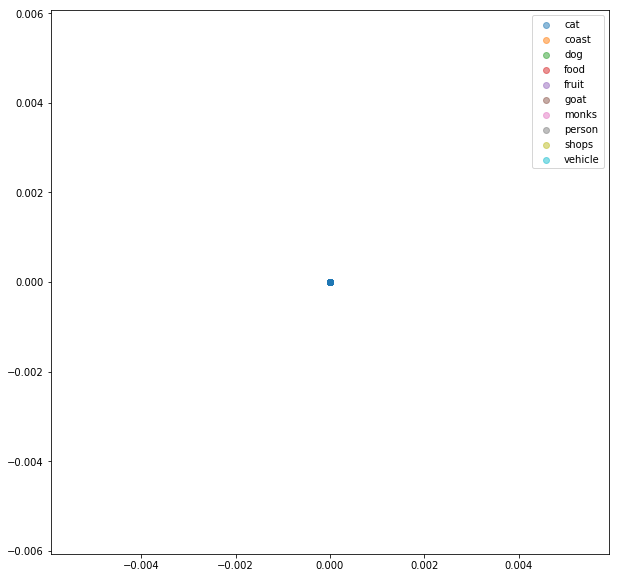

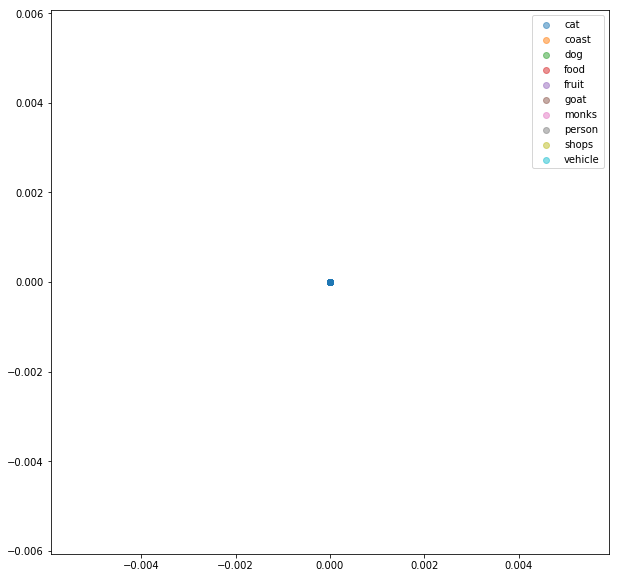

In [36]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

In [ ]:
class TripletMNIST(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}

        else:
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            # generate fixed triplets for testing
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            triplets = [[i,
                         random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                         random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels[i].item()]))
                                                 )
                                             ])
                         ]
                        for i in range(len(self.test_data))]
            self.test_triplets = triplets

    def __getitem__(self, index):
        if self.train:
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            img2 = self.train_data[positive_index]
            img3 = self.train_data[negative_index]
        else:
            img1 = self.test_data[self.test_triplets[index][0]]
            img2 = self.test_data[self.test_triplets[index][1]]
            img3 = self.test_data[self.test_triplets[index][2]]

        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        img3 = Image.fromarray(img3.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)
        return (img1, img2, img3), []

    def __len__(self):
        return len(self.mnist_dataset)

In [ ]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [ ]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

In [ ]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection

In [ ]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [ ]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

In [ ]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

## Online triplet selection

In [ ]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [ ]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

In [ ]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

In [ ]:
# display_emb_online, display_emb, display_label_online, display_label = train_embeddings_otl, train_embeddings_tl, train_labels_otl, train_labels_tl
display_emb_online, display_emb, display_label_online, display_label = val_embeddings_otl, val_embeddings_tl, val_labels_otl, val_labels_tl
x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

In [ ]:
x_lim = (np.min(train_embeddings_ocl[:,0]), np.max(train_embeddings_ocl[:,0]))
y_lim = (np.min(train_embeddings_ocl[:,1]), np.max(train_embeddings_ocl[:,1]))
plot_embeddings(train_embeddings_cl, train_labels_cl, x_lim, y_lim)
plot_embeddings(train_embeddings_ocl, train_labels_ocl, x_lim, y_lim)